<center><h1 style="text-align: center;"><u>TFM - Detección temprana del cáncer a partir marcadores biométricos en analíticas de sangre</u></h1>
<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

# Introducción <a id="introduccion"></a>

En este notebook se lleva a cabo el estudio sobre la predicción de cáncer y tipo de cáncer haciendo uso de múltiples modelos de aprendizaje supervisado y no supervisado.

Nuestra investigación parte del estudio recogido en el artículo "Early Cancer Detection from Multianalyte Blood Test Results" presente en : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6548890/ donde establecen el modelo CancerA1DE como el modelo raíz de su trabajo.

Después de analizar el enfoque expuesto y replicar sus pasos para entender mejor los procedimientos utilizados, desviamos nuestros pasos sobre el estudio para experimentar y comparar resultados.

De esta manera esperamos mejorar los resultados obtenidos aplicando modelos diferentes a los expuestos en su estudio.

El contenido del notebook se restringe a la parte técnica con los procesos finales de los distintos algoritmos utilizados. Se abarca el preprocesamiento de los datos, los diferentes modelos utilizados durante el proceso y los resultados obtenidos. 

El análisis y entendimiento de los datos, juntos con las pruebas de los algoritmos hasta afinar con los resultados finales se encuentra en el notebook "TFM.ipynb"

Para interpretar los datos, se ha escogido crear una tabla donde se guardan las características finales de cada modelo, para poder ser comparadas facilmente durante y al final del proceso.

| Model              | Approach | Set  | Accuracy     | Precision    | Recall       | F1-Score     | Adjusted Rand Index | Mean Squared Error | R-squared    | AUC-ROC     | TN  | FP | FN | TP  | Global Score |
|--------------------|----------|------|--------------|--------------|--------------|--------------|---------------------|--------------------|--------------|-------------|-----|----|----|-----|--------------|

La variable Global Score, es el resultado ponderado del resto de métricas de evaluación combinadas entre si, para dar un idea general de cuan bien rinde cada modelo. Es una variable estimada y no oficial siendo simplemente orientativa.


Para descargar las librerías usadas en este proyecto se puede hacer usar el comando "pip install -r requirements.txt" en el terminal

Estructura del notebook:
- [Introducción](#introducción)
- [Librerias](#librerias)
- [Funciones](#funciones)
- [Procesamiento de los datos](#data-process)
- [Parte 1 - Detección de cáncer](#parte-1---detección-de-cáncer)
    - [Aprendizaje Supervisado](#aprendizaje-supervisado)
        - [Resultados](#resultados)
        - [Conclusiones](#conclusion-parte-1)

    - [Aprendizaje No Supervisado](#aprendizaje-no-supervisado)
        - [Resultados](#resultados-modelos-no-supervisados)
    - [Cruces entre modelos supervisados y no supervisados](#cruces-entre-modelos--no-supervisados-y-supervisados)
- [Parte 2 - Detección del tipo de cáncer](#parte-2---detección-del-tipo-de-cáncer)
    - [Preprocesar Datos](#preprocesar-datos)
    - [Creación de datos sintéticos mediante CTGAN](#creación-de-datos-sintéticos-mediante-ctgan)
    - [Parte 1 - CTGAN - Detección de cancer](#parte-1---ctgan---detección-de-cancer)
    - [Parte 2 - CTGAN -  Detección del tipo de cancer](#parte-2---ctgan----detección-del-tipo-de-cancer)
    - [Crear y entrenar modelo Vosting Classifier](#crear-y-entrenar-modelo-vosting-classifier)
    - [Conclusiones](#conclusiones-parte-2)


# Librerias<a id="librerias"></a>

In [6]:
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import normaltest

# Entrenar el modelo
from sklearn.model_selection import train_test_split

# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_classif
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, r2_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt

from joblib import dump, load


# Funciones <a id="funciones"></a>

In [2]:
# Functions

# Conversion del dataFrame a tipo numeric
def convert_to_numeric(column):
    if column.dtype in ['object','category']:
        # Verificar si hay letras en todos los registros
        contains_letters = any(isinstance(val, str) and any(c.isalpha() for c in val) for val in column)
        if not contains_letters :
            return pd.to_numeric(column, errors='coerce')
    return column

def show_correlation(df_prep, title = 'Correlación del DataFrame') :
    # Suponiendo que df_prep es tu DataFrame preprocesado
    numeric_correlation_matrix = df_prep.select_dtypes(include=np.number).corr()

    # Crear una matriz de anotaciones con cadenas vacías para valores por debajo del umbral
    annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')

    plt.figure(figsize=(30, 16))
    sns.heatmap(numeric_correlation_matrix, annot=annot_matrix, cmap='coolwarm', fmt="", annot_kws={"size": 10})
    plt.title(title)
    plt.show()
def discretizar_df_arboles_1(df, max_depth=40, n_bins=18, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc' or columna.name == 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado.apply(convert_to_numeric)

# Discretizar dataFrame y mostrar correlación respecto a la variable objetivo
def discretizar_df_arboles(df, imprimir="SI", max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc' or columna.name != 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
   # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas = df_discretizado.corrwith(df_discretizado['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

    if imprimir == "SI":
        # Imprimir las top 20 correlaciones
        print(top_20_correlaciones_discretas)

    return df_discretizado


def escalado_dataFrame(df) :
    if df.empty:
        raise ValueError("El DataFrame está vacío, no se puede realizar el escalado.")

    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Normalizar df_imputacion_iterativa
    df_normalized = df.select_dtypes(include=['number']).copy()  # Crear una copia del DataFrame original
    
    if not df_normalized.empty:
        df_normalized[df_normalized.columns] = scaler.fit_transform(df_normalized)
    else :
        print("Esto está vacío")
    return df_normalized

def calcular_ganancia_informacion(df_features, target, imprimir = 'SI'):
    
    # Extraer las características de interés del DataFrame
    X_interest = df_features.values
    
    # Extraer la variable objetivo del DataFrame principal
    y = target.values
    
    # Calcular la Ganancia de Información utilizando Mutual Information
    information_gain = mutual_info_classif(X_interest, y, discrete_features=False, random_state=42, n_neighbors=7)
    
    # Crear un DataFrame para visualizar los resultados
    ig_results = pd.DataFrame({'Feature': df_features.columns, 'Information Gain': information_gain})
    
    # Ordenar los resultados por Ganancia de Información en orden descendente
    ig_results_sorted = ig_results.sort_values(by='Information Gain', ascending=False)

    if imprimir == "SI":
        print(ig_results_sorted)

# División del conjunto de datos en entrenamiento, validacion y test 

def grid_search_cv(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=None):
    """
    Divide un conjunto de datos en entrenamiento, validación y test.

    Args:
        X: Matriz de características.
        y: Vector de etiquetas.
        train_size: Porcentaje de datos para entrenamiento (por defecto: 0.6).
        val_size: Porcentaje de datos para validación (por defecto: 0.2).
        test_size: Porcentaje de datos para test (por defecto: 0.2).
        random_state: Semilla para la aleatorización (por defecto: None).

    Returns:
        Tuple: (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    assert train_size + val_size + test_size == 1.0, "La suma de train_size, val_size y test_size debe ser igual a 1.0"

    # Dividir los datos en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    # Calcular porcentaje respecto al tamaño original
    val_size_relative = val_size / (1.0 - test_size)

    # Dividir los datos de entrenamiento en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_relative, random_state=random_state, shuffle=True)

    return X_train, X_val, X_test, y_train, y_val, y_test

def mostrar_cross_validation(model, X_train, y_train):
    cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )
    print("Cross validation : ")
    print(f"Métricas validación cruzada: {cv_scores}")
    print(f"Média métricas de validación cruzada: {cv_scores.mean()}")
    print("")

def mostrar_score(X_train, y_train, model):
    score = round(model.score(X_train, y_train), 3)*100
    print(f"Tanto por ciento de acierto : {score} %")
    print("")

def mostrar_estadisticas(y_val, y_pred) :
    mse = round(mean_squared_error(y_val, y_pred),3)
    accuracy = round(accuracy_score(y_val, y_pred),3)
    precision = round(precision_score(y_val, y_pred),3)
    recall = round(recall_score(y_val, y_pred),3)
    f1 = round(f1_score(y_val, y_pred),3)
    conf_matrix = confusion_matrix(y_val, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Error cuadrático medio en el conjunto de validación:", mse)
    print("Matriz de Confusión :\n", conf_matrix)
    print("")

def mostrar_curva_ROC(y_val, y_pred) :
    fpr, tpr, _ = roc_curve(y_val, y_pred)

    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Plotear la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"Metrics for {set_name} set:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Función para mostrar métricas y añadirlas a un DataFrame
def mostrar_estadisticas_guardar_tabla(y_val, y_pred, set_name, model_name, enfoque, print_roc = 'NO'):
    '''
    Ejemplo de uso :

    # Fase de entrenamiento
    results_df = mostrar_estadisticas_guardar_tabla(y_train, kmeans.predict(X_train_prep), "Training", results_df, model_name)

    # Fase de validación
    results_df = mostrar_estadisticas_guardar_tabla(y_val, kmeans.predict(X_val_prep), "Validation", results_df, model_name)

    # Fase de prueba
    results_df = mostrar_estadisticas_guardar_tabla(y_test, kmeans.predict(X_test_prep), "Test", results_df, model_name)

    # Importante: Al final de todos los modelos (fuera del método): Guardar los resultados en un archivo Excel
    results_df.to_excel('model_results.xlsx', index=False)

    '''
    global tabla_results_df
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    rand_index = adjusted_rand_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    if conf_matrix.shape == (2, 2):  # Asegúrate de que es una matriz de confusión 2x2
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        tn = fp = fn = tp = None  # Si no es una matriz 2x2, asigna valores None
    
    global_score = calcular_puntuacion_global(accuracy, precision, recall, f1, rand_index, r2, mse, tn, fp, fn, tp, roc_auc)
    
    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set :")
    print(f" - Accuracy: {accuracy:.4f}")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall: {recall:.4f}")
    print(f" - F1-Score: {f1:.4f}")
    print(f" - Adjusted Rand Index: {rand_index:.4f}")
    print(f" - Mean Squared Error: {mse:.4f}")
    print(f" - R-squared: {r2:.4f}")
    print(f" - Área bajo la curva : {roc_auc:.3f}")
    print(f" - Confusion Matrix: \n{conf_matrix}")
    #if tn is not None and fp is not None and fn is not None and tp is not None:
    #   print(f"\tTN: {tn}\n\tFP: {fp}\n\tFN: {fn}\n\tTP: {tp}")
    print(f" - Global Score : {global_score}")
    print(f"")
    
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Approach': [enfoque],
        'Set': [set_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Adjusted Rand Index': [rand_index],
        'Mean Squared Error': [mse],
        'R-squared': [r2],
        'AUC-ROC': [roc_auc],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'TP': [tp],
        'Global Score' : [global_score]
    })

    if (print_roc == 'SI') :
        plot_ROC(fpr, tpr, roc_auc)
    
    tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)
    
    return tabla_results_df

def plot_ROC(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

def calcular_puntuacion_global(accuracy, precision, recall, f1, rand_index, r2, mse, tn, fp, fn, tp, auc_roc):
    # Definir ponderaciones para cada métrica
    weights = {
        'accuracy': 0.12,
        'precision': 0.12,
        'recall': 0.12,
        'f1': 0.12,
        'rand_index': 0.1,
        'r2': 0.05,
        'mse': 0.05,
        'tpr': 0.1,
        'fpr': 0.1,
        'auc_roc': 0.12,
    }
    
     # Normalizar las métricas
    mse_norm = (1 - mse)  # Invertir MSE ya que menor es mejor
    r2_norm = (r2 + 1) / 2  # Normalizar R2 para que esté entre 0 y 1
    
    # TPR y FPR
    tpr = recall  # TPR es lo mismo que recall
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Asegurar no división por cero

    # Invertir FPR ya que menor es mejor
    fpr_inverted = 1 - fpr

    # Calcular la puntuación global
    global_score = (accuracy * weights['accuracy'] +
                    precision * weights['precision'] +
                    recall * weights['recall'] +
                    f1 * weights['f1'] +
                    rand_index * weights['rand_index'] +
                    r2_norm * weights['r2'] +
                    mse_norm * weights['mse'] +
                    tpr * weights['tpr'] +
                    fpr_inverted * weights['fpr'] +
                    auc_roc * weights['auc_roc'])
    
    return round(global_score * 100, 2)

# Funciones para aprendizaje no supervisado
def optimal_cluster_number(X_train, X_val, model, max_clusters=10, method='elbow', plot_grafica = 'NO'):
    """
    Encuentra el número óptimo de clusters para un modelo de clustering utilizando el método del codo (Elbow Method)
    u otros métodos.
    """
    if method == 'elbow':
        distortions = []
        for i in range(1, max_clusters + 1):
            model.n_clusters = i
            model.fit(X_train)
            distortions.append(model.inertia_)
        if plot_grafica == 'SI':
            # Plotting the elbow curve
            plt.plot(range(1, len(distortions) + 1), distortions, marker='o')
            plt.xlabel('Número de clusters')
            plt.ylabel('Distorsión')
            plt.title('Método del codo para encontrar el número óptimo de clusters')
            plt.show()

        # Finding the optimal number of clusters based on the elbow point
        optimal_k = np.argmin(np.gradient(distortions)) + 1
        if optimal_k == 1:  # Ensure that the optimal number of clusters is greater than 1
            optimal_k = 2
        return optimal_k

    elif method == 'silhouette':
        silhouette_scores = []
        for i in range(2, max_clusters + 1):
            model.n_clusters = i
            model.fit(X_train)
            labels = model.predict(X_val)
            silhouette_scores.append(silhouette_score(X_val, labels))
        
        if plot_grafica == 'SI':
            # Plotting the silhouette scores
            plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
            plt.xlabel('Número de clusters')
            plt.ylabel('Silhouette Score')
            plt.title('Silhouette Score para encontrar el número óptimo de clusters')
            plt.show()

        # Finding the optimal number of clusters based on silhouette score
        optimal_k = np.argmax(silhouette_scores) + 2
        return optimal_k

    else:
        raise ValueError("Método no válido. Métodos disponibles: 'elbow', 'silhouette', etc.")


# Función para motrar estadísticas para modelos de aprendizaje no supervisado   
def mostrar_estadisticas_guardar_tabla_NS(X, labels, set_name, model_name):
    '''
    Ejemplo de uso :

    # Fase de entrenamiento
    results_df = mostrar_estadisticas_guardar_tabla(X_train, kmeans.predict(X_train), "Training", model_name, results_df)

    # Fase de validación
    results_df = mostrar_estadisticas_guardar_tabla(X_val, kmeans.predict(X_val), "Validation", model_name, results_df)

    # Fase de prueba
    results_df = mostrar_estadisticas_guardar_tabla(X_test, kmeans.predict(X_test), "Test", model_name, results_df)

    # Importante: Al final de todos los modelos (fuera del método): Guardar los resultados en un archivo Excel
    results_df.to_excel('model_results.xlsx', index=False)
    '''
    global tabla_results_NS_df
    silhouette_avg = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    global_score = calcular_puntuacion_global_NS(silhouette_avg, db_score, ch_score)
    
    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set ({model_name}):")
    print(f" - Silhouette Score: {silhouette_avg:.4f}")
    print(f" - Davies-Bouldin Index: {db_score:.4f}")
    print(f" - Calinski-Harabasz Index: {ch_score:.4f}")
    print(f" - Global Score: {global_score:.4f}")
    print(f"")
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Set': [set_name],
        'Silhouette Score': [silhouette_avg],
        'Davies-Bouldin Index': [db_score],
        'Calinski-Harabasz Index': [ch_score],
        'Global Score': [global_score]
    })
    
    tabla_results_NS_df = pd.concat([tabla_results_NS_df, new_row], ignore_index=True)
    
    return tabla_results_NS_df

def calcular_puntuacion_global_NS(silhouette_avg, db_score, ch_score):
    # Normalizando los valores para que estén en el rango de 0 a 100
    normalized_silhouette = (silhouette_avg + 1) * 50  # Ajustando el rango del Silhouette Score de -1 a 1 a 0 a 100
    normalized_davies_bouldin = (1 - db_score) * 50  # Ajustando el rango del Davies-Bouldin Index de 0 a 1 a 0 a 100

    # Calculando el puntaje global promediando los puntajes normalizados
    global_score = (normalized_silhouette + normalized_davies_bouldin + ch_score) / 3

    return global_score

def encontrar_numero_optimo_clusters(X_train, X_val, model, max_clusters=10, plot_grafica = 'NO'):
    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    global_scores = []

    for i in range(2, max_clusters+1):
        model.n_clusters = i
        model.fit(X_train)

        # Predecir las etiquetas para los datos de validación
        labels = model.predict(X_val)

        # Calcular las métricas
        silhouette = silhouette_score(X_val, labels)
        davies_bouldin = davies_bouldin_score(X_val, labels)
        calinski_harabasz = calinski_harabasz_score(X_val, labels)
        
        global_score = calcular_puntuacion_global_NS(silhouette, davies_bouldin, calinski_harabasz)
        
        wcss.append(model.inertia_)
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(calinski_harabasz)
        global_scores.append(global_score)

    if plot_grafica == 'SI':
        # Plot para el método del codo
        plt.figure(figsize=(12, 8))
        plt.plot(range(2, max_clusters+1), wcss, marker='o')
        plt.title('Método del Codo')
        plt.xlabel('Número de Clústeres')
        plt.ylabel('WCSS')
        plt.show()

        # Plot para las métricas de validación
        plt.figure(figsize=(12, 8))
        plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o', label='Silhouette Score')
        plt.plot(range(2, max_clusters+1), davies_bouldin_scores, marker='o', label='Davies-Bouldin Index')
        plt.plot(range(2, max_clusters+1), calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Index')
        plt.plot(range(2, max_clusters+1), global_scores, marker='o', label='Global Score')
        plt.title('Métricas de Validación para Diferentes Números de Clústeres')
        plt.xlabel('Número de Clústeres')
        plt.ylabel('Valor de la Métrica')
        plt.legend()
        plt.show()

    # Encontrar el número óptimo de clústeres basado en el puntaje global
    numero_optimo_clusters = range(2, max_clusters+1)[np.argmax(global_scores)]
    return numero_optimo_clusters

def invert_preprocessor(preprocessor, data_prep):
    # Obtén las columnas numéricas y categóricas del preprocesador
    numeric_cols = preprocessor.transformers_[0][2]
    cat_cols = preprocessor.transformers_[1][2]
    
    # Invertir la transformación para los datos numéricos
    scaler = preprocessor.named_transformers_['scale']
    numeric_data_transformed = data_prep[numeric_cols]
    original_numeric_data = scaler.inverse_transform(numeric_data_transformed)
    
    # Invertir la transformación para los datos categóricos
    onehot = preprocessor.named_transformers_['onehot']
    encoded_columns = onehot.get_feature_names_out(cat_cols)
    categorical_data_transformed = data_prep[encoded_columns]
    original_categorical_data = onehot.inverse_transform(categorical_data_transformed)
    
    # Combinar las columnas invertidas con las columnas restantes
    original_data = pd.DataFrame(original_numeric_data, columns=numeric_cols)
    for i, col in enumerate(cat_cols):
        original_data[col] = original_categorical_data[:, i]
    
    # Combinar las columnas originales si hay columnas que se pasaron sin transformar (remainder='passthrough')
    if preprocessor.remainder == 'passthrough':
        passthrough_cols = data_prep.columns.difference(numeric_cols + list(encoded_columns))
        passthrough_data = data_prep[passthrough_cols]
        original_data = pd.concat([original_data, passthrough_data.reset_index(drop=True)], axis=1)
    
    return original_data


# Procesamiento de datos

 En esta etapa se lleva a cabo una carga de los datos y, trás analizar los posibles preprocesamientos de manera externa, se escogen los procesos que se han visto que mejor se ajustan a los datos y que a su vez no entrañan una complejidad excesiva.

 - Se eliminan ciertos carácteres indeseados.
 - Se hace una conversión del tipo de los datos a variables numéricas. En caso de poser carácteres, no se lleva a cabo tratamiento.
 - Por suerte los datos se encuentran en muy buenas condiciones en cuanto a valores nulos, únicamente tenemos ciertos valores faltantes en variables contadas.
    - Se hace un relleno de nulos personalizado para la columna "AJCC Stage".
    - Se rellenan los nulos de las variables numéricas usando la media de cada variable. El posible sesgo intrducido es practicamente inexistente debido a las pocos nulos existentes.
- Se binariza la variable objetivo 'Tumor type' a mano, tomando la no presencia de cáncer cuando 'Tumor type' es igual a 'Normal'. En caso contrario, estaremos ante un registro con presencia de cáncer.

Enfoques.

Se estudian dos enfoques en esta primera parte. 
- [ENFOQUE 1] Las mejores 9 variables según su information gain ('CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)')

| Feature                   | Info Gain |
|---------------------------|-----------|
| CA19-9 (U/ml)             | 0.6897    |
| CA-125 (U/ml)             | 0.5119    |
| HGF (pg/ml)               | 0.5001    |
| OPN (pg/ml)               | 0.2779    |
| OmegaScore                | 0.2208    |
| Prolactin (pg/ml)         | 0.1826    |
| CEA (pg/ml)               | 0.1518    |
| Myeloperoxidase (ng/ml)   | 0.0989    |
| TIMP-1 (pg/ml)            | 0.0916    |

- [ENFOQUE 2] Las mejores 9 variables según el estudio llevado a cabo mediante árboles de décision para extraer la correlación de las variables frente a la variable objetivo binarizada. 
Sorprendentemente, los marcadores de antígenos del cáncer ya no son las características predictivas principales. 
Se observa por tanto la complejidad que reside dentro de estos biomarcadores y cómo se relacionan entre sí.

| Feature                   | Corr. w/ target |
|---------------------------|-----------|
| OPN (pg/ml)               | 0.575480  |
| IL-6 (pg/ml)              | 0.483620  |
| IL-8 (pg/ml)              | 0.464828  |
| HGF (pg/ml)               | 0.454991  |
| Prolactin (pg/ml)         | 0.453270  |
| Omega score               | 0.378112  |
| GDF15 (ng/ml)             | 0.365248  |
| CYFRA 21-1 (pg/ml)        | 0.356245  |
| Myeloperoxidase (ng/ml)   | 0.351481  |

De esta manera podemos comparar qué influencia tienen las variables y que conjunto funciona mejor a la hora de llevar a cabo la predicción del cáncer.

- Tomando estos dos enfoques, se reducen las variables del estudio a las expuestas.
- Se separan los datos en train (60%), validación (20%) y test (20%) : X_train, X_val, X_test, y_train, y_val, y_test
- Se lleva a cabo un preprocesado de los datos, aplicando un escalado para varaibles numéricas y on OnHotEncoding para las variables categóricas (llegados a este punto, inexistentes).



C:\Users\danie\AppData\Local\Temp\ipykernel_21564\2464742697.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')


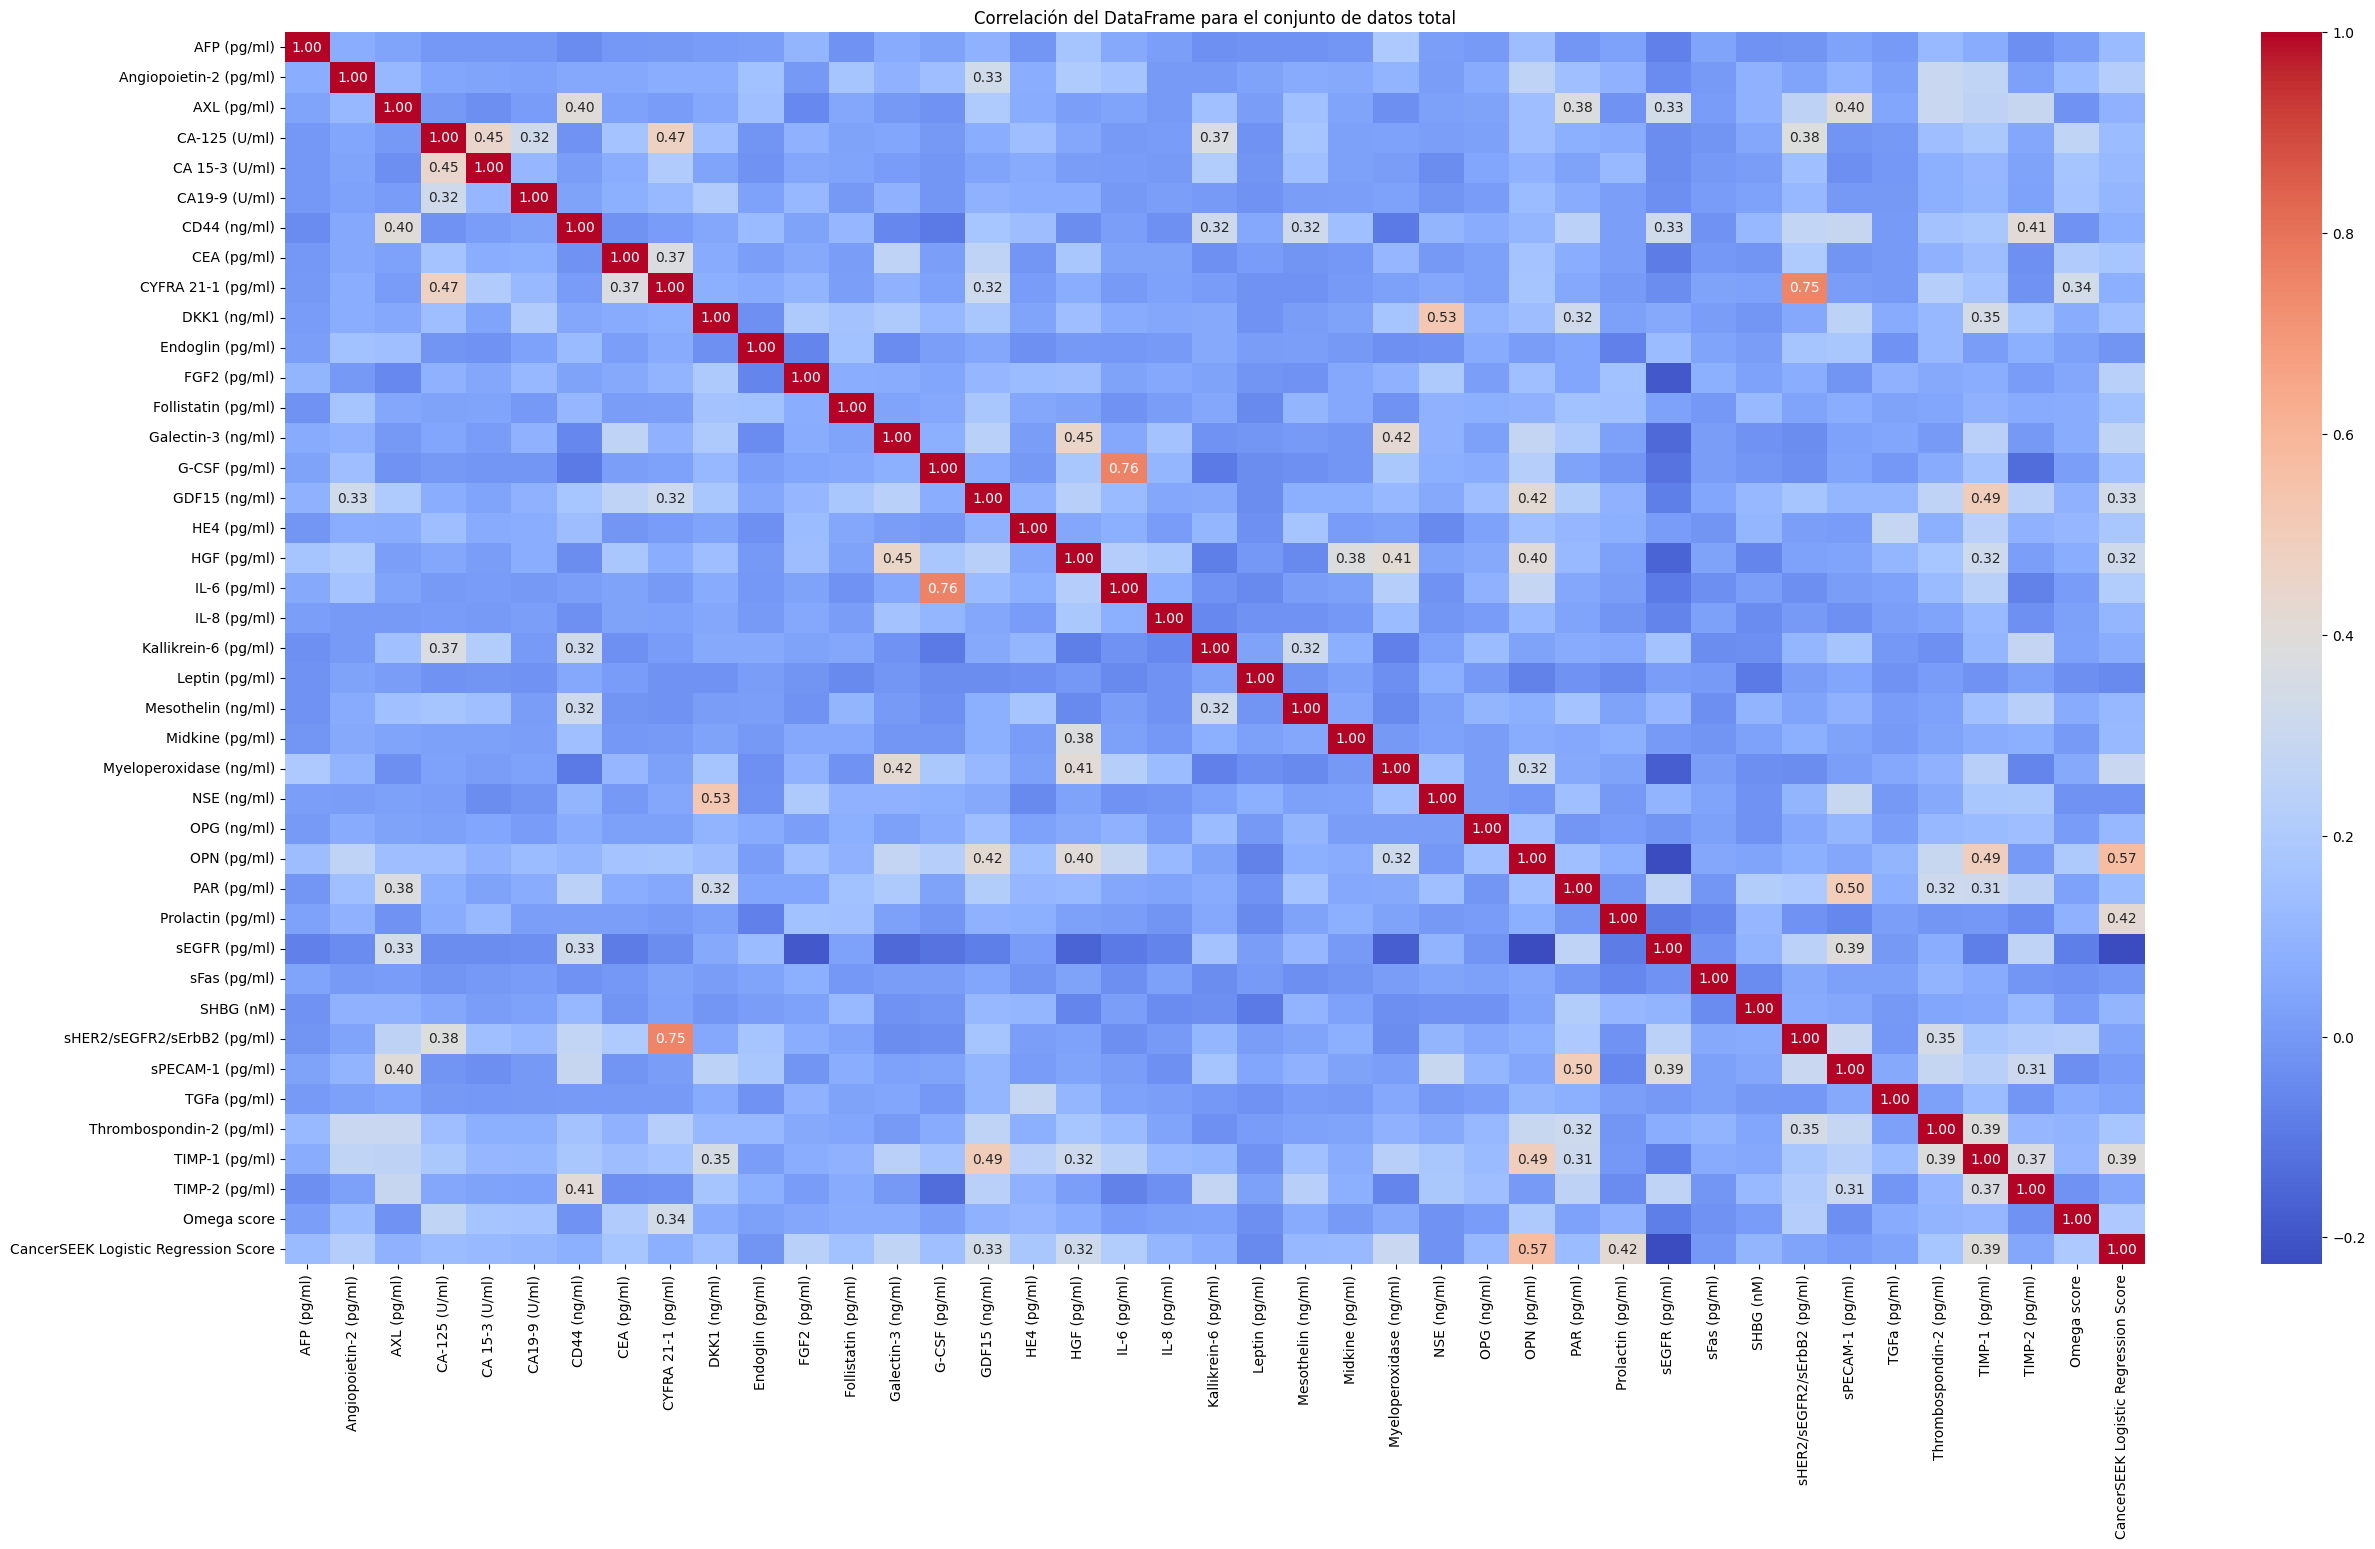

C:\Users\danie\AppData\Local\Temp\ipykernel_21564\2155012244.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_values[col], inplace=True)
C:\Users\danie\AppData\Local\Temp\ipykernel_21564\2464742697.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')


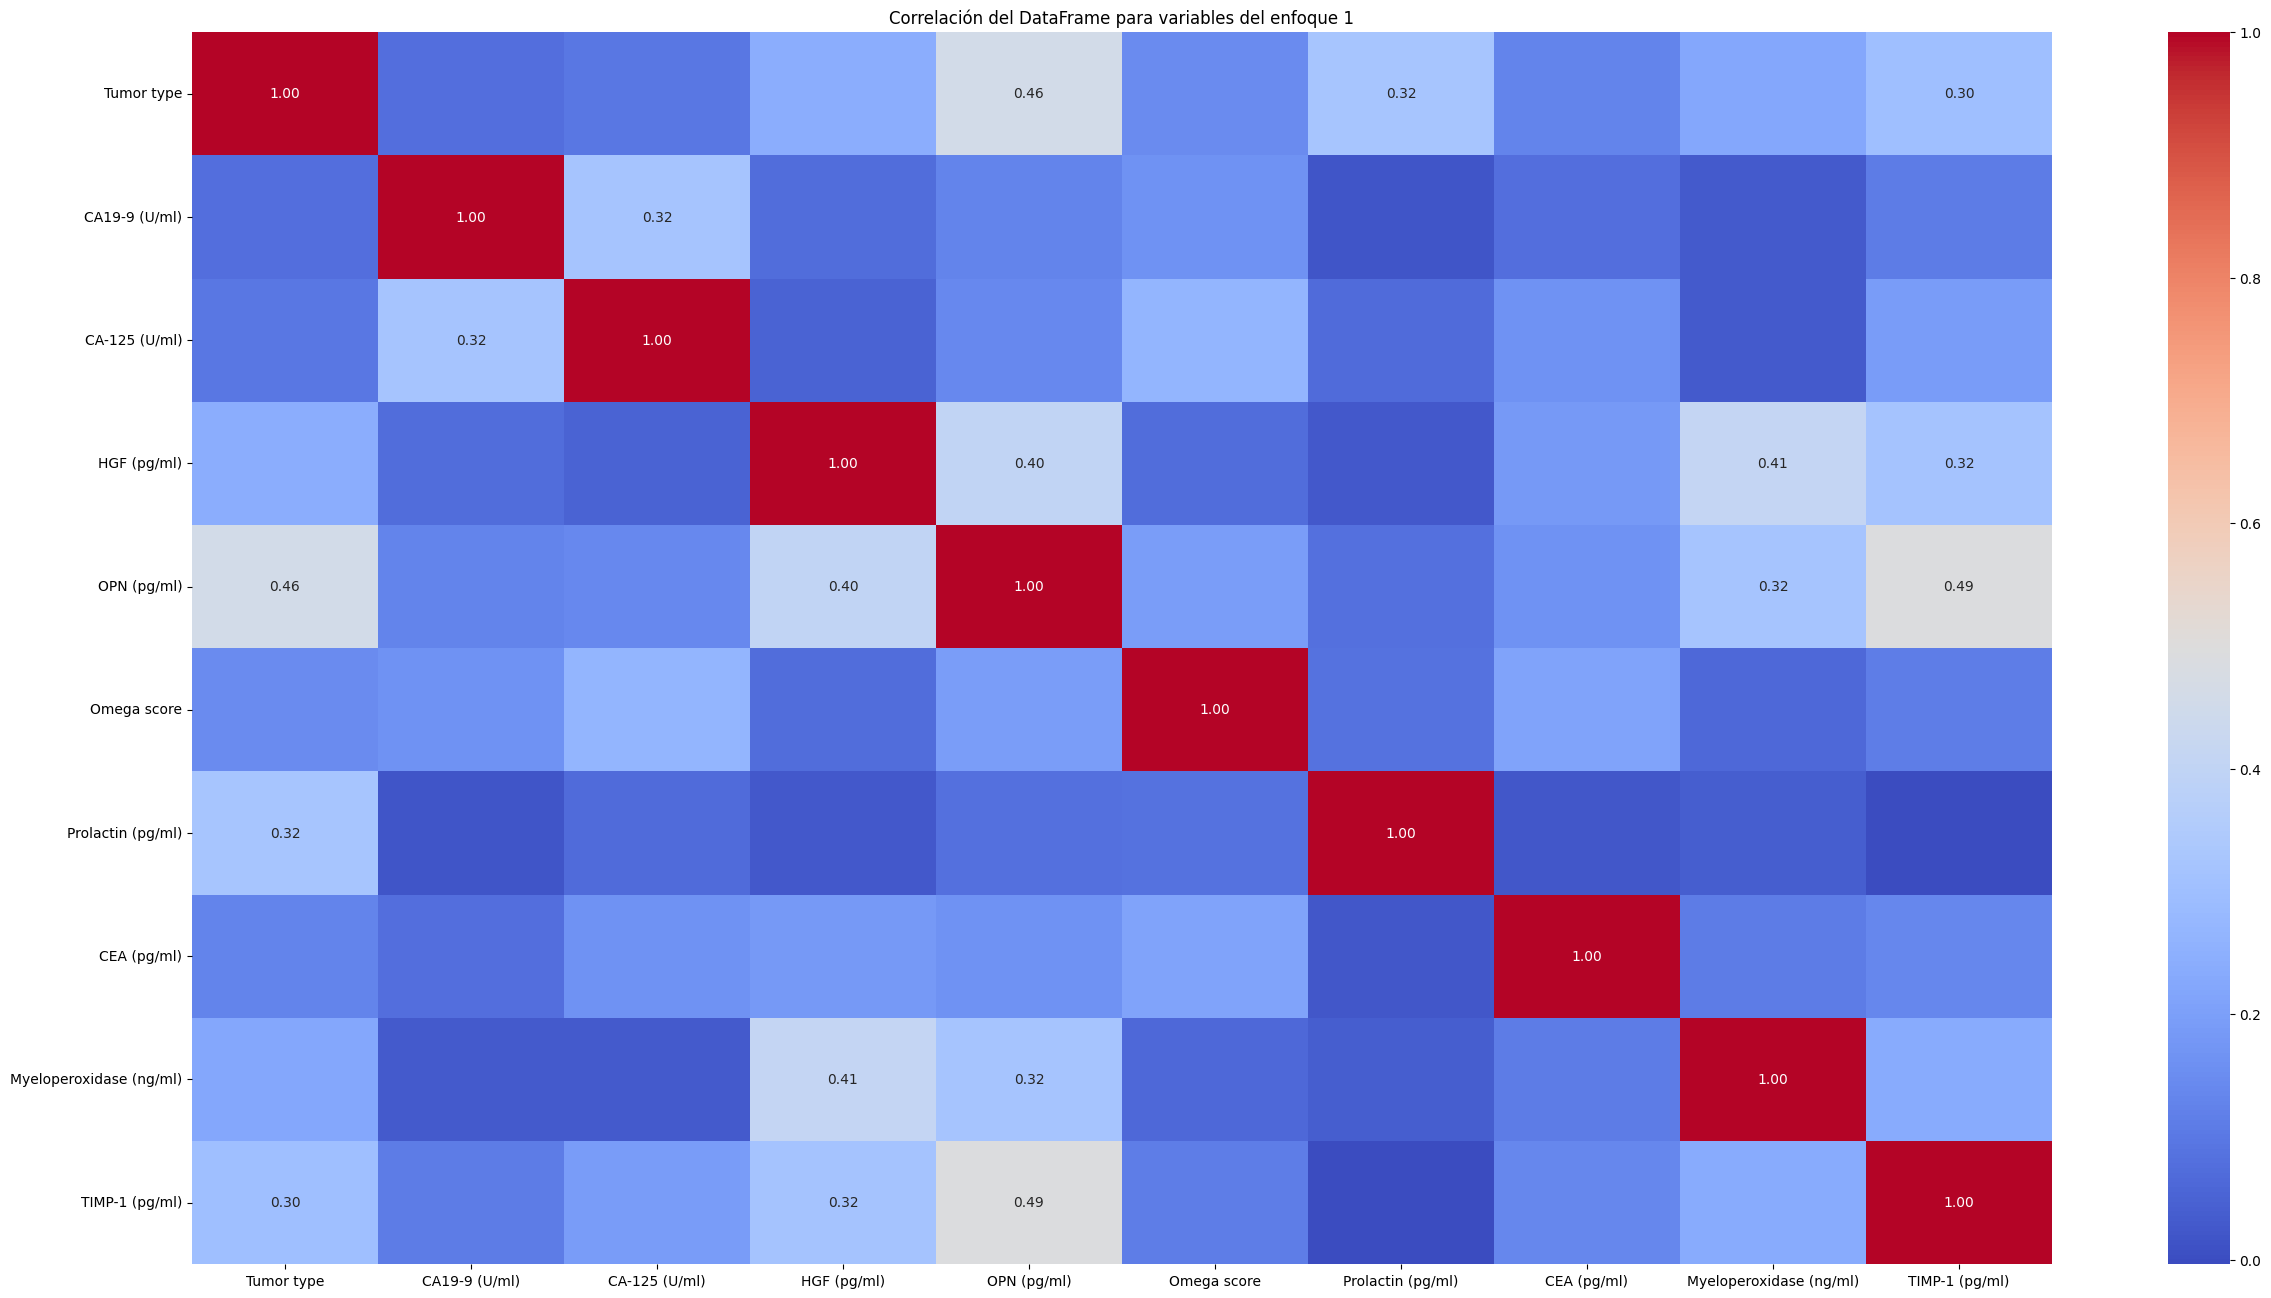

C:\Users\danie\AppData\Local\Temp\ipykernel_21564\2464742697.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')


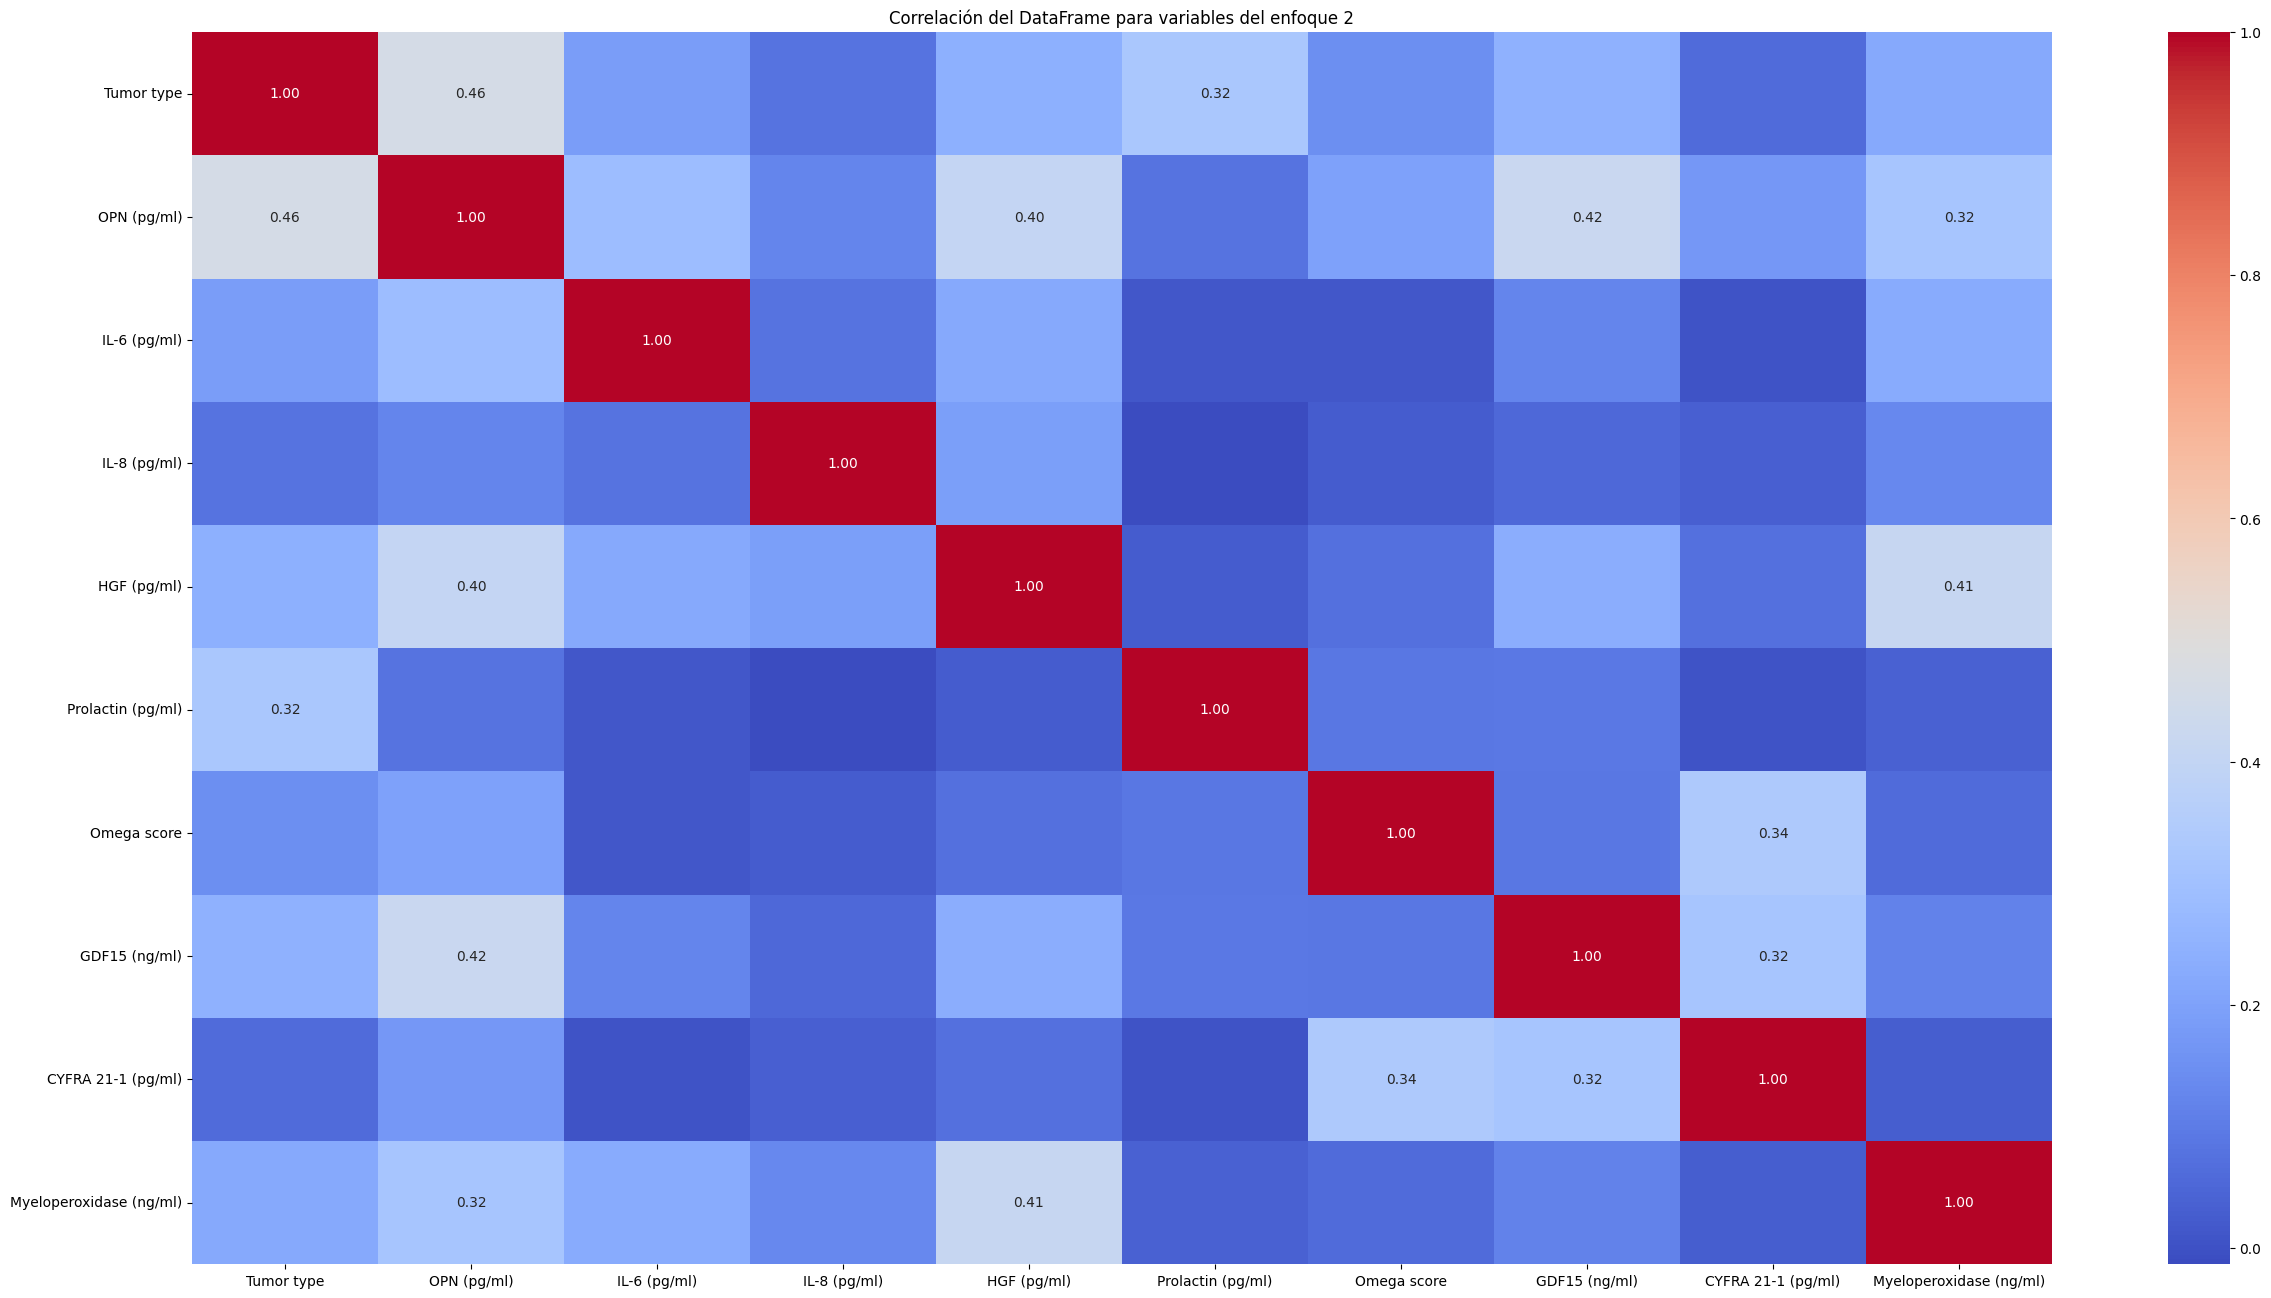

In [6]:
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Proposiciones/Deteccion Cancer/Datos/{nombreArchivo}.xlsx'

# Se procede a hacer una carga de los datos. 
df_original= pd.read_excel(url_datos, sheet_name='Table S6')

# Crear una copia del DataFrame original para realizar los cambios
df6 = df_original.copy()

# Recorrer las columnas del DataFrame para eliminar las cadenas de texto : ['*', '**']
for columna in df6.columns:
    if df6[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in ['*', '**']:
            df6[columna] = df6[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

df_prep = df6.apply(convert_to_numeric)

show_correlation(df_prep, title='Correlación del DataFrame para el conjunto de datos total')

# Relleno de nulos de la variable "AJCC Stage"
df_prep["AJCC Stage"] = df_prep["AJCC Stage"].fillna("0")

# Calcular la media solo para las columnas numéricas
numeric_columns = df_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df = df_prep.copy()  # Copiar el DataFrame preprocesado para evitar modificarlo
for col in mean_values.index:
    df[col].fillna(mean_values[col], inplace=True)


# Binarización "Tumor Type" 0 -> NO CANCER; 1 -> SI CANCER + 'CancerSEEK Test Result'
df['Tumor type'] = df['Tumor type'].apply(lambda x: 0 if str(x).strip().lower() == "normal" else 1).astype(int)
#df['CancerSEEK Test Result'] = df['CancerSEEK Test Result'].apply(lambda x: 0 if str(x).strip().lower() == "negative" else 1).astype(int)

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['Tumor type','CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']

## --- CHECKPOINT ----- Datos limpios

# Columna objetivo
Y_column = df['Tumor type'].copy()
# Reducción del dataFrame
df_reduced = df[columnas_a_conservar].copy()
#Copia del dataFrame entero
df_full = df.copy()

''' INICIO - Verificacion del information gain'''
# Information Gain inicial
df_discretizado = discretizar_df_arboles_1(df_reduced.drop(columns=['Tumor type']))
df_reduced_discretizado_escalated = escalado_dataFrame(df_discretizado)
calcular_ganancia_informacion(df_reduced_discretizado_escalated, Y_column, imprimir = "NO")

# Information Gain usando arboles de decision (acorde a : "..the cancer antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the purity and accuracy measurements..")
df_discretizado_full = discretizar_df_arboles(df_full, imprimir ="NO") # Columnas de este segundo enfoque guardadas en columnas_segundo_enfoque
df_discretizado_reduced = discretizar_df_arboles(df_reduced,imprimir ="NO")

''' FIN - Verificacion del information gain'''

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE SUPERVISADO
tabla_results_df = pd.DataFrame(columns=['Model', 'Approach', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Adjusted Rand Index', 'Mean Squared Error', 'R-squared','AUC-ROC', 'TN', 'FP', 'FN', 'TP', 'Global Score'])

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE NO SUPERVISADO
tabla_results_NS_df = pd.DataFrame(columns=['Model', 'Set', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Global Score'])

## --- CHECKPOINT ----- Datos discretizados + Information gain
# TODO Una vez hechos los modelos, habrá que estudiar cómo influye el usar esta serie de variables en la predicción
columnas_segundo_enfoque = ['Tumor type','OPN (pg/ml)','IL-6 (pg/ml)','IL-8 (pg/ml)','HGF (pg/ml)','Prolactin (pg/ml)','Omega score','GDF15 (ng/ml)','CYFRA 21-1 (pg/ml)','Myeloperoxidase (ng/ml)']
df_reduced_segundo_enfoque = df[columnas_segundo_enfoque].copy()

''' Valores para X
1. df : entero, limpio, sin normalizar ni discretizar
2. df_reduced : reducido, limpio, sin normalizar ni discretizar
3. df_reduced_discretizado_escalated --> Acorde a la Tabla 1
4. df_discretizado_full.drop(columns=['Tumor type']) --> Acorde a la Figura S3 (usando todas las variables) discretizado con arbol de decisión
5. df_discretizado_reduced.drop(columns=['Tumor type']) --> Acorde a la Figura S3; discretizado con arbol de decisión
'''
show_correlation(df_reduced, title='Correlación del DataFrame para variables del enfoque 1')

''' Enfoque 1 '''
y = df_reduced['Tumor type']
X = df_reduced.drop(columns='Tumor type')

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

# TODO DUDA - Añadir un proceso de discretización? Puede mejorar el resultado. Ver cómo influye usar la función 'discretizar_df_arboles' ó la función sklearn.preprocessing.KBinsDiscretizer
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep  = preprocessor.transform(X_test)
df_red_prep = preprocessor.transform(df_reduced)  

X_prep = np.vstack((X_train_prep, X_val_prep, X_test_prep))

show_correlation(df_reduced_segundo_enfoque, title='Correlación del DataFrame para variables del enfoque 2')
''' Enfoque 2 '''
y = df_reduced_segundo_enfoque['Tumor type']
X_2 = df_reduced_segundo_enfoque.drop(columns='Tumor type')

X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = split_data(X_2, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols_2 = X_train_2.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols_2 = X_train_2.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols_2),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

# TODO DUDA - Añadir un proceso de discretización? Puede mejorar el resultado. Ver cómo influye usar la función 'discretizar_df_arboles' ó la función sklearn.preprocessing.KBinsDiscretizer
X_train_prep_2 = preprocessor.fit_transform(X_train_2)
X_val_prep_2 = preprocessor.transform(X_val_2)
X_test_prep_2  = preprocessor.transform(X_test_2)

X_prep_2 = np.vstack((X_train_prep_2, X_val_prep_2, X_test_prep_2))


C:\Users\danie\AppData\Local\Temp\ipykernel_7664\2464742697.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')


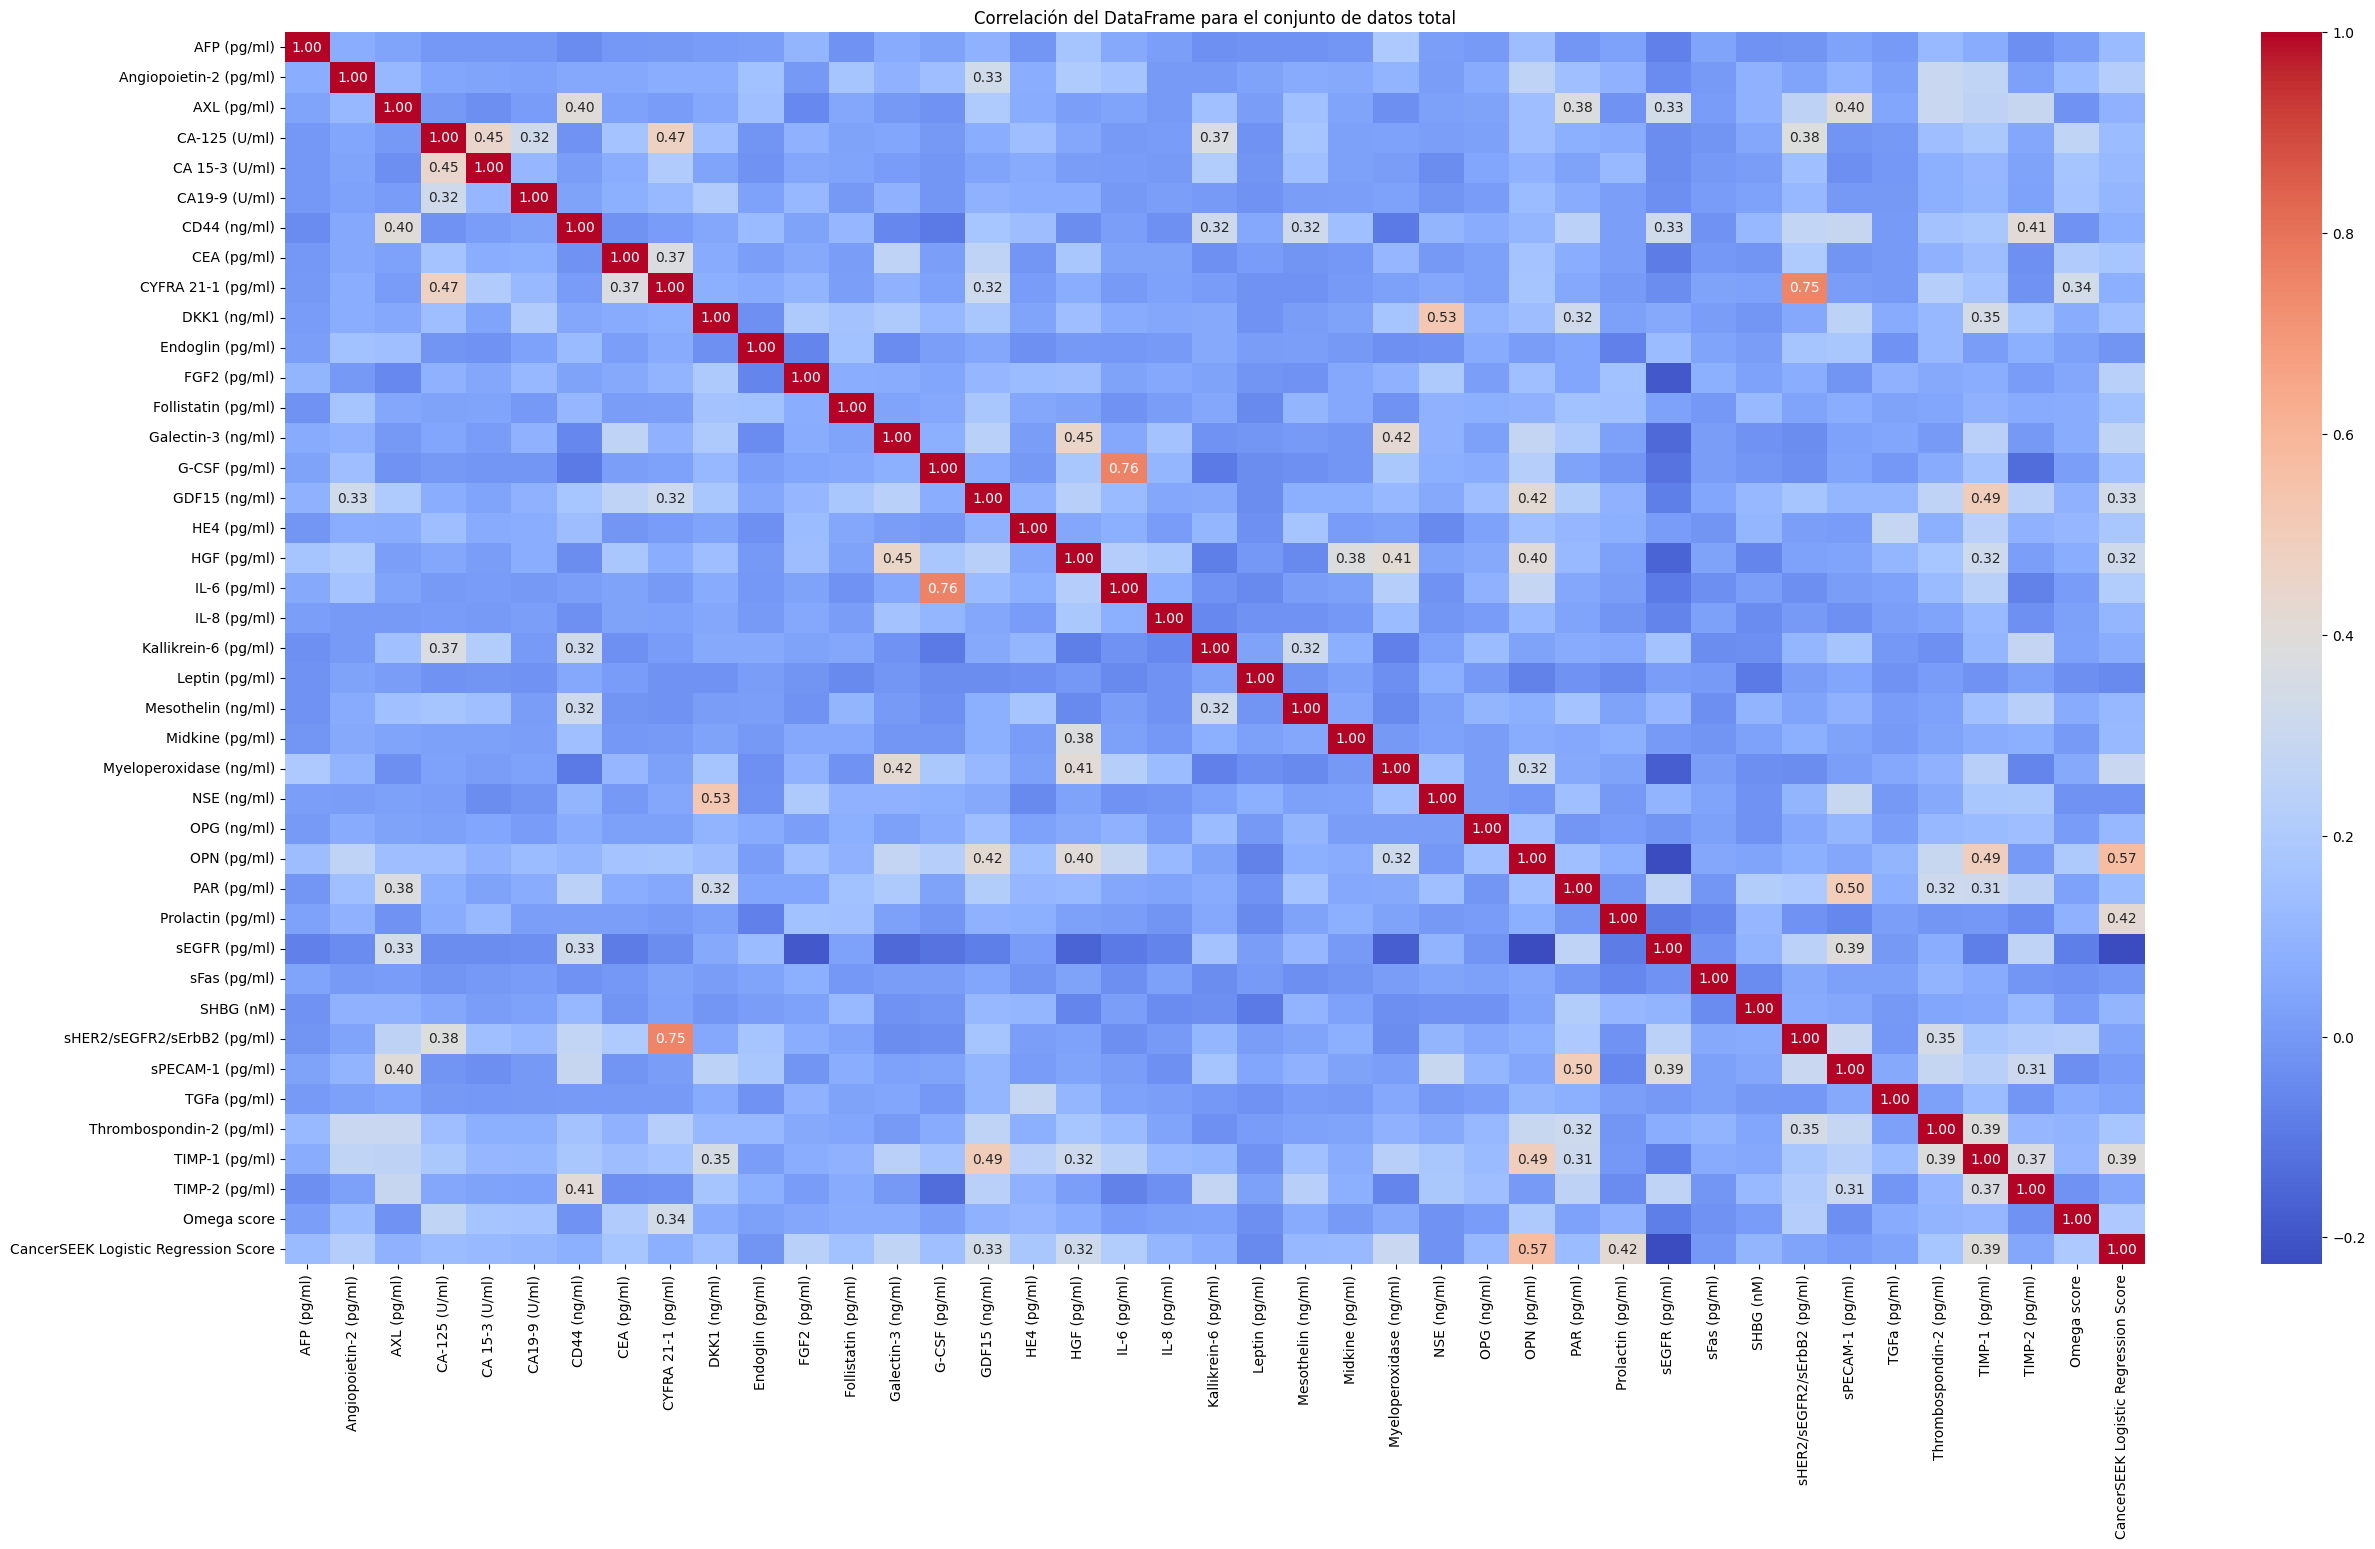

C:\Users\danie\AppData\Local\Temp\ipykernel_7664\1211755271.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_values[col], inplace=True)
C:\Users\danie\AppData\Local\Temp\ipykernel_7664\2464742697.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')


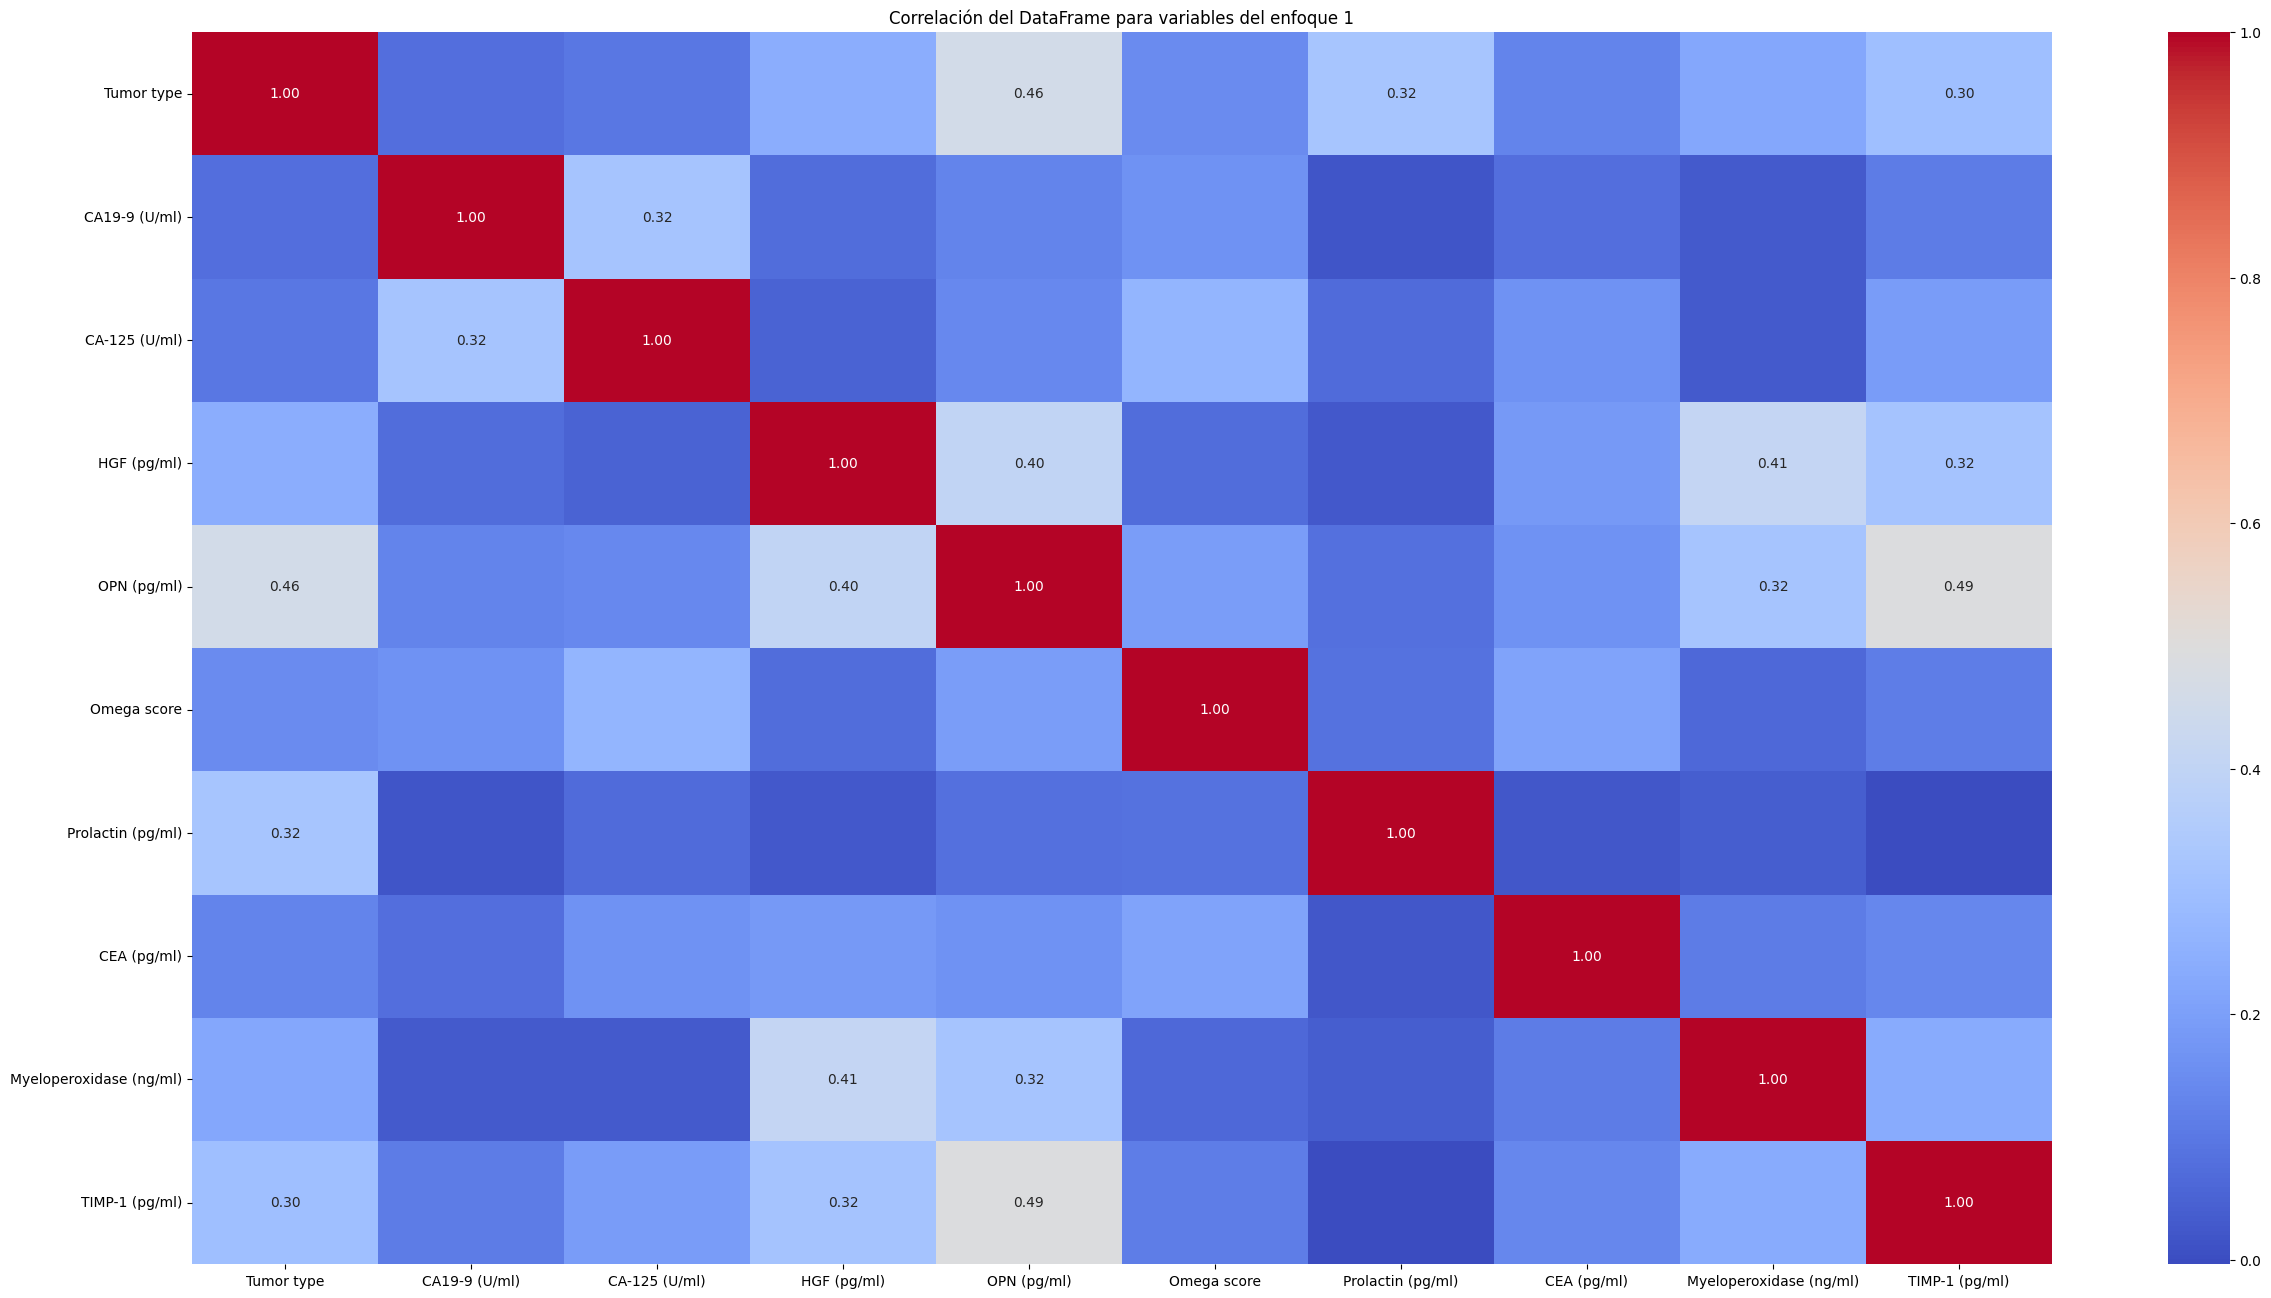

C:\Users\danie\AppData\Local\Temp\ipykernel_7664\2464742697.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = numeric_correlation_matrix.applymap(lambda x: f'{x:.2f}' if np.abs(x) > 0.3 else '')


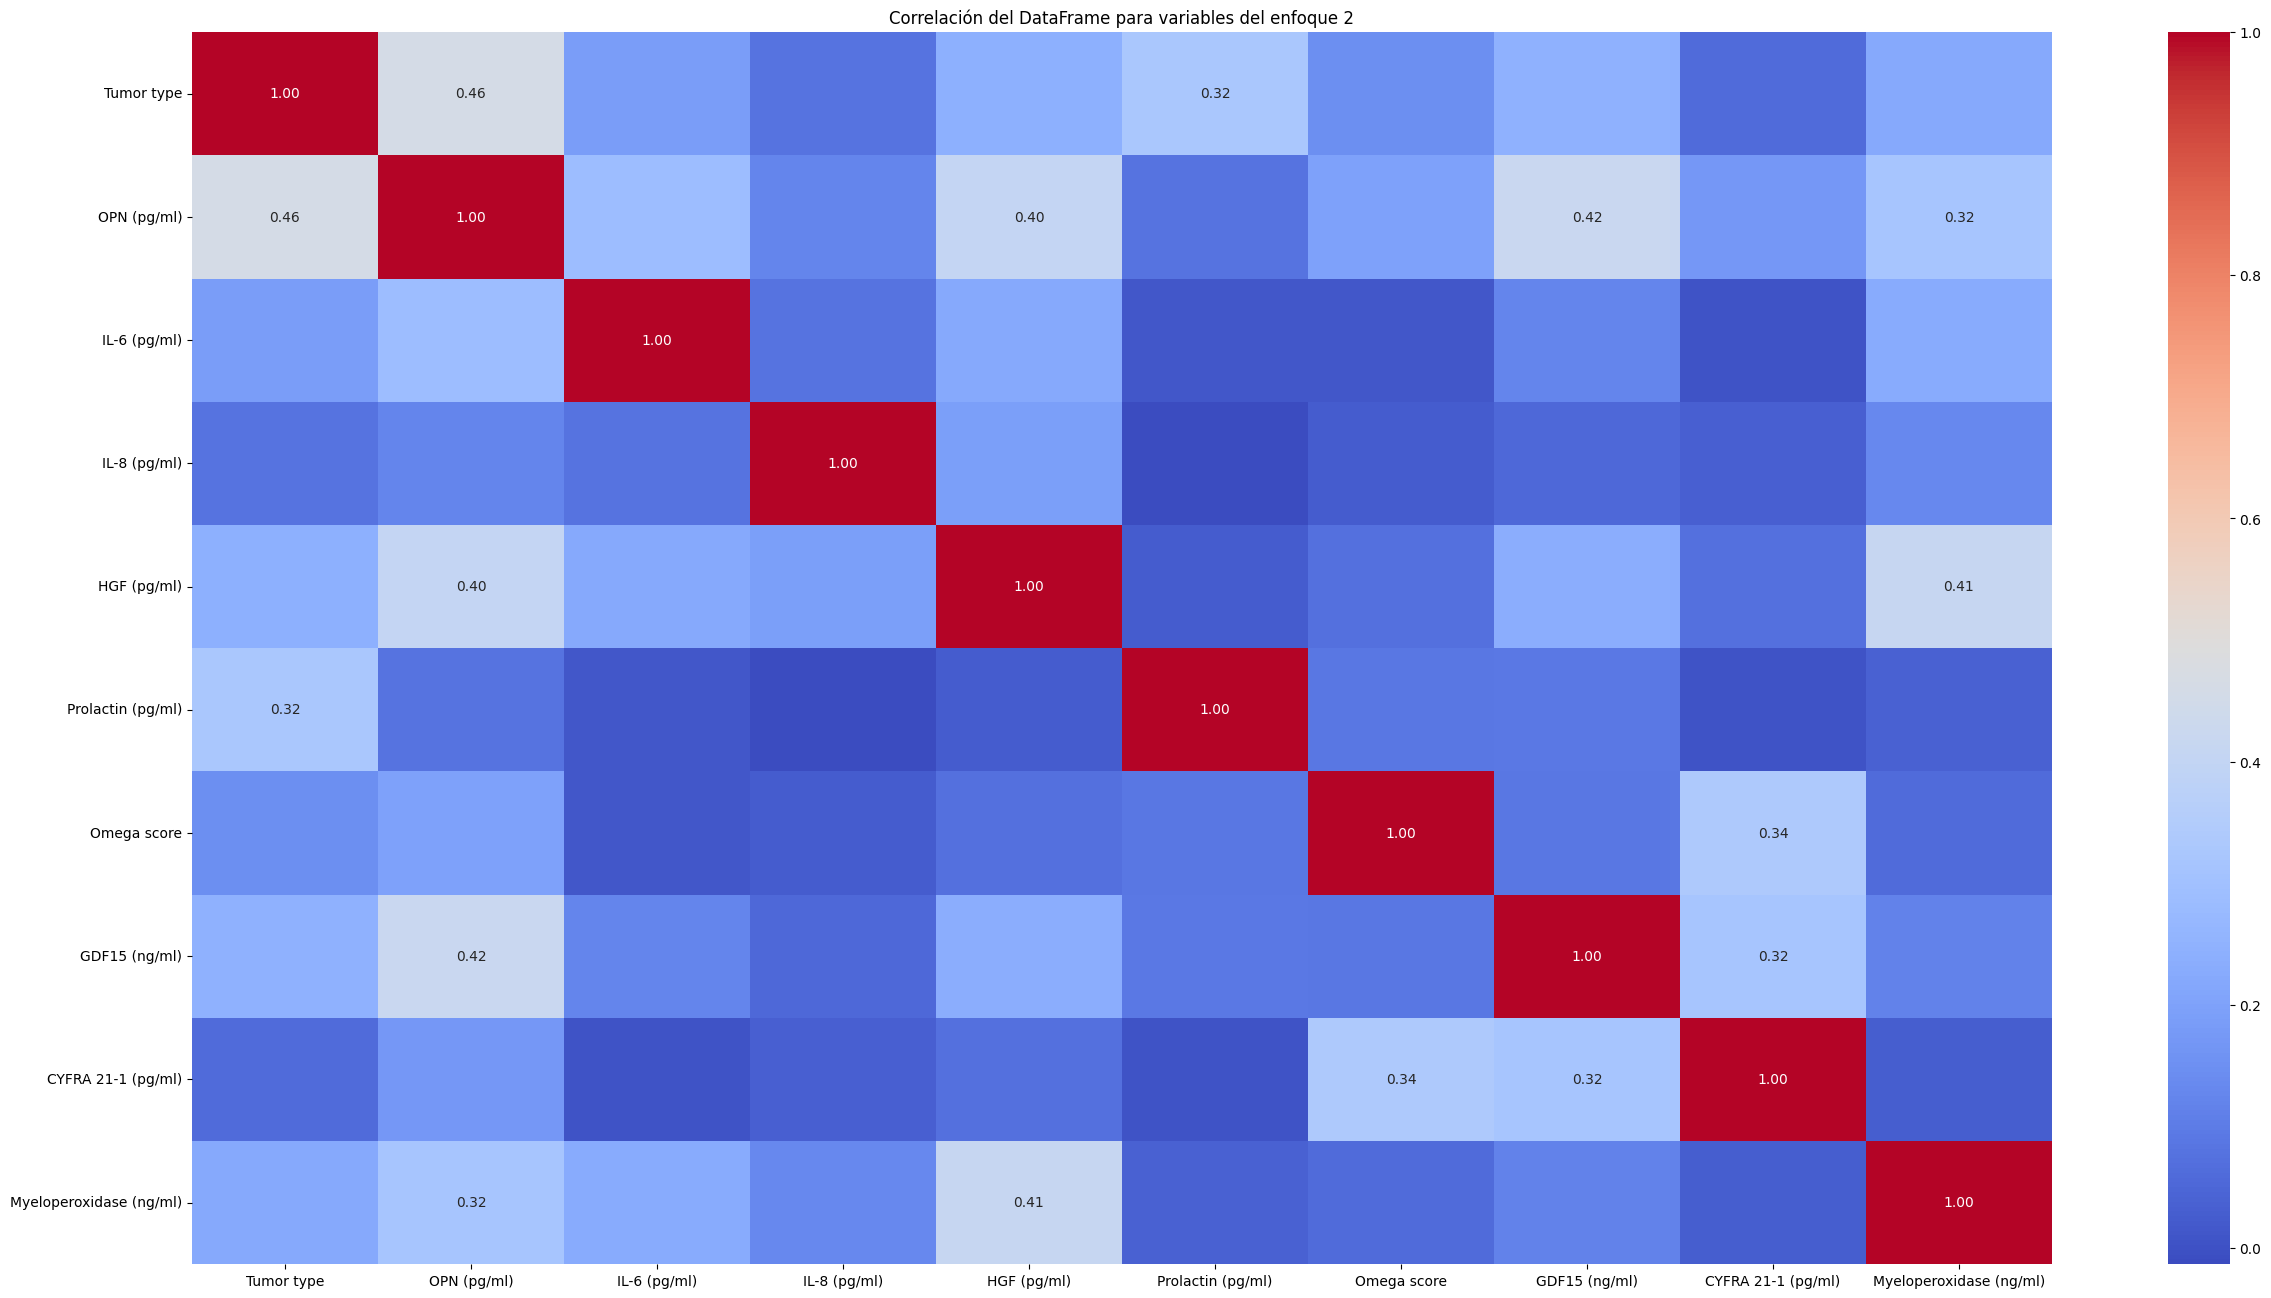

In [18]:
from feature_engine.discretisation import DecisionTreeDiscretiser
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Proposiciones/Deteccion Cancer/Datos/{nombreArchivo}.xlsx'

# Se procede a hacer una carga de los datos. 
df_original= pd.read_excel(url_datos, sheet_name='Table S6')

# Crear una copia del DataFrame original para realizar los cambios
df6 = df_original.copy()

# Recorrer las columnas del DataFrame para eliminar las cadenas de texto : ['*', '**']
for columna in df6.columns:
    if df6[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in ['*', '**']:
            df6[columna] = df6[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

df_prep = df6.apply(convert_to_numeric)

show_correlation(df_prep, title='Correlación del DataFrame para el conjunto de datos total')

# Relleno de nulos de la variable "AJCC Stage"
df_prep["AJCC Stage"] = df_prep["AJCC Stage"].fillna("0")

# Calcular la media solo para las columnas numéricas
numeric_columns = df_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df = df_prep.copy()  # Copiar el DataFrame preprocesado para evitar modificarlo
for col in mean_values.index:
    df[col].fillna(mean_values[col], inplace=True)


# Binarización "Tumor Type" 0 -> NO CANCER; 1 -> SI CANCER + 'CancerSEEK Test Result'
df['Tumor type'] = df['Tumor type'].apply(lambda x: 0 if str(x).strip().lower() == "normal" else 1).astype(int)
#df['CancerSEEK Test Result'] = df['CancerSEEK Test Result'].apply(lambda x: 0 if str(x).strip().lower() == "negative" else 1).astype(int)

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['Tumor type','CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']

## --- CHECKPOINT ----- Datos limpios

# Columna objetivo
Y_column = df['Tumor type'].copy()
# Reducción del dataFrame
df_reduced = df[columnas_a_conservar].copy()
#Copia del dataFrame entero
df_full = df.copy()

''' INICIO - Verificacion del information gain'''
# Information Gain inicial
df_discretizado = discretizar_df_arboles_1(df_reduced.drop(columns=['Tumor type']))
df_reduced_discretizado_escalated = escalado_dataFrame(df_discretizado)
calcular_ganancia_informacion(df_reduced_discretizado_escalated, Y_column, imprimir = "NO")

# Information Gain usando arboles de decision (acorde a : "..the cancer antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the purity and accuracy measurements..")
df_discretizado_full = discretizar_df_arboles(df_full, imprimir ="NO") # Columnas de este segundo enfoque guardadas en columnas_segundo_enfoque
df_discretizado_reduced = discretizar_df_arboles(df_reduced,imprimir ="NO")

''' FIN - Verificacion del information gain'''

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE SUPERVISADO
tabla_results_df = pd.DataFrame(columns=['Model', 'Approach', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Adjusted Rand Index', 'Mean Squared Error', 'R-squared','AUC-ROC', 'TN', 'FP', 'FN', 'TP', 'Global Score'])

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE NO SUPERVISADO
tabla_results_NS_df = pd.DataFrame(columns=['Model', 'Set', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Global Score'])

## --- CHECKPOINT ----- Datos discretizados + Information gain
# TODO Una vez hechos los modelos, habrá que estudiar cómo influye el usar esta serie de variables en la predicción
columnas_segundo_enfoque = ['Tumor type','OPN (pg/ml)','IL-6 (pg/ml)','IL-8 (pg/ml)','HGF (pg/ml)','Prolactin (pg/ml)','Omega score','GDF15 (ng/ml)','CYFRA 21-1 (pg/ml)','Myeloperoxidase (ng/ml)']
df_reduced_segundo_enfoque = df[columnas_segundo_enfoque].copy()

''' Valores para X
1. df : entero, limpio, sin normalizar ni discretizar
2. df_reduced : reducido, limpio, sin normalizar ni discretizar
3. df_reduced_discretizado_escalated --> Acorde a la Tabla 1
4. df_discretizado_full.drop(columns=['Tumor type']) --> Acorde a la Figura S3 (usando todas las variables) discretizado con arbol de decisión
5. df_discretizado_reduced.drop(columns=['Tumor type']) --> Acorde a la Figura S3; discretizado con arbol de decisión
'''
show_correlation(df_reduced, title='Correlación del DataFrame para variables del enfoque 1')

''' Enfoque 1 '''
y = df_reduced['Tumor type']
X = df_reduced.drop(columns='Tumor type')

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Create the preprocessor pipeline with DecisionTreeDiscretizer
# Crear el discretizado
numeric_pipeline = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('discretize',
        DecisionTreeDiscretiser(cv=10, scoring='accuracy', variables=numeric_cols, regression=False))
])

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train, y_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

df_red_prep = preprocessor.transform(df_reduced)  

X_prep = np.vstack((X_train_prep, X_val_prep, X_test_prep))

show_correlation(df_reduced_segundo_enfoque, title='Correlación del DataFrame para variables del enfoque 2')
''' Enfoque 2 '''
y = df_reduced_segundo_enfoque['Tumor type']
X_2 = df_reduced_segundo_enfoque.drop(columns='Tumor type')

X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = split_data(X_2, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols_2 = X_train_2.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols_2 = X_train_2.select_dtypes(include=['object', 'category']).columns.to_list()

numeric_pipeline_2 = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('discretize',
        DecisionTreeDiscretiser(cv=10, scoring='accuracy', variables=numeric_cols_2, regression=False))
])

# Crear el preprocesador
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_2, numeric_cols_2),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_2)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

X_train_prep_2 = preprocessor_2.fit_transform(X_train_2, y_train_2)
X_val_prep_2 = preprocessor_2.transform(X_val_2)
X_test_prep_2  = preprocessor_2.transform(X_test_2)

X_prep_2 = np.vstack((X_train_prep_2, X_val_prep_2, X_test_prep_2))


# Parte 1 - Detección de cáncer

## Aprendizaje supervisado

### Regresión lineal

In [14]:
# Crear una instancia del modelo de regresión lineal
model_LR = LinearRegression()
model_name = "Regresion Lineal"

# Definir un umbral
umbral = 0.5

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LR.fit(X_train_prep, y_train)

#print("Fase de ENTRENAMIENTO estadísticas :")
#mostrar_score(X_train_prep, y_train, model_LR)
mostrar_estadisticas_guardar_tabla(y_train, np.where(model_LR.predict(X_train_prep) > umbral, 1, 0), "Training", model_name, enfoque="1", print_roc = "NO")

# Predecir en el conjunto de validación
y_pred = model_LR.predict(X_val_prep)

# Binarizar las predicciones
y_pred_bin = np.where(y_pred > umbral, 1, 0)

y_test_pred = model_LR.predict(X_test_prep)
y_test_pred_bin = np.where(y_test_pred > umbral, 1, 0)

mostrar_estadisticas_guardar_tabla(y_val, y_pred_bin, "Validation",  model_name, enfoque = "1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_bin, "Test", model_name, enfoque = "1", print_roc = "NO")

''' Enfoque 2 ''' 
model_LR_2 = LinearRegression()


# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LR_2.fit(X_train_prep_2, y_train_2)

#print("Fase de ENTRENAMIENTO estadísticas :")
#mostrar_score(X_train_prep, y_train, model_LR)
mostrar_estadisticas_guardar_tabla(y_train_2, np.where(model_LR_2.predict(X_train_prep_2) > umbral, 1, 0), "Training", model_name, enfoque="2", print_roc = "NO")

# Predecir en el conjunto de validación
y_val_pred_2 = model_LR_2.predict(X_val_prep_2)

# Binarizar las predicciones
y_val_pred_bin_2 = np.where(y_val_pred_2 > umbral, 1, 0)

y_test_pred_2 = model_LR_2.predict(X_test_prep_2)
y_test_pred_bin_2 = np.where(y_test_pred_2 > umbral, 1, 0)

mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_bin_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_bin_2, "Test", model_name, enfoque="2", print_roc = "NO")


dump(model_LR, 'Modelos supervisados entrenados/regresionLineal_e1_1.joblib')
dump(model_LR_2, 'Modelos supervisados entrenados/regresionLineal_e2_1.joblib')


Metrics for Training set :
 - Accuracy: 0.8981
 - Precision: 0.8980
 - Recall: 0.8981
 - F1-Score: 0.8979
 - Adjusted Rand Index: 0.6334
 - Mean Squared Error: 0.1019
 - R-squared: 0.5853
 - Área bajo la curva : 0.895
 - Confusion Matrix: 
[[411  63]
 [ 48 567]]
 - Global Score : 86.28

Metrics for Validation set :
 - Accuracy: 0.9093
 - Precision: 0.9094
 - Recall: 0.9093
 - F1-Score: 0.9094
 - Adjusted Rand Index: 0.6693
 - Mean Squared Error: 0.0907
 - R-squared: 0.6352
 - Área bajo la curva : 0.909
 - Confusion Matrix: 
[[152  16]
 [ 17 179]]
 - Global Score : 88.03

Metrics for Test set :
 - Accuracy: 0.9121
 - Precision: 0.9121
 - Recall: 0.9121
 - F1-Score: 0.9121
 - Adjusted Rand Index: 0.6784
 - Mean Squared Error: 0.0879
 - R-squared: 0.6468
 - Área bajo la curva : 0.911
 - Confusion Matrix: 
[[153  17]
 [ 15 179]]
 - Global Score : 88.3

Metrics for Training set :
 - Accuracy: 0.8007
 - Precision: 0.8236
 - Recall: 0.8007
 - F1-Score: 0.8004
 - Adjusted Rand Index: 0.3611
 -

C:\Users\danie\AppData\Local\Temp\ipykernel_7664\2464742697.py:286: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)


['Modelos supervisados entrenados/regresionLineal_e2_1.joblib']

In [19]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from joblib import dump

# Definir un umbral
umbral = 0.5

# Modelos y parámetros de regularización
ridge = Ridge()
lasso = Lasso()

ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}

best_ridge = grid_search_cv(ridge, ridge_params, X_train_prep, y_train)
best_lasso = grid_search_cv(lasso, lasso_params, X_train_prep, y_train)

print(f"Mejor Ridge: {best_ridge}")
print(f"Mejor Lasso: {best_lasso}")

# Entrenar y evaluar el modelo Ridge
best_ridge.fit(X_train_prep, y_train)
mostrar_estadisticas_guardar_tabla(y_train, np.where(best_ridge.predict(X_train_prep) > umbral, 1, 0), "Training", "Ridge", enfoque="1", print_roc = "NO")

y_pred_ridge = best_ridge.predict(X_val_prep)
y_pred_bin_ridge = np.where(y_pred_ridge > umbral, 1, 0)
mostrar_estadisticas_guardar_tabla(y_val, y_pred_bin_ridge, "Validation", "Ridge", enfoque="1", print_roc = "NO")

# Entrenar y evaluar el modelo Lasso
best_lasso.fit(X_train_prep, y_train)
mostrar_estadisticas_guardar_tabla(y_train, np.where(best_lasso.predict(X_train_prep) > umbral, 1, 0), "Training", "Lasso", enfoque="1", print_roc = "NO")

y_pred_lasso = best_lasso.predict(X_val_prep)
y_pred_bin_lasso = np.where(y_pred_lasso > umbral, 1, 0)
mostrar_estadisticas_guardar_tabla(y_val, y_pred_bin_lasso, "Validation", "Lasso", enfoque="1", print_roc = "NO")

dump(best_ridge, 'Modelos supervisados entrenados/ridge_e1_1.joblib')
dump(best_lasso, 'Modelos supervisados entrenados/lasso_e1_1.joblib')

# Realizar GridSearchCV para el enfoque 2
best_ridge_2 = grid_search_cv(ridge, ridge_params, X_train_prep_2, y_train_2)
best_lasso_2 = grid_search_cv(lasso, lasso_params, X_train_prep_2, y_train_2)

print(f"Mejor Ridge Enfoque 2: {best_ridge_2}")
print(f"Mejor Lasso Enfoque 2: {best_lasso_2}")

# Entrenar y evaluar el modelo Ridge enfoque 2
best_ridge_2.fit(X_train_prep_2, y_train_2)
mostrar_estadisticas_guardar_tabla(y_train_2, np.where(best_ridge_2.predict(X_train_prep_2) > umbral, 1, 0), "Training", "Ridge", enfoque="2", print_roc = "NO")

y_val_pred_ridge_2 = best_ridge_2.predict(X_val_prep_2)
y_val_pred_bin_ridge_2 = np.where(y_val_pred_ridge_2 > umbral, 1, 0)
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_bin_ridge_2, "Validation", "Ridge", enfoque="2", print_roc = "NO")

# Entrenar y evaluar el modelo Lasso enfoque 2
best_lasso_2.fit(X_train_prep_2, y_train_2)
mostrar_estadisticas_guardar_tabla(y_train_2, np.where(best_lasso_2.predict(X_train_prep_2) > umbral, 1, 0), "Training", "Lasso", enfoque="2", print_roc = "NO")

y_val_pred_lasso_2 = best_lasso_2.predict(X_val_prep_2)
y_val_pred_bin_lasso_2 = np.where(y_val_pred_lasso_2 > umbral, 1, 0)
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_bin_lasso_2, "Validation", "Lasso", enfoque="2", print_roc = "NO")

# Guardar los modelos entrenados
dump(best_ridge_2, 'Modelos supervisados entrenados/ridge_e2_1.joblib')
dump(best_lasso_2, 'Modelos supervisados entrenados/lasso_e2_1.joblib')

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self.

Mejor Ridge: Ridge(alpha=0.1)
Mejor Lasso: Lasso(alpha=0.1)
Metrics for Training set :
 - Accuracy: 0.9247
 - Precision: 0.9247
 - Recall: 0.9247
 - F1-Score: 0.9247
 - Adjusted Rand Index: 0.7212
 - Mean Squared Error: 0.0753
 - R-squared: 0.6954
 - Área bajo la curva : 0.924
 - Confusion Matrix: 
[[447  40]
 [ 42 560]]
 - Global Score : 89.97

Metrics for Validation set :
 - Accuracy: 0.8819
 - Precision: 0.8835
 - Recall: 0.8819
 - F1-Score: 0.8821
 - Adjusted Rand Index: 0.5821
 - Mean Squared Error: 0.1181
 - R-squared: 0.5211
 - Área bajo la curva : 0.883
 - Confusion Matrix: 
[[144  17]
 [ 26 177]]
 - Global Score : 84.75

Metrics for Training set :
 - Accuracy: 0.5528
 - Precision: 0.3056
 - Recall: 0.5528
 - F1-Score: 0.3936
 - Adjusted Rand Index: 0.0000
 - Mean Squared Error: 0.4472
 - R-squared: -0.8090
 - Área bajo la curva : 0.500
 - Confusion Matrix: 
[[  0 487]
 [  0 602]]
 - Global Score : 36.43

Metrics for Validation set :
 - Accuracy: 0.5577
 - Precision: 0.3110
 - 

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self.

['Modelos supervisados entrenados/lasso_e2_1.joblib']

### Regresión logística

In [20]:
from sklearn.linear_model import LogisticRegression
model_name = "Regresión Logística"
print(model_name)
# Crear una instancia del modelo de regresión logística
model_LogR = LogisticRegression()

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LogR.fit(X_train_prep, y_train)

y_train_pred = model_LogR.predict(X_train_prep)
y_val_pred = model_LogR.predict(X_val_prep)
y_test_pred = model_LogR.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 
model_LogR_2 = LogisticRegression()

model_LogR_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_LogR_2.predict(X_train_prep_2)
y_val_pred_2 = model_LogR_2.predict(X_val_prep_2)
y_test_pred_2 = model_LogR_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(model_LogR, 'Modelos supervisados entrenados/regresionLogistica_e1_1.joblib')
dump(model_LogR_2, 'Modelos supervisados entrenados/regresionLogistica_e2_1.joblib')

Regresión Logística
Metrics for Training set :
 - Accuracy: 0.9284
 - Precision: 0.9284
 - Recall: 0.9284
 - F1-Score: 0.9284
 - Adjusted Rand Index: 0.7337
 - Mean Squared Error: 0.0716
 - R-squared: 0.7103
 - Área bajo la curva : 0.928
 - Confusion Matrix: 
[[449  38]
 [ 40 562]]
 - Global Score : 90.45

Metrics for Validation set :
 - Accuracy: 0.8901
 - Precision: 0.8910
 - Recall: 0.8901
 - F1-Score: 0.8903
 - Adjusted Rand Index: 0.6076
 - Mean Squared Error: 0.1099
 - R-squared: 0.5545
 - Área bajo la curva : 0.891
 - Confusion Matrix: 
[[144  17]
 [ 23 180]]
 - Global Score : 85.68

Metrics for Test set :
 - Accuracy: 0.8736
 - Precision: 0.8738
 - Recall: 0.8736
 - F1-Score: 0.8737
 - Adjusted Rand Index: 0.5572
 - Mean Squared Error: 0.1264
 - R-squared: 0.4895
 - Área bajo la curva : 0.873
 - Confusion Matrix: 
[[142  22]
 [ 24 176]]
 - Global Score : 83.47

Metrics for Training set :
 - Accuracy: 0.9578
 - Precision: 0.9578
 - Recall: 0.9578
 - F1-Score: 0.9578
 - Adjusted 

['Modelos supervisados entrenados/regresionLogistica_e2_1.joblib']

In [21]:
# Creación del modelo utilizando técnicas de reducción de sobreajuste mediante CV=10 y técnicas de regularizacióm cómo lasso (l1) y ridge (l2)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import joblib

# Definir un umbral
umbral = 0.5
model_name = "Regresión Logística"
print(model_name)

# Parámetros de regularización
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0, 100.0],
    'solver': ['liblinear']  # 'liblinear' soporta L1 y L2
}

# Realizar GridSearchCV para el primer enfoque
best_log_reg = grid_search_cv(LogisticRegression(), log_reg_params, X_train_prep, y_train)
print(f"Mejor Regresión Logística: {best_log_reg}")

# Entrenar y evaluar el modelo de Regresión Logística
best_log_reg.fit(X_train_prep, y_train)
y_train_pred = best_log_reg.predict(X_train_prep)
y_val_pred = best_log_reg.predict(X_val_prep)
y_test_pred = best_log_reg.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc="NO")

# Guardar el modelo entrenado
joblib.dump(best_log_reg, 'Modelos supervisados entrenados/regresionLogistica_e1_2.joblib')

# Realizar GridSearchCV para el segundo enfoque
best_log_reg_2 = grid_search_cv(LogisticRegression(), log_reg_params, X_train_prep_2, y_train_2)
print(f"Mejor Regresión Logística Enfoque 2: {best_log_reg_2}")

# Entrenar y evaluar el modelo de Regresión Logística enfoque 2
best_log_reg_2.fit(X_train_prep_2, y_train_2)
y_train_pred_2 = best_log_reg_2.predict(X_train_prep_2)
y_val_pred_2 = best_log_reg_2.predict(X_val_prep_2)
y_test_pred_2 = best_log_reg_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc="NO")

# Guardar el modelo entrenado
joblib.dump(best_log_reg_2, 'Modelos supervisados entrenados/regresionLogistica_e2_2.joblib')


Regresión Logística
Mejor Regresión Logística: LogisticRegression(C=100.0, penalty='l1', solver='liblinear')
Metrics for Training set :
 - Accuracy: 0.9320
 - Precision: 0.9320
 - Recall: 0.9320
 - F1-Score: 0.9320
 - Adjusted Rand Index: 0.7464
 - Mean Squared Error: 0.0680
 - R-squared: 0.7251
 - Área bajo la curva : 0.931
 - Confusion Matrix: 
[[450  37]
 [ 37 565]]
 - Global Score : 90.91

Metrics for Validation set :
 - Accuracy: 0.8846
 - Precision: 0.8851
 - Recall: 0.8846
 - F1-Score: 0.8847
 - Adjusted Rand Index: 0.5906
 - Mean Squared Error: 0.1154
 - R-squared: 0.5322
 - Área bajo la curva : 0.884
 - Confusion Matrix: 
[[142  19]
 [ 23 180]]
 - Global Score : 84.91

Metrics for Test set :
 - Accuracy: 0.8819
 - Precision: 0.8825
 - Recall: 0.8819
 - F1-Score: 0.8820
 - Adjusted Rand Index: 0.5821
 - Mean Squared Error: 0.1181
 - R-squared: 0.5228
 - Área bajo la curva : 0.882
 - Confusion Matrix: 
[[145  19]
 [ 24 176]]
 - Global Score : 84.62

Mejor Regresión Logística Enf

['Modelos supervisados entrenados/regresionLogistica_e2_2.joblib']

### Arbol de decisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model_name = "Árbol de Decisión"
print(model_name)
model_DT_leaf = DecisionTreeClassifier(random_state=42)

# Definir los parámetros a ajustar
params = {'max_leaf_nodes': range(2, 50)}  # Probando diferentes valores para max_leaf_nodes

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None,5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': range(2, 50)
}

# Realizar la búsqueda en rejilla con validación cruzada
grid_search = grid_search_2 = GridSearchCV(model_DT_leaf, param_grid, n_jobs=-1, cv=10)
grid_search.fit(X_train_prep, y_train)

# Mostrar los resultados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

model_DT = grid_search.best_estimator_

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_DT.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_DT, X_train_prep, y_train)

y_train_pred = model_DT.predict(X_train_prep)
y_val_pred = model_DT.predict(X_val_prep)
y_test_pred = model_DT.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(model_DT, 'Modelos supervisados entrenados/arbolesDecision_e1_1.joblib')


''' Enfoque 2 ''' 
grid_search_2.fit(X_train_prep_2, y_train_2)

model_DT_2 = grid_search_2.best_estimator_

model_DT_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_DT_2.predict(X_train_prep_2)
y_val_pred_2 = model_DT_2.predict(X_val_prep_2)
y_test_pred_2 = model_DT_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(model_DT_2, 'Modelos supervisados entrenados/arbolesDecision_e2_1.joblib')

In [22]:
# Creación del modelo utilizando técnicas de reducción de sobreajuste mediante CV=10 y técnicas de regularización mediante ajuste más fino de hiperparámetros max_depth, min_samples_split, min_samples_leaf, y max_leaf_nodes
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import joblib

model_name = "Árbol de Decisión"
print(model_name)
model_DT_leaf = DecisionTreeClassifier(random_state=42)

# Definir los parámetros a ajustar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None,0.05, 0.5, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': range(2, 50)
}

# Realizar la búsqueda en rejilla con validación cruzada
grid_search = GridSearchCV(model_DT_leaf, param_grid, n_jobs=-1, cv=10)
grid_search.fit(X_train_prep, y_train)

# Mostrar los resultados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

model_DT = grid_search.best_estimator_

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_DT.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_DT, X_train_prep, y_train)

y_train_pred = model_DT.predict(X_train_prep)
y_val_pred = model_DT.predict(X_val_prep)
y_test_pred = model_DT.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc="NO")

joblib.dump(model_DT, 'Modelos supervisados entrenados/arbolesDecision_e1_2.joblib')

''' Enfoque 2 '''
grid_search.fit(X_train_prep_2, y_train_2)

model_DT_2 = grid_search.best_estimator_

model_DT_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_DT_2.predict(X_train_prep_2)
y_val_pred_2 = model_DT_2.predict(X_val_prep_2)
y_test_pred_2 = model_DT_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc="NO")

joblib.dump(model_DT_2, 'Modelos supervisados entrenados/arbolesDecision_e2_2.joblib')


Árbol de Decisión


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
34560 fits failed out of a total of 120960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17280 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklea

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 45, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Cross validation : 
Métricas validación cruzada: [-0.34534918 -0.28734789 -0.23461857 -0.33864273 -0.30358837]
Média métricas de validación cruzada: -0.301909346240408

Metrics for Training set :
 - Accuracy: 0.9541
 - Precision: 0.9543
 - Recall: 0.9541
 - F1-Score: 0.9541
 - Adjusted Rand Index: 0.8246
 - Mean Squared Error: 0.0459
 - R-squared: 0.8143
 - Área bajo la curva : 0.955
 - Confusion Matrix: 
[[467  20]
 [ 30 572]]
 - Global Score : 93.94

Metrics for Validation set :
 - Accuracy: 0.8599
 - Precision: 0.8606
 - Recall: 0.8599
 - F1-Score: 0.8601
 - Adjusted Rand Index: 0.5167
 - Mean Squared Error: 0.1401
 - R-squared: 0.4320
 - Área bajo la curva : 0.860
 - Confusion Matrix: 
[[138  23]
 [ 28 175]]
 - Global Score : 81.82

Metrics for Test set :
 - Accuracy: 0.8681
 - Precision: 0.8683
 - Recall: 0.8681
 - F1-Score:

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
34560 fits failed out of a total of 120960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17280 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklea

Metrics for Training set :
 - Accuracy: 0.9807
 - Precision: 0.9808
 - Recall: 0.9807
 - F1-Score: 0.9807
 - Adjusted Rand Index: 0.9243
 - Mean Squared Error: 0.0193
 - R-squared: 0.9220
 - Área bajo la curva : 0.980
 - Confusion Matrix: 
[[473  14]
 [  7 595]]
 - Global Score : 97.3

Metrics for Validation set :
 - Accuracy: 0.9423
 - Precision: 0.9437
 - Recall: 0.9423
 - F1-Score: 0.9424
 - Adjusted Rand Index: 0.7819
 - Mean Squared Error: 0.0577
 - R-squared: 0.7672
 - Área bajo la curva : 0.944
 - Confusion Matrix: 
[[159   6]
 [ 15 184]]
 - Global Score : 92.59

Metrics for Test set :
 - Accuracy: 0.9505
 - Precision: 0.9505
 - Recall: 0.9505
 - F1-Score: 0.9505
 - Adjusted Rand Index: 0.8114
 - Mean Squared Error: 0.0495
 - R-squared: 0.7993
 - Área bajo la curva : 0.949
 - Confusion Matrix: 
[[150  10]
 [  8 196]]
 - Global Score : 93.26



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [0.88608563 0.8438668  0.88608563 ... 0.94124193 0.92471967 0.93570336]
  warnings.warn(


['Modelos supervisados entrenados/arbolesDecision_e2_2.joblib']

### Random forest

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
model_name = "Random Forest"
print(model_name)
RF = RandomForestClassifier()

rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  
    "max_features": [None, "sqrt", "log2"], 
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4], 
    "bootstrap": [True, False]  
}
'''
rf_params = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
'''
random_search = random_search_2 = RandomizedSearchCV(estimator=RF,
                                   param_distributions=rf_params,
                                   n_iter=100,  
                                   cv=5,  
                                   verbose=0, 
                                   random_state=42,
                                   n_jobs=-1) 

# random_search.fit(X_train_prep, y_train)

# print("Mejores parámetros encontrados:", random_search.best_params_)
# {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

# model_RF = random_search.best_estimator_
params = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
model_RF = RandomForestClassifier(**params)
model_RF.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_RF, X_train_prep, y_train)

y_train_pred = model_RF.predict(X_train_prep)
y_val_pred = model_RF.predict(X_val_prep)
y_test_pred = model_RF.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(model_RF, 'Modelos supervisados entrenados/randomForest_e1_1.joblib')

''' Enfoque 2 ''' 
# random_search_2.fit(X_train_prep_2, y_train_2)

# print("Mejores parámetros encontrados:", random_search.best_params_)
# {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

# model_RF_2 = random_search_2.best_estimator_
params_2 = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

model_RF_2 = RandomForestClassifier(**params_2)
model_RF_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = model_RF_2.predict(X_train_prep_2)
y_val_pred_2 = model_RF_2.predict(X_val_prep_2)
y_test_pred_2 = model_RF_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(model_RF_2, 'Modelos supervisados entrenados/randomForest_e2_1.joblib')


Random Forest
Cross validation : 
Métricas validación cruzada: [-0.31767504 -0.24419875 -0.26231153 -0.35192785 -0.26291524]
Média métricas de validación cruzada: -0.2878056815322991



NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [44]:
# Creación del modelo utilizando técnicas de reducción de sobreajuste mediante CV=10 y técnicas de regularización mediante ajuste más fino de hiperparámetros max_depth, min_samples_split, min_samples_leaf, y max_leaf_nodes
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
model_name = "Random Forest"
print(model_name)
RF = RandomForestClassifier()

rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  
    "max_features": [None, "sqrt", "log2"], 
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4], 
    "bootstrap": [True, False]  
}
'''
rf_params = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
'''
random_search = random_search_2 = RandomizedSearchCV(estimator=RF,
                                   param_distributions=rf_params,
                                   n_iter=100,  
                                   cv=10,  
                                   verbose=0, 
                                   random_state=42,
                                   n_jobs=-1) 

random_search.fit(X_train_prep, y_train)

print("Mejores parámetros encontrados:", random_search.best_params_)
# {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

# model_RF = random_search.best_estimator_
# params = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
# model_RF = RandomForestClassifier(**params)
# model_RF.fit(X_train_prep, y_train)

y_train_pred = random_search.predict(X_train_prep)
y_val_pred = random_search.predict(X_val_prep)
y_test_pred = random_search.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(random_search, 'Modelos supervisados entrenados/randomForest_e1_2.joblib')

''' Enfoque 2 ''' 
random_search_2.fit(X_train_prep_2, y_train_2)

print("Mejores parámetros encontrados:", random_search.best_params_)
# {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

# model_RF_2 = random_search_2.best_estimator_
# params_2 = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

#model_RF_2 = RandomForestClassifier(**params_2)
#model_RF_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = random_search_2.predict(X_train_prep_2)
y_val_pred_2 = random_search_2.predict(X_val_prep_2)
y_test_pred_2 = random_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(random_search_2, 'Modelos supervisados entrenados/randomForest_e2_2.joblib')


Random Forest
Mejores parámetros encontrados: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Metrics for Training set :
 - Accuracy: 0.9486
 - Precision: 0.9486
 - Recall: 0.9486
 - F1-Score: 0.9486
 - Adjusted Rand Index: 0.8047
 - Mean Squared Error: 0.0514
 - R-squared: 0.7920
 - Área bajo la curva : 0.948
 - Confusion Matrix: 
[[457  30]
 [ 26 576]]
 - Global Score : 93.04

Metrics for Validation set :
 - Accuracy: 0.8929
 - Precision: 0.8929
 - Recall: 0.8929
 - F1-Score: 0.8927
 - Adjusted Rand Index: 0.6163
 - Mean Squared Error: 0.1071
 - R-squared: 0.5677
 - Área bajo la curva : 0.891
 - Confusion Matrix: 
[[143  22]
 [ 17 182]]
 - Global Score : 85.68

Metrics for Test set :
 - Accuracy: 0.8956
 - Precision: 0.8958
 - Recall: 0.8956
 - F1-Score: 0.8953
 - Adjusted Rand Index: 0.6249
 - Mean Squared Error: 0.1044
 - R-squared: 0.5762
 - Área bajo la curva : 0.891
 - Confusion Matrix: 
[[137  23]


['Modelos supervisados entrenados/randomForest_e2_2.joblib']

### KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
model_name = "KNN"
print(model_name)
# Parámetros de búsqueda para KNN
'''
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
'''

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50]
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 3,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 30,
    'metric': 'hamming',
    'n_neighbors': 7,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 30,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}

#grid_search_knn = grid_search_knn_2 = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn = KNeighborsClassifier(**best_params_knn)
grid_search_knn_2 = KNeighborsClassifier(**best_params_knn_2)

grid_search_knn.fit(X_train_prep, y_train)

#print("Best parameters for KNN: ", grid_search_knn.best_params_)

y_train_pred = grid_search_knn.predict(X_train_prep)
y_val_pred = grid_search_knn.predict(X_val_prep)
y_test_pred = grid_search_knn.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_knn, 'Modelos supervisados entrenados/knn_e1_1.joblib')

''' Enfoque 2 '''
grid_search_knn_2.fit(X_train_prep_2, y_train_2)

#print("Best parameters for KNN: ", grid_search_knn_2.best_params_) 

grid_search_knn_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_knn_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_knn_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_knn_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")


dump(grid_search_knn_2, 'Modelos supervisados entrenados/knn_e2_1.joblib')

KNN
Metrics for Training set :
 - Accuracy: 0.9128
 - Precision: 0.9158
 - Recall: 0.9128
 - F1-Score: 0.9130
 - Adjusted Rand Index: 0.6812
 - Mean Squared Error: 0.0872
 - R-squared: 0.6471
 - Área bajo la curva : 0.916
 - Confusion Matrix: 
[[460  27]
 [ 68 534]]
 - Global Score : 88.91

Metrics for Validation set :
 - Accuracy: 0.8626
 - Precision: 0.8684
 - Recall: 0.8626
 - F1-Score: 0.8629
 - Adjusted Rand Index: 0.5247
 - Mean Squared Error: 0.1374
 - R-squared: 0.4457
 - Área bajo la curva : 0.867
 - Confusion Matrix: 
[[150  15]
 [ 35 164]]
 - Global Score : 82.77

Metrics for Test set :
 - Accuracy: 0.8214
 - Precision: 0.8305
 - Recall: 0.8214
 - F1-Score: 0.8221
 - Adjusted Rand Index: 0.4117
 - Mean Squared Error: 0.1786
 - R-squared: 0.2751
 - Área bajo la curva : 0.827
 - Confusion Matrix: 
[[140  20]
 [ 45 159]]
 - Global Score : 77.85

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.00

['Modelos supervisados entrenados/knn_e2_1.joblib']

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
model_name = "KNN"
print(model_name)
# Parámetros de búsqueda para KNN
'''
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
'''

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50]
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 3,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 30,
    'metric': 'hamming',
    'n_neighbors': 7,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 30,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}
n_iter = 50
grid_search_knn = grid_search_knn_2 = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid_knn,
    n_iter=n_iter,
    cv=10,
    scoring='accuracy',
    random_state=42
)
#grid_search_knn = KNeighborsClassifier(**best_params_knn)
#grid_search_knn_2 = KNeighborsClassifier(**best_params_knn_2)

grid_search_knn.fit(X_train_prep, y_train)

print("Best parameters for KNN: ", grid_search_knn.best_params_)

y_train_pred = grid_search_knn.predict(X_train_prep)
y_val_pred = grid_search_knn.predict(X_val_prep)
y_test_pred = grid_search_knn.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_knn, 'Modelos supervisados entrenados/knn_e1_2.joblib')

''' Enfoque 2 '''
grid_search_knn_2.fit(X_train_prep_2, y_train_2)

print("Best parameters for KNN: ", grid_search_knn_2.best_params_) 

grid_search_knn_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_knn_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_knn_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_knn_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")


dump(grid_search_knn_2, 'Modelos supervisados entrenados/knn_e2_2.joblib')

KNN
Best parameters for KNN:  {'weights': 'distance', 'n_neighbors': 19, 'metric': 'manhattan', 'leaf_size': 50, 'algorithm': 'kd_tree'}
Metrics for Training set :
 - Accuracy: 0.9982
 - Precision: 0.9982
 - Recall: 0.9982
 - F1-Score: 0.9982
 - Adjusted Rand Index: 0.9927
 - Mean Squared Error: 0.0018
 - R-squared: 0.9926
 - Área bajo la curva : 0.998
 - Confusion Matrix: 
[[487   0]
 [  2 600]]
 - Global Score : 99.77

Metrics for Validation set :
 - Accuracy: 0.8984
 - Precision: 0.8998
 - Recall: 0.8984
 - F1-Score: 0.8985
 - Adjusted Rand Index: 0.6337
 - Mean Squared Error: 0.1016
 - R-squared: 0.5898
 - Área bajo la curva : 0.900
 - Confusion Matrix: 
[[151  14]
 [ 23 176]]
 - Global Score : 86.88

Metrics for Test set :
 - Accuracy: 0.8846
 - Precision: 0.8851
 - Recall: 0.8846
 - F1-Score: 0.8848
 - Adjusted Rand Index: 0.5906
 - Mean Squared Error: 0.1154
 - R-squared: 0.5316
 - Área bajo la curva : 0.884
 - Confusion Matrix: 
[[141  19]
 [ 23 181]]
 - Global Score : 84.9

Be

['Modelos supervisados entrenados/knn_e2_2.joblib']

### SVM

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model_name = "SVM"
print(model_name)
# Define la cuadrícula de parámetros para buscar
'''param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}'''
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],              # Grados para el kernel polinómico
    'coef0': [0.0, 0.1, 0.5, 1.0],     # Término independiente en los kernels polinómico y sigmoidal
    'shrinking': [True, False],       # Si se debe usar la heurística de encogimiento
    'decision_function_shape': ['ovo', 'ovr']  # Forma de la función de decisión para clasificación multiclase
}

# Crea un objeto GridSearchCV
# grid_search_svm = grid_search_svm_2 = GridSearchCV(SVC(), param_grid, refit=True)

best_param = {'C': 100, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}
# Ajusta el objeto GridSearchCV a los datos

grid_search_svm = SVC(**best_param)

grid_search_svm.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
# print("Mejores parámetros: ", grid_search_svm.best_params_)

y_train_pred = grid_search_svm.predict(X_train_prep)
y_val_pred = grid_search_svm.predict(X_val_prep)
y_test_pred = grid_search_svm.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_svm, 'Modelos supervisados entrenados/svm_e1_1.joblib')


''' Enfoque 2 ''' 
best_param_2 =  {'C': 100, 'coef0': 1.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'shrinking': True}
grid_search_svm_2 = SVC(**best_param_2)
grid_search_svm_2.fit(X_train_prep_2, y_train_2)

# print("Best parameters for KNN: ", grid_search_svm_2.best_params_) 

grid_search_svm_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_svm_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_svm_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_svm_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_svm_2, 'Modelos supervisados entrenados/svm_e2_1.joblib')

SVM
Metrics for Training set :
 - Accuracy: 0.9238
 - Precision: 0.9238
 - Recall: 0.9238
 - F1-Score: 0.9238
 - Adjusted Rand Index: 0.7181
 - Mean Squared Error: 0.0762
 - R-squared: 0.6917
 - Área bajo la curva : 0.923
 - Confusion Matrix: 
[[445  42]
 [ 41 561]]
 - Global Score : 89.82

Metrics for Validation set :
 - Accuracy: 0.8819
 - Precision: 0.8818
 - Recall: 0.8819
 - F1-Score: 0.8818
 - Adjusted Rand Index: 0.5821
 - Mean Squared Error: 0.1181
 - R-squared: 0.5233
 - Área bajo la curva : 0.881
 - Confusion Matrix: 
[[143  22]
 [ 21 178]]
 - Global Score : 84.42

Metrics for Test set :
 - Accuracy: 0.8736
 - Precision: 0.8735
 - Recall: 0.8736
 - F1-Score: 0.8733
 - Adjusted Rand Index: 0.5571
 - Mean Squared Error: 0.1264
 - R-squared: 0.4870
 - Área bajo la curva : 0.870
 - Confusion Matrix: 
[[134  26]
 [ 20 184]]
 - Global Score : 83.13

Metrics for Training set :
 - Accuracy: 0.9642
 - Precision: 0.9644
 - Recall: 0.9642
 - F1-Score: 0.9641
 - Adjusted Rand Index: 0.86

['Modelos supervisados entrenados/svm_e2_1.joblib']

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model_name = "SVM"
print(model_name)
# Define la cuadrícula de parámetros para buscar
'''param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}'''
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],              # Grados para el kernel polinómico
    'coef0': [0.0, 0.1, 0.5, 1.0],     # Término independiente en los kernels polinómico y sigmoidal
    'shrinking': [True, False],       # Si se debe usar la heurística de encogimiento
    'decision_function_shape': ['ovo', 'ovr']  # Forma de la función de decisión para clasificación multiclase
}

# Crea un objeto GridSearchCV
grid_search_svm = grid_search_svm_2 = GridSearchCV(SVC(), param_grid, refit=True)

#best_param = {'C': 100, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}
# Ajusta el objeto GridSearchCV a los datos

#grid_search_svm = SVC(**best_param)

grid_search_svm.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
print("Mejores parámetros: ", grid_search_svm.best_params_)

y_train_pred = grid_search_svm.predict(X_train_prep)
y_val_pred = grid_search_svm.predict(X_val_prep)
y_test_pred = grid_search_svm.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_svm, 'Modelos supervisados entrenados/svm_e1_2.joblib')


''' Enfoque 2 ''' 
# best_param_2 =  {'C': 100, 'coef0': 1.0, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'shrinking': True}
# grid_search_svm_2 = SVC(**best_param_2)
grid_search_svm_2.fit(X_train_prep_2, y_train_2)

print("Best parameters for KNN: ", grid_search_svm_2.best_params_) 

grid_search_svm_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_svm_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_svm_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_svm_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_svm_2, 'Modelos supervisados entrenados/svm_e2_2.joblib')

SVM
Mejores parámetros:  {'C': 100, 'coef0': 1.0, 'decision_function_shape': 'ovo', 'degree': 4, 'gamma': 0.1, 'kernel': 'poly', 'shrinking': True}
Metrics for Training set :
 - Accuracy: 0.9339
 - Precision: 0.9339
 - Recall: 0.9339
 - F1-Score: 0.9339
 - Adjusted Rand Index: 0.7528
 - Mean Squared Error: 0.0661
 - R-squared: 0.7326
 - Área bajo la curva : 0.933
 - Confusion Matrix: 
[[450  37]
 [ 35 567]]
 - Global Score : 91.13

Metrics for Validation set :
 - Accuracy: 0.8736
 - Precision: 0.8735
 - Recall: 0.8736
 - F1-Score: 0.8736
 - Adjusted Rand Index: 0.5571
 - Mean Squared Error: 0.1264
 - R-squared: 0.4901
 - Área bajo la curva : 0.872
 - Confusion Matrix: 
[[141  24]
 [ 22 177]]
 - Global Score : 83.34

Metrics for Test set :
 - Accuracy: 0.8626
 - Precision: 0.8629
 - Recall: 0.8626
 - F1-Score: 0.8627
 - Adjusted Rand Index: 0.5247
 - Mean Squared Error: 0.1374
 - R-squared: 0.4424
 - Área bajo la curva : 0.861
 - Confusion Matrix: 
[[136  24]
 [ 26 178]]
 - Global Score

['Modelos supervisados entrenados/svm_e2_2.joblib']

### Naive Bayes

#### Gaussiano

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

model_NB = GaussianNB()
model_name = "Naive Bayes - Gaussian"
print(model_name)

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search_nb = grid_search_nb_2 = GridSearchCV(model_NB, param_grid, cv=5, refit=True)

grid_search_nb.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_NB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
grid_search_nb.fit(X_train_prep, y_train)

y_train_pred = grid_search_nb.predict(X_train_prep)
y_val_pred = grid_search_nb.predict(X_val_prep)
y_test_pred = grid_search_nb.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_nb, 'Modelos supervisados entrenados/nb_gauss_e1_1.joblib')


''' Enfoque 2 ''' 

grid_search_nb_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_nb_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_nb_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_nb_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_nb_2, 'Modelos supervisados entrenados/nb_gauss_e2_1.joblib')


Naive Bayes - Gaussian
Cross validation : 
Métricas validación cruzada: [-0.51580524 -0.48367856 -0.44412578 -0.49770114 -0.46539216]
Média métricas de validación cruzada: -0.4813405758378038

Metrics for Training set :
 - Accuracy: 0.7668
 - Precision: 0.8266
 - Recall: 0.7668
 - F1-Score: 0.7620
 - Adjusted Rand Index: 0.2833
 - Mean Squared Error: 0.2332
 - R-squared: 0.0565
 - Área bajo la curva : 0.786
 - Confusion Matrix: 
[[471  16]
 [238 364]]
 - Global Score : 73.54

Metrics for Validation set :
 - Accuracy: 0.7830
 - Precision: 0.8457
 - Recall: 0.7830
 - F1-Score: 0.7779
 - Adjusted Rand Index: 0.3180
 - Mean Squared Error: 0.2170
 - R-squared: 0.1242
 - Área bajo la curva : 0.800
 - Confusion Matrix: 
[[163   2]
 [ 77 122]]
 - Global Score : 75.49

Metrics for Test set :
 - Accuracy: 0.7088
 - Precision: 0.7923
 - Recall: 0.7088
 - F1-Score: 0.6989
 - Adjusted Rand Index: 0.1707
 - Mean Squared Error: 0.2912
 - R-squared: -0.1821
 - Área bajo la curva : 0.735
 - Confusion M

['Modelos supervisados entrenados/nb_gauss_e2_1.joblib']

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

model_NB = GaussianNB()
model_name = "Naive Bayes - Gaussian"
print(model_name)

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search_nb = grid_search_nb_2 = GridSearchCV(model_NB, param_grid, cv=10, refit=True)

grid_search_nb.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_NB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
grid_search_nb.fit(X_train_prep, y_train)

y_train_pred = grid_search_nb.predict(X_train_prep)
y_val_pred = grid_search_nb.predict(X_val_prep)
y_test_pred = grid_search_nb.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_nb, 'Modelos supervisados entrenados/nb_gauss_e1_2.joblib')


''' Enfoque 2 ''' 

grid_search_nb_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_nb_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_nb_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_nb_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_nb_2, 'Modelos supervisados entrenados/nb_gauss_e2_2.joblib')


Naive Bayes - Gaussian
Cross validation : 
Métricas validación cruzada: [-0.3248147  -0.30289127 -0.24419875 -0.31767504 -0.27989465]
Média métricas de validación cruzada: -0.29389487939338704

Metrics for Training set :
 - Accuracy: 0.9164
 - Precision: 0.9165
 - Recall: 0.9164
 - F1-Score: 0.9164
 - Adjusted Rand Index: 0.6934
 - Mean Squared Error: 0.0836
 - R-squared: 0.6620
 - Área bajo la curva : 0.916
 - Confusion Matrix: 
[[442  45]
 [ 46 556]]
 - Global Score : 88.89

Metrics for Validation set :
 - Accuracy: 0.8819
 - Precision: 0.8818
 - Recall: 0.8819
 - F1-Score: 0.8818
 - Adjusted Rand Index: 0.5821
 - Mean Squared Error: 0.1181
 - R-squared: 0.5233
 - Área bajo la curva : 0.880
 - Confusion Matrix: 
[[142  23]
 [ 20 179]]
 - Global Score : 84.35

Metrics for Test set :
 - Accuracy: 0.8709
 - Precision: 0.8707
 - Recall: 0.8709
 - F1-Score: 0.8706
 - Adjusted Rand Index: 0.5489
 - Mean Squared Error: 0.1291
 - R-squared: 0.4759
 - Área bajo la curva : 0.867
 - Confusion M

['Modelos supervisados entrenados/nb_gauss_e2_2.joblib']

#### Bernouilli

In [15]:
from sklearn.naive_bayes import BernoulliNB

model_NBB = BernoulliNB()
model_name = "Naive Bayes - Bernoulli"
print(model_name)

param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
    'binarize': [None, 0.0, 0.1, 0.5, 1.0]
}
# Crea un objeto GridSearchCV
grid_search_nbb = grid_search_nbb_2 = GridSearchCV(model_NBB, param_grid, cv=5, refit=True)

# Ajusta el objeto GridSearchCV a los datos de entrenamiento preprocesados
grid_search_nbb.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_NBB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
grid_search_nbb.fit(X_train_prep, y_train)

y_train_pred = grid_search_nbb.predict(X_train_prep)
y_pred = grid_search_nbb.predict(X_val_prep)
y_test_pred = grid_search_nbb.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_nbb, 'Modelos supervisados entrenados/nb_bernouilli_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_nbb_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_nbb_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_nbb_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_nbb_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_nbb_2, 'Modelos supervisados entrenados/nb_bernouilli_e2_1.joblib')

Naive Bayes - Bernoulli


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\

Cross validation : 
Métricas validación cruzada: [-0.46923713 -0.47409982 -0.4175068  -0.51580524 -0.46539216]
Média métricas de validación cruzada: -0.4684082305729117



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\

Metrics for Training set :
 - Accuracy: 0.8246
 - Precision: 0.8304
 - Recall: 0.8246
 - F1-Score: 0.8251
 - Adjusted Rand Index: 0.4210
 - Mean Squared Error: 0.1754
 - R-squared: 0.2905
 - Área bajo la curva : 0.828
 - Confusion Matrix: 
[[421  66]
 [125 477]]
 - Global Score : 78.05

Metrics for Validation set :
 - Accuracy: 0.7830
 - Precision: 0.8457
 - Recall: 0.7830
 - F1-Score: 0.7779
 - Adjusted Rand Index: 0.3180
 - Mean Squared Error: 0.2170
 - R-squared: 0.1242
 - Área bajo la curva : 0.800
 - Confusion Matrix: 
[[163   2]
 [ 77 122]]
 - Global Score : 75.49

Metrics for Test set :
 - Accuracy: 0.8049
 - Precision: 0.8178
 - Recall: 0.8049
 - F1-Score: 0.8055
 - Adjusted Rand Index: 0.3702
 - Mean Squared Error: 0.1951
 - R-squared: 0.2082
 - Área bajo la curva : 0.812
 - Confusion Matrix: 
[[140  20]
 [ 51 153]]
 - Global Score : 76.1



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: invalid value encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\

Metrics for Training set :
 - Accuracy: 0.8118
 - Precision: 0.8186
 - Recall: 0.8118
 - F1-Score: 0.8123
 - Adjusted Rand Index: 0.3882
 - Mean Squared Error: 0.1882
 - R-squared: 0.2385
 - Área bajo la curva : 0.816
 - Confusion Matrix: 
[[417  70]
 [135 467]]
 - Global Score : 76.56

Metrics for Validation set :
 - Accuracy: 0.7802
 - Precision: 0.7954
 - Recall: 0.7802
 - F1-Score: 0.7801
 - Adjusted Rand Index: 0.3122
 - Mean Squared Error: 0.2198
 - R-squared: 0.1131
 - Área bajo la curva : 0.788
 - Confusion Matrix: 
[[143  22]
 [ 58 141]]
 - Global Score : 73.36

Metrics for Test set :
 - Accuracy: 0.7885
 - Precision: 0.8012
 - Recall: 0.7885
 - F1-Score: 0.7891
 - Adjusted Rand Index: 0.3310
 - Mean Squared Error: 0.2115
 - R-squared: 0.1413
 - Área bajo la curva : 0.796
 - Confusion Matrix: 
[[137  23]
 [ 54 150]]
 - Global Score : 74.11



['Modelos supervisados entrenados/nb_bernouilli_e2_1.joblib']

In [48]:
from sklearn.naive_bayes import BernoulliNB

model_NBB = BernoulliNB()
model_name = "Naive Bayes - Bernoulli"
print(model_name)

param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
    'binarize': [None, 0.0, 0.1, 0.5, 1.0]
}
# Crea un objeto GridSearchCV
grid_search_nbb = grid_search_nbb_2 = GridSearchCV(model_NBB, param_grid, cv=10, refit=True)

# Ajusta el objeto GridSearchCV a los datos de entrenamiento preprocesados
grid_search_nbb.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_NBB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
grid_search_nbb.fit(X_train_prep, y_train)

y_train_pred = grid_search_nbb.predict(X_train_prep)
y_pred = grid_search_nbb.predict(X_val_prep)
y_test_pred = grid_search_nbb.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search_nbb, 'Modelos supervisados entrenados/nb_bernouilli_e1_2.joblib')

''' Enfoque 2 ''' 

grid_search_nbb_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_nbb_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_nbb_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_nbb_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_nbb_2, 'Modelos supervisados entrenados/nb_bernouilli_e2_2.joblib')

Naive Bayes - Bernoulli


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1217: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\danie\AppData\Local\Programs\Pyt

Cross validation : 
Métricas validación cruzada: [-0.44926035 -0.47409982 -0.51133931 -0.47409982 -0.46041456]
Média métricas de validación cruzada: -0.47384277322101687



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1217: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\danie\AppData\Local\Programs\Pyt

Metrics for Training set :
 - Accuracy: 0.9045
 - Precision: 0.9047
 - Recall: 0.9045
 - F1-Score: 0.9043
 - Adjusted Rand Index: 0.6541
 - Mean Squared Error: 0.0955
 - R-squared: 0.6137
 - Área bajo la curva : 0.901
 - Confusion Matrix: 
[[425  62]
 [ 42 560]]
 - Global Score : 87.1

Metrics for Validation set :
 - Accuracy: 0.8819
 - Precision: 0.8818
 - Recall: 0.8819
 - F1-Score: 0.8818
 - Adjusted Rand Index: 0.5821
 - Mean Squared Error: 0.1181
 - R-squared: 0.5233
 - Área bajo la curva : 0.880
 - Confusion Matrix: 
[[142  23]
 [ 20 179]]
 - Global Score : 84.35

Metrics for Test set :
 - Accuracy: 0.8681
 - Precision: 0.8684
 - Recall: 0.8681
 - F1-Score: 0.8676
 - Adjusted Rand Index: 0.5407
 - Mean Squared Error: 0.1319
 - R-squared: 0.4647
 - Área bajo la curva : 0.863
 - Confusion Matrix: 
[[131  29]
 [ 19 185]]
 - Global Score : 82.3



c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1217: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\naive_bayes.py:1214: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\danie\AppData\Local\Programs\Pyt

Metrics for Training set :
 - Accuracy: 0.9467
 - Precision: 0.9470
 - Recall: 0.9467
 - F1-Score: 0.9466
 - Adjusted Rand Index: 0.7981
 - Mean Squared Error: 0.0533
 - R-squared: 0.7846
 - Área bajo la curva : 0.945
 - Confusion Matrix: 
[[450  37]
 [ 21 581]]
 - Global Score : 92.66

Metrics for Validation set :
 - Accuracy: 0.9451
 - Precision: 0.9452
 - Recall: 0.9451
 - F1-Score: 0.9451
 - Adjusted Rand Index: 0.7917
 - Mean Squared Error: 0.0549
 - R-squared: 0.7783
 - Área bajo la curva : 0.945
 - Confusion Matrix: 
[[156   9]
 [ 11 188]]
 - Global Score : 92.7

Metrics for Test set :
 - Accuracy: 0.9505
 - Precision: 0.9505
 - Recall: 0.9505
 - F1-Score: 0.9505
 - Adjusted Rand Index: 0.8114
 - Mean Squared Error: 0.0495
 - R-squared: 0.7993
 - Área bajo la curva : 0.949
 - Confusion Matrix: 
[[150  10]
 [  8 196]]
 - Global Score : 93.26



['Modelos supervisados entrenados/nb_bernouilli_e2_2.joblib']

### AdaBoost

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV

model_name = "AdaBoost"
print(model_name)

# Inicializar el clasificador débil (stump)
# base_estimator = DecisionTreeClassifier(max_depth=2)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0]
}
best_params_ada = {'learning_rate': 0.07, 'n_estimators': 300}

# Inicializar el modelo AdaBoost
# ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

#grid_search = grid_search_2 = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Entrenar el modelo con búsqueda de hiperparámetros
#grid_search.fit(X_train_prep, y_train)
# Obtener los mejores hiperparámetros
#best_params = grid_search.best_params_
#print(f"Mejores hiperparámetros: {best_params}")
# Mejores hiperparámetros: {'learning_rate': 0.5, 'n_estimators': 300} --> Sobreajustado; Con 'learning_rate': 0.07 mejor

# Mejor modelo
# best_model = grid_search.best_estimator_
best_model_1 = AdaBoostClassifier(**best_params_ada)
best_model_2 = AdaBoostClassifier(**best_params_ada)

# Cross validation
#mostrar_cross_validation(best_model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
best_model_1.fit(X_train_prep, y_train)

y_train_pred = best_model_1.predict(X_train_prep)
y_val_pred = best_model_1.predict(X_val_prep)
y_test_pred = best_model_1.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(best_model_1, 'Modelos supervisados entrenados/adaBoost_e1_1.joblib')

''' Enfoque 2 ''' 

best_model_2.fit(X_train_prep_2, y_train_2)

#best_params = grid_search_2.best_params_
#print(f"Mejores hiperparámetros: {best_params}")
# Mejores hiperparámetros: {'learning_rate': 0.5, 'n_estimators': 300} --> Sobreajustado; Con 'learning_rate': 0.07 mejor

y_train_pred_2 = best_model_2.predict(X_train_prep_2)
y_val_pred_2 = best_model_2.predict(X_val_prep_2)
y_test_pred_2 = best_model_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(best_model_2, 'Modelos supervisados entrenados/adaBoost_e2_1.joblib')

AdaBoost
Metrics for Training set :
 - Accuracy: 0.9201
 - Precision: 0.9203
 - Recall: 0.9201
 - F1-Score: 0.9202
 - Adjusted Rand Index: 0.7057
 - Mean Squared Error: 0.0799
 - R-squared: 0.6768
 - Área bajo la curva : 0.920
 - Confusion Matrix: 
[[447  40]
 [ 47 555]]
 - Global Score : 89.44

Metrics for Validation set :
 - Accuracy: 0.9121
 - Precision: 0.9121
 - Recall: 0.9121
 - F1-Score: 0.9121
 - Adjusted Rand Index: 0.6784
 - Mean Squared Error: 0.0879
 - R-squared: 0.6453
 - Área bajo la curva : 0.911
 - Confusion Matrix: 
[[149  16]
 [ 16 183]]
 - Global Score : 88.32

Metrics for Test set :
 - Accuracy: 0.8874
 - Precision: 0.8873
 - Recall: 0.8874
 - F1-Score: 0.8872
 - Adjusted Rand Index: 0.5990
 - Mean Squared Error: 0.1126
 - R-squared: 0.5428
 - Área bajo la curva : 0.884
 - Confusion Matrix: 
[[137  23]
 [ 18 186]]
 - Global Score : 84.92

Metrics for Training set :
 - Accuracy: 0.9440
 - Precision: 0.9440
 - Recall: 0.9440
 - F1-Score: 0.9439
 - Adjusted Rand Index:

['Modelos supervisados entrenados/adaBoost_e2_1.joblib']

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV

model_name = "AdaBoost"
print(model_name)

base_estimator = DecisionTreeClassifier(max_depth=2)

# Inicializar el clasificador débil (stump)
# base_estimator = DecisionTreeClassifier(max_depth=2)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [20,30,40, 50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0]
}
best_params_ada = {'learning_rate': 0.07, 'n_estimators': 300}

# Inicializar el modelo AdaBoost
ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

grid_search = grid_search_2 = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")
# Mejores hiperparámetros: {'learning_rate': 0.5, 'n_estimators': 300} --> Sobreajustado; Con 'learning_rate': 0.07 mejor

# Mejor modelo
# best_model = grid_search.best_estimator_
#best_model_1 = AdaBoostClassifier(**best_params_ada)
#best_model_2 = AdaBoostClassifier(**best_params_ada)

# Cross validation
#mostrar_cross_validation(best_model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
# best_model_1.fit(X_train_prep, y_train)

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/adaBoost_e1_2.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

#best_params = grid_search_2.best_params_
print(f"Mejores hiperparámetros: {best_params}")
# Mejores hiperparámetros: {'learning_rate': 0.5, 'n_estimators': 300} --> Sobreajustado; Con 'learning_rate': 0.07 mejor

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/adaBoost_e2_2.joblib')

AdaBoost


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 40}
Metrics for Training set :
 - Accuracy: 0.9477
 - Precision: 0.9476
 - Recall: 0.9477
 - F1-Score: 0.9477
 - Adjusted Rand Index: 0.8014
 - Mean Squared Error: 0.0523
 - R-squared: 0.7883
 - Área bajo la curva : 0.947
 - Confusion Matrix: 
[[458  29]
 [ 28 574]]
 - Global Score : 92.96

Metrics for Validation set :
 - Accuracy: 0.9066
 - Precision: 0.9074
 - Recall: 0.9066
 - F1-Score: 0.9063
 - Adjusted Rand Index: 0.6603
 - Mean Squared Error: 0.0934
 - R-squared: 0.6231
 - Área bajo la curva : 0.903
 - Confusion Matrix: 
[[143  22]
 [ 12 187]]
 - Global Score : 87.29

Metrics for Test set :
 - Accuracy: 0.9121
 - Precision: 0.9120
 - Recall: 0.9121
 - F1-Score: 0.9120
 - Adjusted Rand Index: 0.6783
 - Mean Squared Error: 0.0879
 - R-squared: 0.6431
 - Área bajo la curva : 0.910
 - Confusion Matrix: 
[[143  17]
 [ 15 189]]
 - Global Score : 88.21

Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 40}
Me

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


['Modelos supervisados entrenados/adaBoost_e2_2.joblib']

### Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

model_name = "Gradient Boosting"
print(model_name)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_params_gb_1 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 4,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100,
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 4,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 200,
}
# Inicializar el modelo AdaBoost
# GradBoost = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

# grid_search = grid_search_2 = GridSearchCV(estimator=GradBoost, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search = GradientBoostingClassifier(**best_params_gb_1)
grid_search_2 = GradientBoostingClassifier(**best_params_gb_2)

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener los mejores hiperparámetros
#best_params = grid_search.best_params_
#print(f"Mejores hiperparámetros 1: {best_params}")
# best_parameters_1: {'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

# Entrenar el modelo usando los datos de entrenamiento preprocesados
# best_model.fit(X_train_prep, y_train)

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/gradientBoosting_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

# best_params = grid_search_2.best_params_
# print(f"Mejores hiperparámetros 2: {best_params}")
# best_parameters_2: {'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 250}

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/gradientBoosting_e2_1.joblib')


Gradient Boosting
Metrics for Training set :
 - Accuracy: 0.9706
 - Precision: 0.9706
 - Recall: 0.9706
 - F1-Score: 0.9706
 - Adjusted Rand Index: 0.8858
 - Mean Squared Error: 0.0294
 - R-squared: 0.8811
 - Área bajo la curva : 0.970
 - Confusion Matrix: 
[[471  16]
 [ 16 586]]
 - Global Score : 96.02

Metrics for Validation set :
 - Accuracy: 0.9286
 - Precision: 0.9285
 - Recall: 0.9286
 - F1-Score: 0.9285
 - Adjusted Rand Index: 0.7339
 - Mean Squared Error: 0.0714
 - R-squared: 0.7118
 - Área bajo la curva : 0.927
 - Confusion Matrix: 
[[151  14]
 [ 12 187]]
 - Global Score : 90.4

Metrics for Test set :
 - Accuracy: 0.9203
 - Precision: 0.9203
 - Recall: 0.9203
 - F1-Score: 0.9202
 - Adjusted Rand Index: 0.7058
 - Mean Squared Error: 0.0797
 - R-squared: 0.6766
 - Área bajo la curva : 0.918
 - Confusion Matrix: 
[[144  16]
 [ 13 191]]
 - Global Score : 89.25

Metrics for Training set :
 - Accuracy: 0.9991
 - Precision: 0.9991
 - Recall: 0.9991
 - F1-Score: 0.9991
 - Adjusted Ran

['Modelos supervisados entrenados/gradientBoosting_e2_1.joblib']

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

model_name = "Gradient Boosting"
print(model_name)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_params_gb_1 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 4,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 100,
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 4,  # Reducir la profundidad máxima
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 200,
}
# Inicializar el modelo AdaBoost
GradBoost = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

grid_search = grid_search_2 = GridSearchCV(estimator=GradBoost, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')
#grid_search = GradientBoostingClassifier(**best_params_gb_1)
#grid_search_2 = GradientBoostingClassifier(**best_params_gb_2)

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener los mejores hiperparámetros
#best_params = grid_search.best_params_
print(f"Mejores hiperparámetros 1: {best_params}")
# best_parameters_1: {'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

# Entrenar el modelo usando los datos de entrenamiento preprocesados
# best_model.fit(X_train_prep, y_train)

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/gradientBoosting_e1_2.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

# best_params = grid_search_2.best_params_
print(f"Mejores hiperparámetros 2: {best_params}")
# best_parameters_2: {'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 250}

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/gradientBoosting_e2_2.joblib')


Gradient Boosting
Mejores hiperparámetros 1: {'learning_rate': 0.1, 'n_estimators': 40}
Metrics for Training set :
 - Accuracy: 0.9706
 - Precision: 0.9709
 - Recall: 0.9706
 - F1-Score: 0.9706
 - Adjusted Rand Index: 0.8858
 - Mean Squared Error: 0.0294
 - R-squared: 0.8811
 - Área bajo la curva : 0.971
 - Confusion Matrix: 
[[477  10]
 [ 22 580]]
 - Global Score : 96.17

Metrics for Validation set :
 - Accuracy: 0.9066
 - Precision: 0.9067
 - Recall: 0.9066
 - F1-Score: 0.9066
 - Adjusted Rand Index: 0.6603
 - Mean Squared Error: 0.0934
 - R-squared: 0.6231
 - Área bajo la curva : 0.906
 - Confusion Matrix: 
[[149  16]
 [ 18 181]]
 - Global Score : 87.68

Metrics for Test set :
 - Accuracy: 0.9066
 - Precision: 0.9065
 - Recall: 0.9066
 - F1-Score: 0.9065
 - Adjusted Rand Index: 0.6603
 - Mean Squared Error: 0.0934
 - R-squared: 0.6208
 - Área bajo la curva : 0.905
 - Confusion Matrix: 
[[142  18]
 [ 16 188]]
 - Global Score : 87.5

Mejores hiperparámetros 2: {'learning_rate': 0.1, '

['Modelos supervisados entrenados/gradientBoosting_e2_2.joblib']

### Redes Neuronales Artificiales

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Crear una instancia del modelo de regresión lineal
model_ANN = tf.keras.models.Sequential()
model_name = "Artificial Network Layers (ANN)"
print(model_name)

def create_model(optimizer='adam', init_mode='uniform', activation='relu', dropout_rate=0.0, neurons=1):
    model = Sequential()
    model.add(Input(shape=(X_train_prep.shape[1],)))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Crear el modelo KerasClassifier con parámetros por defecto
model = KerasClassifier(model=create_model, verbose=0)


# Definir el grid de hiperparámetros a buscar
param_grid = {
    'model__optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'lecun_uniform', 'normal'],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__dropout_rate': [0.0, 0.1, 0.2],
    'model__neurons': [5, 10, 15],
    'batch_size': [10, 20, 40],
    'epochs': [50, 100, 150],
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=10,  # Número de combinaciones a probar
                                   cv=10,  # Número de folds para la validación cruzada
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Entrenar el modelo usando RandomizedSearchCV
random_search.fit(X_train_prep, y_train)

# Obtener los mejores parámetros encontrados
best_params = random_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Evaluar el mejor modelo en el conjunto de prueba
model_ANN = random_search.best_estimator_

model_ANN.fit(X_train_prep, y_train, batch_size=32, epochs=50)

# Predecir en los conjuntos de datos
y_train_pred = model_ANN.predict(X_train_prep)
y_val_pred = model_ANN.predict(X_val_prep)
y_test_pred = model_ANN.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(random_search, 'Modelos supervisados entrenados/ann_e1_2.joblib')

''' Enfoque 2 ''' 
def create_model2(optimizer='adam', init_mode='uniform', activation='relu', dropout_rate=0.0, neurons=1):
    model = Sequential()
    model.add(Input(shape=(X_train_prep_2.shape[1],)))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model2 = KerasClassifier(model=create_model2, verbose=0)

random_search_2 = RandomizedSearchCV(estimator=model2,
                                   param_distributions=param_grid,
                                   n_iter=10,  # Número de combinaciones a probar
                                   cv=3,  # Número de folds para la validación cruzada
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = random_search_2.predict(X_train_prep_2)
y_val_pred_2 = random_search_2.predict(X_val_prep_2)
y_test_pred_2 = random_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(random_search_2, 'Modelos supervisados entrenados/ann_e2_2.joblib')

Artificial Network Layers (ANN)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores parámetros encontrados: {'model__optimizer': 'SGD', 'model__neurons': 10, 'model__init_mode': 'normal', 'model__dropout_rate': 0.2, 'model__activation': 'relu', 'epochs': 150, 'batch_size': 20}
Metrics for Training set :
 - Accuracy: 0.9091
 - Precision: 0.9093
 - Recall: 0.9091
 - F1-Score: 0.9089
 - Adjusted Rand Index: 0.6691
 - Mean Squared Error: 0.0909
 - R-squared: 0.6323
 - Área bajo la curva : 0.906
 - Confusion Matrix: 
[[427  60]
 [ 39 563]]
 - Global Score : 87.68

Metrics for Validation set :
 - Accuracy: 0.8874
 - Precision: 0.8873
 - Recall: 0.8874
 - F1-Score: 0.8873
 - Adjusted Rand Index: 0.5991
 - Mean Squared Error: 0.1126
 - R-squared: 0.5455
 - Área bajo la curva : 0.886
 - Confusion Matrix: 
[[143  22]
 [ 19 180]]
 - Global Score : 85.05

Metrics for Test set :
 - Accuracy: 0.8736
 - Precision: 0.8735
 - Recall: 0.8736
 - F1-Score: 0.8734
 - Adjusted Rand Index: 0.5571
 - Mean Squared Error: 0.1264
 - R-squared: 0.4870
 - Área bajo la curva : 0.870
 - Con

['Modelos supervisados entrenados/ann_e2_2.joblib']

### Máquinas de vectores de soporte de regresión (SVR)

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  RandomizedSearchCV

# TODO + 10 minutos de ejecución -- CORREGIR
# Definir el modelo SVR
model_name = "SVR"
print(model_name)
svr = SVR()

# Definir los hiperparámetros a buscar
'''param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2]
}'''

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}
best_params = {'C': 1, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}

# Definir GridSearchCV
grid_search_2 = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search = SVR(**best_params)
grid_search_2 = SVR(**best_params)
# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
# model_SVR = grid_search.best_estimator_

# print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

umbral = 0.55

y_train_pred_binary = (y_train_pred >= umbral).astype(int)
y_val_pred_binary = (y_val_pred >= umbral).astype(int)
y_test_pred_binary = (y_test_pred >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_binary, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_binary, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_binary, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/svr_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

# print(f"Mejores parámetros {grid_search_2.best_params_}")

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

y_train_pred_binary_2 = (y_train_pred_2 >= umbral).astype(int)
y_val_pred_binary_2 = (y_val_pred_2 >= umbral).astype(int)
y_test_pred_binary_2 = (y_test_pred_2 >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_binary_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_binary_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_binary_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/svr_e2_1.joblib')

SVR
Metrics for Training set :
 - Accuracy: 0.8393
 - Precision: 0.8477
 - Recall: 0.8393
 - F1-Score: 0.8397
 - Adjusted Rand Index: 0.4600
 - Mean Squared Error: 0.1607
 - R-squared: 0.3500
 - Área bajo la curva : 0.845
 - Confusion Matrix: 
[[436  51]
 [124 478]]
 - Global Score : 80.05

Metrics for Validation set :
 - Accuracy: 0.8269
 - Precision: 0.8407
 - Recall: 0.8269
 - F1-Score: 0.8270
 - Adjusted Rand Index: 0.4259
 - Mean Squared Error: 0.1731
 - R-squared: 0.3016
 - Área bajo la curva : 0.834
 - Confusion Matrix: 
[[150  15]
 [ 48 151]]
 - Global Score : 78.87

Metrics for Test set :
 - Accuracy: 0.7830
 - Precision: 0.7986
 - Recall: 0.7830
 - F1-Score: 0.7835
 - Adjusted Rand Index: 0.3184
 - Mean Squared Error: 0.2170
 - R-squared: 0.1190
 - Área bajo la curva : 0.792
 - Confusion Matrix: 
[[138  22]
 [ 57 147]]
 - Global Score : 73.63

Metrics for Training set :
 - Accuracy: 0.8558
 - Precision: 0.8613
 - Recall: 0.8558
 - F1-Score: 0.8562
 - Adjusted Rand Index: 0.50

C:\Users\danie\AppData\Local\Temp\ipykernel_21564\2464742697.py:286: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)


['Modelos supervisados entrenados/svr_e2_1.joblib']

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  RandomizedSearchCV

# TODO + 10 minutos de ejecución -- CORREGIR
# Definir el modelo SVR
model_name = "SVR"
print(model_name)
svr = SVR()

# Definir los hiperparámetros a buscar
'''param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2]
}'''

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}
# best_params = {'C': 1, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}

# Definir GridSearchCV
grid_search = grid_search_2 = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error', n_iter=50, random_state=42)
#grid_search = SVR(**best_params)
#grid_search_2 = SVR(**best_params)
# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
# model_SVR = grid_search.best_estimator_

# print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

umbral = 0.55

y_train_pred_binary = (y_train_pred >= umbral).astype(int)
y_val_pred_binary = (y_val_pred >= umbral).astype(int)
y_test_pred_binary = (y_test_pred >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_binary, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_binary, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_binary, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/svr_e1_2.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

# print(f"Mejores parámetros {grid_search_2.best_params_}")

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

y_train_pred_binary_2 = (y_train_pred_2 >= umbral).astype(int)
y_val_pred_binary_2 = (y_val_pred_2 >= umbral).astype(int)
y_test_pred_binary_2 = (y_test_pred_2 >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_binary_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_binary_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_binary_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/svr_e2_2.joblib')

SVR
Metrics for Training set :
 - Accuracy: 0.8393
 - Precision: 0.8477
 - Recall: 0.8393
 - F1-Score: 0.8397
 - Adjusted Rand Index: 0.4600
 - Mean Squared Error: 0.1607
 - R-squared: 0.3500
 - Área bajo la curva : 0.845
 - Confusion Matrix: 
[[436  51]
 [124 478]]
 - Global Score : 80.05

Metrics for Validation set :
 - Accuracy: 0.8269
 - Precision: 0.8407
 - Recall: 0.8269
 - F1-Score: 0.8270
 - Adjusted Rand Index: 0.4259
 - Mean Squared Error: 0.1731
 - R-squared: 0.3016
 - Área bajo la curva : 0.834
 - Confusion Matrix: 
[[150  15]
 [ 48 151]]
 - Global Score : 78.87

Metrics for Test set :
 - Accuracy: 0.7830
 - Precision: 0.7986
 - Recall: 0.7830
 - F1-Score: 0.7835
 - Adjusted Rand Index: 0.3184
 - Mean Squared Error: 0.2170
 - R-squared: 0.1190
 - Área bajo la curva : 0.792
 - Confusion Matrix: 
[[138  22]
 [ 57 147]]
 - Global Score : 73.63

Metrics for Training set :
 - Accuracy: 0.8586
 - Precision: 0.8639
 - Recall: 0.8586
 - F1-Score: 0.8590
 - Adjusted Rand Index: 0.51

['Modelos supervisados entrenados/svr_e2_2.joblib']

### Regresión polinomial

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model_name = "Regresión polinomial"
print(model_name)

# Definir el pipeline para regresión polinomial
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('logistic', LogisticRegression(max_iter=10000))
])

# Definir los hiperparámetros a buscar. Un grado muy alto del polinomio puede llevar a sobreajuste (overfitting)
param_grid = {
    'poly__degree': [2, 3, 4, 5],  # grados del polinomio
    'logistic__C': [0.1, 1, 10, 100],  # regularización
    'logistic__fit_intercept': [True, False]
}

# Definir GridSearchCV
grid_search = grid_search_2 = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_RPoli = grid_search.best_estimator_

print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = model_RPoli.predict(X_train_prep)
y_val_pred = model_RPoli.predict(X_val_prep)
y_test_pred = model_RPoli.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/regPoli_e1_1.joblib')

''' Enfoque 2 ''' 

grid_search_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/regPoli_e2_1.joblib')

Regresión polinomial
Mejores parámetros {'logistic__C': 0.1, 'logistic__fit_intercept': True, 'poly__degree': 4}
Metrics for Training set :
 - Accuracy: 0.8430
 - Precision: 0.8450
 - Recall: 0.8430
 - F1-Score: 0.8433
 - Adjusted Rand Index: 0.4700
 - Mean Squared Error: 0.1570
 - R-squared: 0.3648
 - Área bajo la curva : 0.844
 - Confusion Matrix: 
[[417  70]
 [101 501]]
 - Global Score : 79.94

Metrics for Validation set :
 - Accuracy: 0.8324
 - Precision: 0.8346
 - Recall: 0.8324
 - F1-Score: 0.8327
 - Adjusted Rand Index: 0.4405
 - Mean Squared Error: 0.1676
 - R-squared: 0.3238
 - Área bajo la curva : 0.834
 - Confusion Matrix: 
[[140  25]
 [ 36 163]]
 - Global Score : 78.68

Metrics for Test set :
 - Accuracy: 0.7802
 - Precision: 0.7865
 - Recall: 0.7802
 - F1-Score: 0.7810
 - Adjusted Rand Index: 0.3122
 - Mean Squared Error: 0.2198
 - R-squared: 0.1078
 - Área bajo la curva : 0.784
 - Confusion Matrix: 
[[130  30]
 [ 50 154]]
 - Global Score : 72.66

Metrics for Training set 

['Modelos supervisados entrenados/regPoli_e2_1.joblib']

### Máquinas de aprendizaje extremo (Extreme Learning Machines, ELM)

In [25]:
import numpy as np
import pandas as pd
from hpelm import ELM
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## TODO Verificar funcionamiento
model_name = 'Extreme Learning Machine (ELM)'
print(model_name)

# Definir el número de neuronas y el tipo de activación para ELM
num_neuronas = 100  
tipo_activacion = 'sigm'  

# Convert labels to NumPy arrays
X_train_np = np.array(X_train_prep)
X_val_np = np.array(X_val_prep)
X_test_np = np.array(X_test_prep)

# Convert labels to NumPy arrays for one-hot encoding
y_train_np = y_train.to_numpy().reshape(-1, 1)  # Convert to NumPy array and reshape
y_val_np = y_val.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_train_enc = encoder.fit_transform(y_train_np)
y_val_enc = encoder.transform(y_val_np)
y_test_enc = encoder.transform(y_test_np)

# Train the ELM model (assuming X_train is a NumPy array now)
model_ELM = ELM(X_train_np.shape[1], y_train_enc.shape[1], batch=256, accelerator="basic", classification="c")
model_ELM.add_neurons(num_neuronas, tipo_activacion)
model_ELM.train(X_train_np, y_train_enc, "c")

# Evaluar el modelo en los datos de entrenamiento, evaluación y test
y_train_pred = model_ELM.predict(X_train_np)
y_val_pred = model_ELM.predict(X_val_np)
y_test_pred = model_ELM.predict(X_test_np)

# Convertir las predicciones a etiquetas de clase
y_train_pred_labels = y_train_pred.argmax(axis=1)
y_val_pred_labels = y_val_pred.argmax(axis=1)
y_test_pred_labels = y_test_pred.argmax(axis=1)

# Convertir las etiquetas verdaderas a etiquetas de clase
y_train_true_labels = y_train_enc.argmax(axis=1)
y_val_true_labels = y_val_enc.argmax(axis=1)
y_test_true_labels = y_test_enc.argmax(axis=1)

mostrar_estadisticas_guardar_tabla(y_train, y_train_true_labels, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_true_labels, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_true_labels, "Test", model_name, enfoque="1", print_roc = "NO")

''' Enfoque 2 ''' 

# Convert labels to NumPy arrays for Enfoque 2
X_train_np_2 = np.array(X_train_prep_2)
X_val_np_2 = np.array(X_val_prep_2)
X_test_np_2 = np.array(X_test_prep_2)

# Convert labels to NumPy arrays for one-hot encoding for Enfoque 2
y_train_np_2 = y_train_2.to_numpy().reshape(-1, 1)
y_val_np_2 = y_val_2.to_numpy().reshape(-1, 1)
y_test_np_2 = y_test_2.to_numpy().reshape(-1, 1)

# One-hot encode the labels for Enfoque 2
y_train_enc_2 = encoder.fit_transform(y_train_np_2)
y_val_enc_2 = encoder.transform(y_val_np_2)
y_test_enc_2 = encoder.transform(y_test_np_2)

# Train the ELM model for Enfoque 2
model_ELM_2 = ELM(X_train_np_2.shape[1], y_train_enc_2.shape[1], batch=256, accelerator="basic", classification="c")
model_ELM_2.add_neurons(num_neuronas, tipo_activacion)
model_ELM_2.train(X_train_np_2, y_train_enc_2, "c")

# Evaluar el modelo en los datos de entrenamiento, evaluación y test para Enfoque 2
y_train_pred_2 = model_ELM_2.predict(X_train_np_2)
y_val_pred_2 = model_ELM_2.predict(X_val_np_2)
y_test_pred_2 = model_ELM_2.predict(X_test_np_2)

# Convertir las predicciones a etiquetas de clase para Enfoque 2
y_train_pred_labels_2 = y_train_pred_2.argmax(axis=1)
y_val_pred_labels_2 = y_val_pred_2.argmax(axis=1)
y_test_pred_labels_2 = y_test_pred_2.argmax(axis=1)

# Convertir las etiquetas verdaderas a etiquetas de clase para Enfoque 2
y_train_true_labels_2 = y_train_enc_2.argmax(axis=1)
y_val_true_labels_2 = y_val_enc_2.argmax(axis=1)
y_test_true_labels_2 = y_test_enc_2.argmax(axis=1)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_true_labels_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_true_labels_2, "Validation",model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_true_labels_2, "Test", model_name, enfoque="2", print_roc = "NO")

ModuleNotFoundError: No module named 'hpelm'

In [11]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from hpelm import ELM

model_name = 'Extreme Learning Machine (ELM)'
print(model_name)

elm = ELM()

param_grid = {
    'n_neurons': [10, 20, 50],
    'alpha': [0.01, 0.1, 1]
}

grid_search = grid_search_2 = GridSearchCV(estimator=elm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)

grid_search.fit(X_train_prep, y_train)

y_train_pred = grid_search.predict(X_train_prep)
y_val_pred = grid_search.predict(X_val_prep)
y_test_pred = grid_search.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, enfoque="1", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc = "NO")

dump(grid_search, 'Modelos supervisados entrenados/ELM_e1_1.joblib')

''' Enfoque 2 '''
grid_search_2.fit(X_train_prep_2, y_train_2)

y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc = "NO")

dump(grid_search_2, 'Modelos supervisados entrenados/ELM_e2_1.joblib')


Exception ignored in: <function ELM.__del__ at 0x000002DD0C4B9800>
Traceback (most recent call last):
  File "c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\hpelm\elm.py", line 439, in __del__
    for h5 in self.opened_hdf5:
              ^^^^^^^^^^^^^^^^
AttributeError: 'ELM' object has no attribute 'opened_hdf5'


Extreme Learning Machine (ELM)


TypeError: ELM.__init__() missing 2 required positional arguments: 'inputs' and 'outputs'

### Perceptrón multicapa (MLP)

In [12]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Nombre del modelo
model_name = 'Perceptrón Multicapa (MLP)'
print(model_name)

# Definimos el modelo MLP
mlp = MLPRegressor(max_iter=1000)

# Definimos los parámetros que queremos optimizar
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 1
grid_search_1 = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)

# Entrenamos el modelo con el enfoque 1
grid_search_1.fit(X_train_prep, y_train)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 1
y_train_pred_1 = grid_search_1.predict(X_train_prep)
y_val_pred_1 = grid_search_1.predict(X_val_prep)
y_test_pred_1 = grid_search_1.predict(X_test_prep)

threshold = 0.5
y_train_pred_1_bin = (y_train_pred_1 > threshold).astype(int)
y_val_pred_1_bin = (y_val_pred_1 > threshold).astype(int)
y_test_pred_1_bin = (y_test_pred_1 > threshold).astype(int)

# Evaluar el modelo con el enfoque 1
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_1_bin, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_1_bin, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_1_bin, "Test", model_name, enfoque="1", print_roc="NO")

dump(grid_search_1, 'Modelos supervisados entrenados/mlp_e1_2.joblib')

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 2
grid_search_2 = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Entrenamos el modelo con el enfoque 2
grid_search_2.fit(X_train_prep_2, y_train_2)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 2
y_train_pred_2 = grid_search_2.predict(X_train_prep_2)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2)

y_train_pred_2_bin = (y_train_pred_2 > threshold).astype(int)
y_val_pred_2_bin = (y_val_pred_2 > threshold).astype(int)
y_test_pred_2_bin = (y_test_pred_2 > threshold).astype(int)

# Evaluar el modelo con el enfoque 2
mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2_bin, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2_bin, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2_bin, "Test", model_name, enfoque="2", print_roc="NO")

dump(grid_search_2, 'Modelos supervisados entrenados/mlp_e2_2.joblib')


Perceptrón Multicapa (MLP)
Metrics for Training set :
 - Accuracy: 0.8567
 - Precision: 0.8571
 - Recall: 0.8567
 - F1-Score: 0.8569
 - Adjusted Rand Index: 0.5086
 - Mean Squared Error: 0.1433
 - R-squared: 0.4205
 - Área bajo la curva : 0.856
 - Confusion Matrix: 
[[413  74]
 [ 82 520]]
 - Global Score : 81.37

Metrics for Validation set :
 - Accuracy: 0.8489
 - Precision: 0.8488
 - Recall: 0.8489
 - F1-Score: 0.8489
 - Adjusted Rand Index: 0.4855
 - Mean Squared Error: 0.1511
 - R-squared: 0.3903
 - Área bajo la curva : 0.847
 - Confusion Matrix: 
[[137  28]
 [ 27 172]]
 - Global Score : 80.28

Metrics for Test set :
 - Accuracy: 0.8077
 - Precision: 0.8093
 - Recall: 0.8077
 - F1-Score: 0.8081
 - Adjusted Rand Index: 0.3770
 - Mean Squared Error: 0.1923
 - R-squared: 0.2194
 - Área bajo la curva : 0.808
 - Confusion Matrix: 
[[129  31]
 [ 39 165]]
 - Global Score : 75.48

Metrics for Training set :
 - Accuracy: 0.8898
 - Precision: 0.8914
 - Recall: 0.8898
 - F1-Score: 0.8900
 - Ad

['Modelos supervisados entrenados/mlp_e2_2.joblib']

### Red Neuronal Recurrente (RNN)

In [21]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from scikeras.wrappers import KerasRegressor

# Nombre del modelo
model_name = 'Red Neuronal Recurrente (RNN)'
print(model_name)

# Función para crear el modelo RNN
def create_rnn_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(X_train_prep.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Definimos el modelo KerasRegressor
rnn = KerasRegressor(model=create_rnn_model, epochs=50, batch_size=32, verbose=0)

# Definimos los parámetros que queremos optimizar
param_grid = {
    'model__units': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop']
}

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 1
grid_search_1 = GridSearchCV(estimator=rnn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Ajustamos la forma de los datos para que sean compatibles con RNN
X_train_prep_rnn = X_train_prep.reshape((X_train_prep.shape[0], X_train_prep.shape[1], 1))
X_val_prep_rnn = X_val_prep.reshape((X_val_prep.shape[0], X_val_prep.shape[1], 1))
X_test_prep_rnn = X_test_prep.reshape((X_test_prep.shape[0], X_test_prep.shape[1], 1))

# Entrenamos el modelo con el enfoque 1
grid_search_1.fit(X_train_prep_rnn, y_train)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 1
y_train_pred_1 = grid_search_1.predict(X_train_prep_rnn)
y_val_pred_1 = grid_search_1.predict(X_val_prep_rnn)
y_test_pred_1 = grid_search_1.predict(X_test_prep_rnn)

# Evaluar el modelo con el enfoque 1
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_1, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_1, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_1, "Test", model_name, enfoque="1", print_roc="NO")

# Función para crear el modelo RNN para el enfoque 2
def create_rnn_model2(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(X_train_prep_2.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

rnn2 = KerasRegressor(model=create_rnn_model2, epochs=50, batch_size=32, verbose=0)

# Usamos GridSearchCV para encontrar los mejores hiperparámetros para el enfoque 2
grid_search_2 = GridSearchCV(estimator=rnn2, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Ajustamos la forma de los datos para el enfoque 2
X_train_prep_2_rnn = X_train_prep_2.reshape((X_train_prep_2.shape[0], X_train_prep_2.shape[1], 1))
X_val_prep_2_rnn = X_val_prep_2.reshape((X_val_prep_2.shape[0], X_val_prep_2.shape[1], 1))
X_test_prep_2_rnn = X_test_prep_2.reshape((X_test_prep_2.shape[0], X_test_prep_2.shape[1], 1))

# Entrenamos el modelo con el enfoque 2
grid_search_2.fit(X_train_prep_2_rnn, y_train_2)

# Hacemos predicciones con el mejor modelo encontrado para el enfoque 2
y_train_pred_2 = grid_search_2.predict(X_train_prep_2_rnn)
y_val_pred_2 = grid_search_2.predict(X_val_prep_2_rnn)
y_test_pred_2 = grid_search_2.predict(X_test_prep_2_rnn)

# Evaluar el modelo con el enfoque 2
mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc="NO")


Red Neuronal Recurrente (RNN)


AttributeError: 'DataFrame' object has no attribute 'reshape'

## Transformar tabla_results_df a formato Excel 

In [13]:
# Pasar a formato excel 
tabla_results_df.to_excel('model_results.xlsx', index=False)

## Resultados

Resultados sin discretización

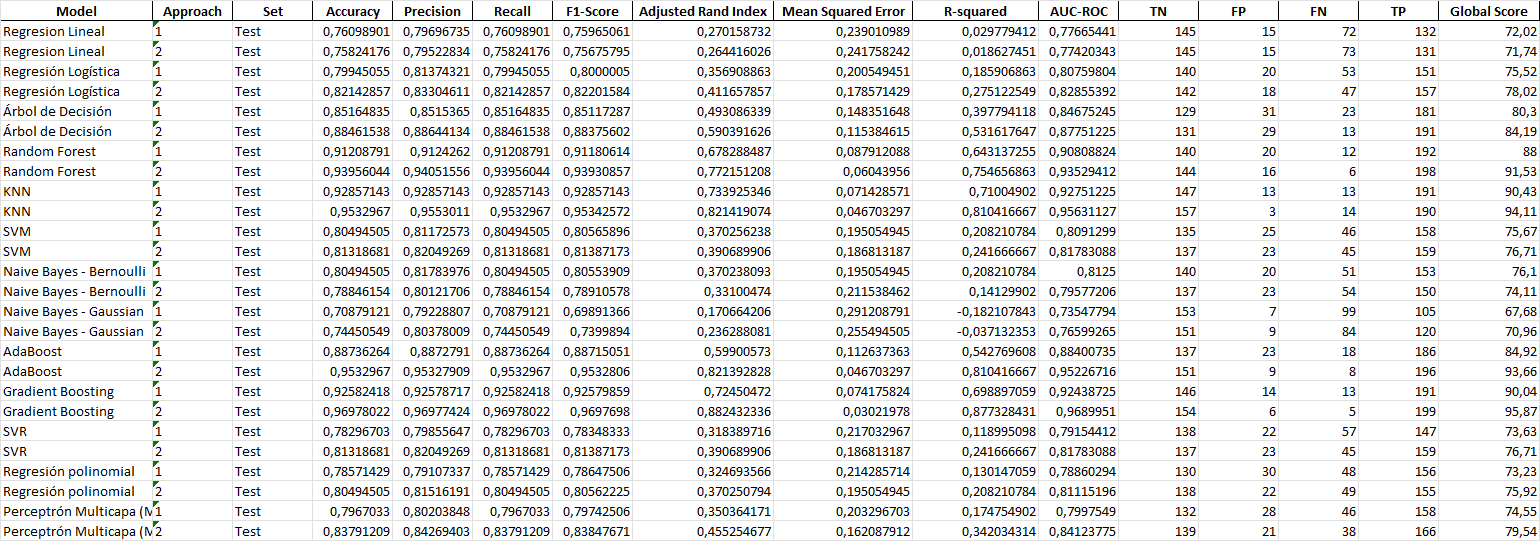

Resultados de los mejores modelos

Se han obtenido resultados bastante positivos con ciertos modelos supervisados :     

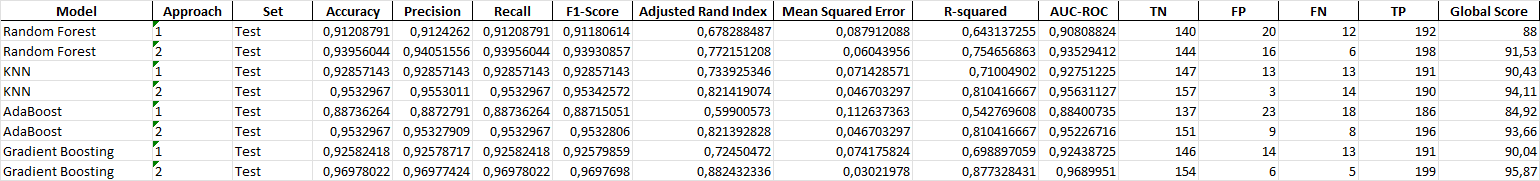


## Combinación de modelos mediante Voting classifier

Usando el Vooting Classifier se espera crear un modelo final, fruto de la combinación de los modelos con mejores resultados, hacienolo más robusto explotando las cualidades de cada modelo.

Un Voting Classifier es un tipo de modelo de ensamble en aprendizaje automático que combina las predicciones de múltiples modelos individuales (también conocidos como estimadores base) para mejorar el rendimiento y la precisión en la clasificación. La idea principal es que al combinar varios modelos, se pueden mitigar los errores individuales y aprovechar las fortalezas de cada uno

- Voting Classifier Mayoritario (Hard Voting):

    En este tipo, cada modelo individual realiza una predicción para una instancia dada y se toma una votación para determinar la clase final.
    La clase final asignada es la que recibe la mayoría de los votos (es decir, la clase más frecuente entre todas las predicciones de los modelos).
    Por ejemplo, si tres modelos predicen las clases A, B y B, respectivamente, la predicción final sería B, ya que tiene la mayoría de los votos.

- Voting Classifier Ponderado (Soft Voting):

    Aquí, cada modelo calcula las probabilidades de cada clase en lugar de hacer una predicción directa.
    Las probabilidades se suman (posiblemente ponderadas si se quiere dar más peso a ciertos modelos) y la clase con la mayor probabilidad agregada se selecciona como la predicción final.
    Esto permite una combinación más matizada de los modelos, ya que se tienen en cuenta las probabilidades asociadas con cada predicción.

In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model_name = 'Voting Classifier (KNN + Gradient Boosting + AdaBoost)'
# Best parameters for KNN (enfoque 1)
''' INICIAL
# Mejores parámetros para Gradient Boosting (enfoque 1)
best_params_gb_1 = {
    'learning_rate': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 200
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.5,
    'max_depth': 4,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 200
}

# Mejores parámetros para AdaBoost
best_params_ada = {
    'learning_rate': 0.5,
    'n_estimators': 300
}
''' 
'''
best_params_knn = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 3,
    'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
    'algorithm': 'brute',
    'leaf_size': 10,
    'metric': 'hamming',
    'n_neighbors': 11,
    'weights': 'distance'
}

# Mejores parámetros para Gradient Boosting (enfoque 1)
best_params_gb_1 = {
    'learning_rate': 0.015,  # Reducir la tasa de aprendizaje
    'max_depth': 3,  # Reducir la profundidad máxima
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 200,
    'subsample': 0.8,  # Añadir subsampling
    'validation_fraction': 0.2,  # Usar 20% de los datos para validación
    'n_iter_no_change': 10,  # Detener si no hay mejora en 10 iteraciones
    'tol': 1e-4  # Tolerancia para el cambio
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
    'learning_rate': 0.05,  # Reducir la tasa de aprendizaje
    'max_depth': 3,  # Reducir la profundidad máxima
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 200,
    'subsample': 0.8,  # Añadir subsampling
    'validation_fraction': 0.2,  # Usar 20% de los datos para validación
    'n_iter_no_change': 10,  # Detener si no hay mejora en 10 iteraciones
    'tol': 1e-4  # Tolerancia para el cambio
}

# Mejores parámetros para AdaBoost
best_params_ada = {
    'learning_rate': 0.015,
    'n_estimators': 100  # Reducir el número de estimadores
}
'''
best_params_knn = {
 'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'hamming',
 'n_neighbors': 3,
 'weights': 'uniform'
}

# Best parameters for KNN (enfoque 2)
best_params_knn_2 = {
 'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'hamming',
 'n_neighbors': 2,
 'weights': 'distance'
}

# Mejores parámetros para Gradient Boosting (enfoque 1)
best_params_gb_1 = {
 'learning_rate': 0.015, # Reducir la tasa de aprendizaje
 'max_depth': 3, # Reducir la profundidad máxima
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200,
 'subsample': 0.8, # Añadir subsampling
 'validation_fraction': 0.2, # Usar 20% de los datos para validación
 'n_iter_no_change': 10, # Detener si no hay mejora en 10 iteraciones
 'tol': 1e-4 # Tolerancia para el cambio
}

# Mejores parámetros para Gradient Boosting (enfoque 2)
best_params_gb_2 = {
 'learning_rate': 0.05, # Reducir la tasa de aprendizaje
 'max_depth': 2, # Reducir la profundidad máxima
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100,
}

# Mejores parámetros para AdaBoost
best_params_ada = {
 'learning_rate': 0.07,
 'n_estimators': 100 # Reducir el número de estimadores
}
# Crear los modelos KNN con los mejores parámetros
knn_1 = KNeighborsClassifier(**best_params_knn)
knn_2 = KNeighborsClassifier(**best_params_knn_2)

# Crear los modelos GradientBoosting con los mejores parámetros
grad_boost_1 = GradientBoostingClassifier(**best_params_gb_1)
grad_boost_2 = GradientBoostingClassifier(**best_params_gb_2)

# Crear los modelos AdaBoost con los mejores parámetros
base_estimator = DecisionTreeClassifier(max_depth=2)
ada_boost = AdaBoostClassifier(estimator=base_estimator, **best_params_ada)

# Crear el Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('knn', knn_1), ('grad_boost', grad_boost_1), ('ada_boost', ada_boost)],
    voting='soft'  # Puede ser 'hard' para votación mayoritaria
)

# Entrenar el Voting Classifier
voting_clf.fit(X_train_prep, y_train)

# Hacer predicciones
y_train_pred = voting_clf.predict(X_train_prep)
y_val_pred = voting_clf.predict(X_val_prep)
y_test_pred = voting_clf.predict(X_test_prep)

# Mostrar estadísticas y guardar resultados
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation", model_name, enfoque="1", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, enfoque="1", print_roc="NO")

dump(voting_clf, 'Modelos supervisados entrenados/voting_clf_e1_1.joblib')

# Enfoque 2
# Crear el Voting Classifier
voting_clf_2 = VotingClassifier(
    estimators=[('knn', knn_2), ('grad_boost', grad_boost_2), ('ada_boost', ada_boost)],
    voting='soft'  # Puede ser 'hard' para votación mayoritaria
)

voting_clf_2.fit(X_train_prep_2, y_train_2)
y_train_pred_2 = voting_clf_2.predict(X_train_prep_2)
y_val_pred_2 = voting_clf_2.predict(X_val_prep_2)
y_test_pred_2 = voting_clf_2.predict(X_test_prep_2)

mostrar_estadisticas_guardar_tabla(y_train_2, y_train_pred_2, "Training", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_val_2, y_val_pred_2, "Validation", model_name, enfoque="2", print_roc="NO")
mostrar_estadisticas_guardar_tabla(y_test_2, y_test_pred_2, "Test", model_name, enfoque="2", print_roc="NO")


dump(voting_clf_2, 'Modelos supervisados entrenados/voting_clf_e2_1.joblib')

Metrics for Training set :
 - Accuracy: 0.9770
 - Precision: 0.9771
 - Recall: 0.9770
 - F1-Score: 0.9770
 - Adjusted Rand Index: 0.9102
 - Mean Squared Error: 0.0230
 - R-squared: 0.9071
 - Área bajo la curva : 0.977
 - Confusion Matrix: 
[[476  11]
 [ 14 588]]
 - Global Score : 96.92

Metrics for Validation set :
 - Accuracy: 0.9505
 - Precision: 0.9512
 - Recall: 0.9505
 - F1-Score: 0.9506
 - Adjusted Rand Index: 0.8115
 - Mean Squared Error: 0.0495
 - R-squared: 0.8005
 - Área bajo la curva : 0.952
 - Confusion Matrix: 
[[159   6]
 [ 12 187]]
 - Global Score : 93.57

Metrics for Test set :
 - Accuracy: 0.9478
 - Precision: 0.9482
 - Recall: 0.9478
 - F1-Score: 0.9477
 - Adjusted Rand Index: 0.8015
 - Mean Squared Error: 0.0522
 - R-squared: 0.7881
 - Área bajo la curva : 0.945
 - Confusion Matrix: 
[[147  13]
 [  6 198]]
 - Global Score : 92.72

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 

['Modelos supervisados entrenados/voting_clf_e2_1.joblib']

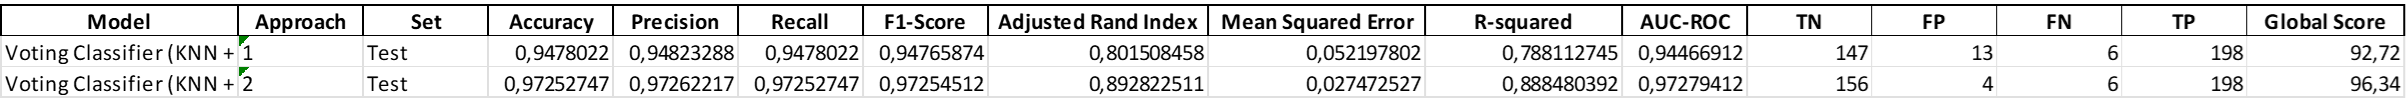

## Tabla Final con todos los modelos supervisados 

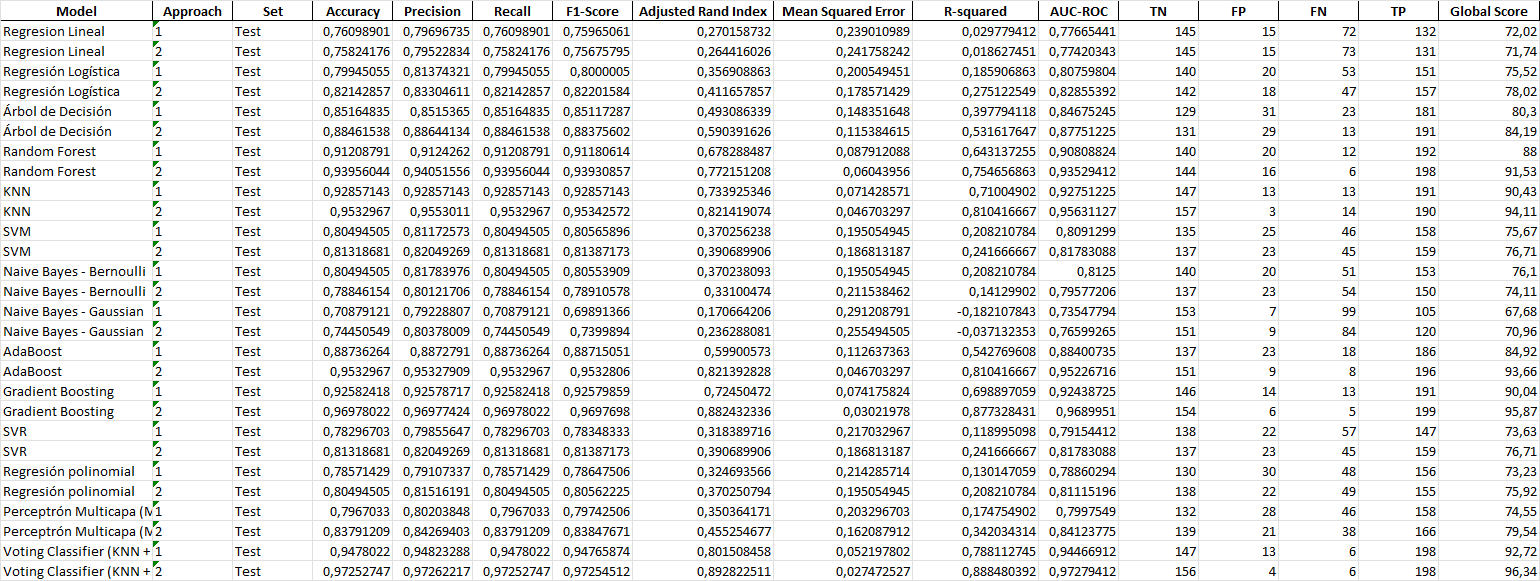

## Conclusion Parte 1

Se han obtenido resultados alentadores, con modelos con métricas de evaluación bastante positivas y que a su vez generalizan bien en la fase de test.

Por regla general, el enfoque dos del estudio obtiene mejores resultados a la hora de predecir el cáncer.

Siendo los modelos bastante simples y poco costosos a nivel computacional, vamos a probar a combinarlos con modelos de aprendizaje no supervisado para ver si mejoran los resultados o encontramos alguna combinación que reduzca el overfitting presente en alguno de los modelos.

Para ellos vamos a preprocesar los datos usando los modelos no supervisados de forma que podamos explotar diferentes aspectos de los datos: 

    - clustering puede descubrir estructuras ocultas
    - la reducción de dimensionalidad puede simplificar la información
    - los autoencoders pueden encontrar representaciones más efectivas de los datos

De esta manera vamos a crear primero los modelos no supervisados y una vez ajustados, procederemos a combinarlos con los supervisados.

## Aprendizaje no supervisado

### Clustering K-means

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model_name = 'KMeans'
print(model_name)
model_KM = KMeans(random_state=42)

# Encontrar el número óptimo de clústeres
num_clusters_optimo = encontrar_numero_optimo_clusters(X_train_prep, X_val_prep, model_KM, plot_grafica = 'NO')
print("Número de clusteres optimo : " + str(num_clusters_optimo))

# Entrenar el modelo final con el número óptimo de clústeres usando los datos de entrenamiento
kmeans_final = KMeans(n_clusters=num_clusters_optimo, random_state=0)
kmeans_final.fit(X_train_prep) # Entrenar con np.vstack((X_train_prep, X_val_prep))? se recomienda llevar a cabo esta práctica

labels_train = model_KM.predict(X_train_prep)
labels_val = kmeans_final.predict(X_val_prep)
labels_test = kmeans_final.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, 'Training',  model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val,'Validation', model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test,'Test', model_name)



KMeans
Número de clusteres optimo : 8
Metrics for Training set (KMeans):
 - Silhouette Score: 0.4641
 - Davies-Bouldin Index: 1.0101
 - Calinski-Harabasz Index: 273.2182
 - Global Score: 115.3052

Metrics for Validation set (KMeans):
 - Silhouette Score: 0.4278
 - Davies-Bouldin Index: 1.2907
 - Calinski-Harabasz Index: 112.6880
 - Global Score: 56.5149

Metrics for Test set (KMeans):
 - Silhouette Score: 0.3969
 - Davies-Bouldin Index: 1.2412
 - Calinski-Harabasz Index: 95.4503
 - Global Score: 51.0783



C:\Users\danie\AppData\Local\Temp\ipykernel_17696\2151088884.py:418: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_NS_df = pd.concat([tabla_results_NS_df, new_row], ignore_index=True)


,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325


### Mean Shift

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

model_name = 'Mean Shift'
print(model_name)

# Función para realizar la búsqueda de bandwidth óptimo
def find_optimal_bandwidth(X, bandwidths):
    best_bandwidth = None
    best_score = -1
    best_labels = None
    best_cluster_centers = None
    
    for bandwidth in bandwidths:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(X)
        labels = ms.labels_
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_bandwidth = bandwidth
                best_labels = labels
                best_cluster_centers = ms.cluster_centers_
    
    return best_bandwidth, best_labels, best_cluster_centers, best_score

# Definir el rango de valores de bandwidth para la búsqueda
bandwidths = np.linspace(0.1, 2.0, 20)

# Buscar el bandwidth óptimo usando el conjunto de validación
optimal_bandwidth, labels_val, cluster_centers, best_score = find_optimal_bandwidth(X_val_prep, bandwidths)

print("Bandwidth óptimo:", optimal_bandwidth)
print("Mejor Silhouette Score en Validación:", best_score)
print("Número de clústeres estimados en Validación:", len(np.unique(labels_val)))

def map_clusters_to_labels(labels, true_labels):
    from scipy.stats import mode
    # Asegurarse de que labels y true_labels sean arreglos
    labels = np.asarray(labels)
    true_labels = np.asarray(true_labels)
    
    # Crear una matriz de confusión
    conf_matrix = confusion_matrix(true_labels, labels)
    
    # Crear un arreglo para mapear los clusters a las etiquetas reales
    cluster_label_map = np.zeros_like(labels)
    
    # Asignar la etiqueta de clase más frecuente a cada cluster
    for i in range(conf_matrix.shape[1]):
        mask = labels == i
        if np.any(mask):  # Asegurarse de que el cluster tenga etiquetas
            most_common_label = mode(true_labels[mask])[0][0]
            cluster_label_map[mask] = most_common_label
    
    return cluster_label_map

# Entrenar el modelo final en el conjunto de entrenamiento usando el bandwidth óptimo
ms = MeanShift(bandwidth=optimal_bandwidth, bin_seeding=True)
ms.fit(X_train_prep)
labels_train = ms.labels_

labels_train = ms.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = ms.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = ms.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Mean Shift


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_mean_shift.py:293: UserWarning: Binning data failed with provided bin_size=0.100000, using data points as seeds.
  warnings.warn(


Bandwidth óptimo: 2.0
Mejor Silhouette Score en Validación: 0.49649056185727314
Número de clústeres estimados en Validación: 27
Metrics for Training set (Mean Shift):
 - Silhouette Score: 0.4751
 - Davies-Bouldin Index: 0.5551
 - Calinski-Harabasz Index: 102.1839
 - Global Score: 66.0603

Metrics for Validation set (Mean Shift):
 - Silhouette Score: 0.4639
 - Davies-Bouldin Index: 0.8139
 - Calinski-Harabasz Index: 91.5688
 - Global Score: 58.0234

Metrics for Test set (Mean Shift):
 - Silhouette Score: 0.5165
 - Davies-Bouldin Index: 0.7324
 - Calinski-Harabasz Index: 99.7171
 - Global Score: 62.9735



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494


### Clustering DBSCAN

In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model_name = 'DBSCAN'
print(model_name)

# Función para encontrar el mejor valor de eps
def find_optimal_eps(X, eps_values, min_samples):
    best_eps = None
    best_score = -1
    best_labels = None
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Solo evaluar si hay más de un cluster (ignorar ruido)
        if len(np.unique(labels)) > 1 and np.sum(labels != -1) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels
                
    return best_eps, best_labels, best_score

# Definir el rango de valores de eps para la búsqueda
eps_values = np.linspace(0.1, 5.0, 50)
min_samples = 5  # Puedes ajustar este valor según sea necesario

# Buscar el eps óptimo usando el conjunto de entrenamiento
optimal_eps, labels_train, best_score = find_optimal_eps(X_train_prep, eps_values, min_samples)

print("Epsilon óptimo:", optimal_eps)
print("Mejor Silhouette Score en Entrenamiento:", best_score)
print("Número de clústeres estimados en Entrenamiento:", len(np.unique(labels_train)))

# Entrenar el modelo final en el conjunto de entrenamiento usando el eps óptimo
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=min_samples)

labels_train = dbscan_final.fit_predict(X_train_prep)
labels_val = dbscan_final.fit_predict(X_val_prep)
labels_test = dbscan_final.fit_predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

DBSCAN
Epsilon óptimo: 5.0
Mejor Silhouette Score en Entrenamiento: 0.8345117277543379
Número de clústeres estimados en Entrenamiento: 2
Metrics for Training set (DBSCAN):
 - Silhouette Score: 0.8345
 - Davies-Bouldin Index: 1.6855
 - Calinski-Harabasz Index: 165.2953
 - Global Score: 74.2479

Metrics for Validation set (DBSCAN):
 - Silhouette Score: 0.8280
 - Davies-Bouldin Index: 1.7537
 - Calinski-Harabasz Index: 65.2129
 - Global Score: 39.6424

Metrics for Test set (DBSCAN):
 - Silhouette Score: 0.8291
 - Davies-Bouldin Index: 1.4921
 - Calinski-Harabasz Index: 104.9640
 - Global Score: 57.2712



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494
6,DBSCAN,Training,0.834512,1.685545,165.295350,74.247901
7,DBSCAN,Validation,0.828025,1.753742,65.212920,39.642352
8,DBSCAN,Test,0.829080,1.492089,104.964042,57.271192


### Clustering GMM

In [7]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define un pipeline que combina un modelo de mezcla gaussiana
pipeline = Pipeline([
    ('gmm', GaussianMixture(random_state=42))
])

# Define la cuadrícula de parámetros para buscar
param_grid = {
    'gmm__n_components': [1, 2, 3, 4, 5],
    'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']
}

# Crea un objeto GridSearchCV
model_GMM = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')

# Ajusta el objeto GridSearchCV a los datos
model_GMM.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
print("Mejores parámetros: ", model_GMM.best_params_)


labels_train = model_GMM.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = model_GMM.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = model_GMM.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Mejores parámetros:  {'gmm__covariance_type': 'spherical', 'gmm__n_components': 2}
Metrics for Training set (DBSCAN):
 - Silhouette Score: 0.4183
 - Davies-Bouldin Index: 1.7753
 - Calinski-Harabasz Index: 167.3948
 - Global Score: 66.5144

Metrics for Validation set (DBSCAN):
 - Silhouette Score: 0.4395
 - Davies-Bouldin Index: 1.9838
 - Calinski-Harabasz Index: 40.1824
 - Global Score: 20.9877

Metrics for Test set (DBSCAN):
 - Silhouette Score: 0.4570
 - Davies-Bouldin Index: 1.8519
 - Calinski-Harabasz Index: 48.5301
 - Global Score: 26.2616



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494
6,DBSCAN,Training,0.834512,1.685545,165.295350,74.247901
7,DBSCAN,Validation,0.828025,1.753742,65.212920,39.642352
8,DBSCAN,Test,0.829080,1.492089,104.964042,57.271192
9,DBSCAN,Training,0.418259,1.775290,167.394816,66.514415


### Análisis de componentes principales (PCA) 

In [8]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Crear y ajustar el modelo PCA para calcular la variancia explicada
pca_temp = PCA()
pca_temp.fit(X_train_prep)

# Calcular la variancia explicada acumulada
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)

# Determinar el número de componentes que explican al menos el 95% de la variancia
n_components = np.argmax(explained_variance >= 0.95) + 1

if n_components == X_train_prep.shape[1] :
    print(f"Número óptimo de componentes para explicar al menos el 95% de la variancia es de {n_components}" 
      f" que coincide con el número actual de variables es de {X_train_prep.shape[1]}. \n"
       "Por tanto no se aplica el algoritmo PCA")
    
else :
    print(f"Número óptimo de componentes para explicar al menos el 95% de la variancia: {n_components} ")

    # Crear y ajustar el modelo PCA con el número óptimo de componentes
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_prep)
    X_val_pca = pca.transform(X_val_prep)
    X_test_pca = pca.transform(X_test_prep)


Número óptimo de componentes para explicar al menos el 95% de la variancia: 8 


### Análisis de componentes independientes (ICA)

In [37]:
from sklearn.decomposition import FastICA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Crear y ajustar el modelo ICA
model_name = 'Análisis de Componentes Independientes (ICA)'
print(model_name)
model_ICA = FastICA()
model_ICA.fit(X_train_prep)

# No se aplica el modelo ICA a los datos de entrenamiento, validación y prueba
X_train_ica = model_ICA.transform(X_train_prep)
X_val_ica = model_ICA.transform(X_val_prep)
X_test_ica = model_ICA.transform(X_test_prep)

# Crear y ajustar el modelo Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train_ica)

# Predicción de anomalías en el conjunto de entrenamiento, validación y prueba
anomalies_train = isolation_forest.predict(X_train_ica)
anomalies_val = isolation_forest.predict(X_val_ica)
anomalies_test = isolation_forest.predict(X_test_ica)

# Convertir las predicciones a etiquetas binarias (0 para normal, 1 para anomalía)
anomalies_train_labels = np.where(anomalies_train == -1, 1, 0)
anomalies_val_labels = np.where(anomalies_val == -1, 1, 0)
anomalies_test_labels = np.where(anomalies_test == -1, 1, 0)

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, anomalies_train_labels, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, anomalies_val_labels, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, anomalies_test_labels, "Test", model_name)


Análisis de Componentes Independientes (ICA)
Metrics for Training set (Análisis de Componentes Independientes (ICA)):
 - Silhouette Score: 0.6568
 - Davies-Bouldin Index: 2.0301
 - Calinski-Harabasz Index: 168.6725
 - Global Score: 66.6690

Metrics for Validation set (Análisis de Componentes Independientes (ICA)):
 - Silhouette Score: 0.6507
 - Davies-Bouldin Index: 2.0672
 - Calinski-Harabasz Index: 56.1600
 - Global Score: 28.4458

Metrics for Test set (Análisis de Componentes Independientes (ICA)):
 - Silhouette Score: 0.6903
 - Davies-Bouldin Index: 1.6556
 - Calinski-Harabasz Index: 93.0848
 - Global Score: 48.2728



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Clustering Jerárquico,Training,0.836252,1.348159,197.325390,90.576674
1,Clustering Jerárquico,Validation,0.888725,0.074304,82.044252,74.255095
2,Clustering Jerárquico,Test,0.620584,1.498707,100.826994,52.306950
3,Algoritmo AnDE,Training,0.743961,2.077912,157.092062,63.464839
4,Algoritmo AnDE,Validation,0.682671,2.087814,53.477549,27.740134
5,Algoritmo AnDE,Test,0.736900,1.630349,91.849113,49.058886
6,Detección de Anomalías (Isolation Forest),Training,0.657663,1.963624,177.373949,70.691969
7,Detección de Anomalías (Isolation Forest),Validation,0.633634,2.064200,56.060025,28.177234
8,Detección de Anomalías (Isolation Forest),Test,0.665247,1.692517,88.044333,45.560276
9,Detección de Anomalías (Isolation Forest),Training,0.657663,1.963624,177.373949,70.691969


### Análisis discriminante lineal (LDA)

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

model_name = 'LDA'
print(model_name)

lda = LinearDiscriminantAnalysis()

n_features = X_train_prep.shape[1]
n_classes = len(np.unique(y_train))
max_components = min(n_features, n_classes - 1)

# Definir los hiperparámetros a buscar
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'n_components': [None] + list(range(1, max_components + 1))
}

# Definir GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_LDA = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters : {best_params}")

model_LDA.fit(X_train_prep, y_train)

labels_train = model_LDA.predict(X_train_prep)
labels_val = model_LDA.predict(X_val_prep)
labels_test = model_LDA.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

LDA
Best parameters : {'n_components': None, 'solver': 'svd'}
Metrics for Training set (LDA):
 - Silhouette Score: 0.3142
 - Davies-Bouldin Index: 1.7509
 - Calinski-Harabasz Index: 143.9939
 - Global Score: 57.3853

Metrics for Validation set (LDA):
 - Silhouette Score: 0.3453
 - Davies-Bouldin Index: 2.0540
 - Calinski-Harabasz Index: 31.1312
 - Global Score: 15.2328

Metrics for Test set (LDA):
 - Silhouette Score: 0.3221
 - Davies-Bouldin Index: 1.8274
 - Calinski-Harabasz Index: 38.7463
 - Global Score: 21.1591



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494
6,DBSCAN,Training,0.834512,1.685545,165.295350,74.247901
7,DBSCAN,Validation,0.828025,1.753742,65.212920,39.642352
8,DBSCAN,Test,0.829080,1.492089,104.964042,57.271192
9,DBSCAN,Training,0.418259,1.775290,167.394816,66.514415


### Clustering Jerárquico

In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

model_name = 'Clustering Jerárquico'
print(model_name)

# Función para encontrar el mejor número de clústeres
def find_optimal_clusters(X, max_clusters):
    best_num_clusters = None
    best_score = -1
    best_labels = None

    for num_clusters in range(2, max_clusters + 1):
        agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
        labels = agg_clustering.fit_predict(X)

        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_num_clusters = num_clusters
            best_labels = labels

    return best_num_clusters, best_labels, best_score

# Definir el número máximo de clústeres para la búsqueda
max_clusters = 10

# Buscar el número óptimo de clústeres usando el conjunto de entrenamiento
optimal_num_clusters, labels_train, best_score = find_optimal_clusters(X_train_prep, max_clusters)

print("Número óptimo de clústeres:", optimal_num_clusters)
print("Mejor Silhouette Score en Entrenamiento:", best_score)

# Entrenar el modelo final en el conjunto de entrenamiento usando el número óptimo de clústeres
agg_clustering_final = AgglomerativeClustering(n_clusters=optimal_num_clusters)

labels_train = agg_clustering_final.fit_predict(X_train_prep)
labels_val = agg_clustering_final.fit_predict(X_val_prep)
labels_test = agg_clustering_final.fit_predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Clustering Jerárquico
Número óptimo de clústeres: 2
Mejor Silhouette Score en Entrenamiento: 0.5232699556257556
Metrics for Training set (Clustering Jerárquico):
 - Silhouette Score: 0.5233
 - Davies-Bouldin Index: 1.6639
 - Calinski-Harabasz Index: 203.4069
 - Global Score: 82.1247

Metrics for Validation set (Clustering Jerárquico):
 - Silhouette Score: 0.8798
 - Davies-Bouldin Index: 0.1683
 - Calinski-Harabasz Index: 110.0755
 - Global Score: 81.8830

Metrics for Test set (Clustering Jerárquico):
 - Silhouette Score: 0.8506
 - Davies-Bouldin Index: 0.7645
 - Calinski-Harabasz Index: 162.2876
 - Global Score: 88.8650



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494
6,DBSCAN,Training,0.834512,1.685545,165.295350,74.247901
7,DBSCAN,Validation,0.828025,1.753742,65.212920,39.642352
8,DBSCAN,Test,0.829080,1.492089,104.964042,57.271192
9,DBSCAN,Training,0.418259,1.775290,167.394816,66.514415


### Algoritmo AnDE (Adaptive Nearest Neighbors Density Estimation)

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
# TODO Verificar este modelo
# Algoritmo AnDE : calcular la densidad de los puntos y luego determinar anomalías basadas en un umbral.

class AnDE:
    def __init__(self, k=5, threshold=0.5):
        self.k = k
        self.threshold = threshold

    def fit(self, X):
        self.nbrs = NearestNeighbors(n_neighbors=self.k).fit(X)
        self.densities = self.nbrs.kneighbors_graph(X).sum(axis=1)

    def score_samples(self, X):
        distances, _ = self.nbrs.kneighbors(X)
        density_of_neighbors = self.densities.flatten()
        density_of_neighbors[density_of_neighbors == 0] = np.finfo(float).eps
        return 1 / (density_of_neighbors.mean() / distances.mean(axis=1))

model_name = 'Algoritmo AnDE'
print(model_name)

# Entrenar el modelo AnDE
ande_model = AnDE()
ande_model.fit(X_train_prep)

# Calcular la densidad para cada punto en el conjunto de entrenamiento
densities_train = ande_model.score_samples(X_train_prep)

# Calcular el umbral óptimo basado en la densidad
threshold = np.percentile(densities_train, 95)

# Predicción de anomalías en el conjunto de entrenamiento
anomalies_train = densities_train > threshold

# Calcular el Silhouette Score para evaluar la calidad del modelo
silhouette_score_train = silhouette_score(X_train_prep, anomalies_train)

print("Umbral óptimo basado en la densidad:", threshold)
print("Silhouette Score en el conjunto de entrenamiento:", silhouette_score_train)

# Predicción de anomalías en los conjuntos de validación y prueba
anomalies_val = ande_model.score_samples(X_val_prep) > threshold
anomalies_test = ande_model.score_samples(X_test_prep) > threshold

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, anomalies_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, anomalies_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, anomalies_test, "Test", model_name)


Algoritmo AnDE
Umbral óptimo basado en la densidad: 0.3521188485423611
Silhouette Score en el conjunto de entrenamiento: 0.7359999834741843
Metrics for Training set (Algoritmo AnDE):
 - Silhouette Score: 0.7360
 - Davies-Bouldin Index: 1.9070
 - Calinski-Harabasz Index: 177.7466
 - Global Score: 73.0649

Metrics for Validation set (Algoritmo AnDE):
 - Silhouette Score: 0.7121
 - Davies-Bouldin Index: 1.9733
 - Calinski-Harabasz Index: 63.5645
 - Global Score: 33.5011

Metrics for Test set (Algoritmo AnDE):
 - Silhouette Score: 0.7283
 - Davies-Bouldin Index: 1.8278
 - Calinski-Harabasz Index: 76.5742
 - Global Score: 40.5323



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494
6,DBSCAN,Training,0.834512,1.685545,165.295350,74.247901
7,DBSCAN,Validation,0.828025,1.753742,65.212920,39.642352
8,DBSCAN,Test,0.829080,1.492089,104.964042,57.271192
9,DBSCAN,Training,0.418259,1.775290,167.394816,66.514415


### Detección de Anomalías (Isolation Forest)

Detección de Anomalías (Isolation Forest)
Metrics for Training set (Detección de Anomalías (Isolation Forest)):
 - Silhouette Score: 0.6452
 - Davies-Bouldin Index: 1.9120
 - Calinski-Harabasz Index: 185.0307
 - Global Score: 73.8975

Metrics for Validation set (Detección de Anomalías (Isolation Forest)):
 - Silhouette Score: 0.6838
 - Davies-Bouldin Index: 2.0051
 - Calinski-Harabasz Index: 60.5911
 - Global Score: 31.5077

Metrics for Test set (Detección de Anomalías (Isolation Forest)):
 - Silhouette Score: 0.7002
 - Davies-Bouldin Index: 1.8680
 - Calinski-Harabasz Index: 71.3779
 - Global Score: 37.6620



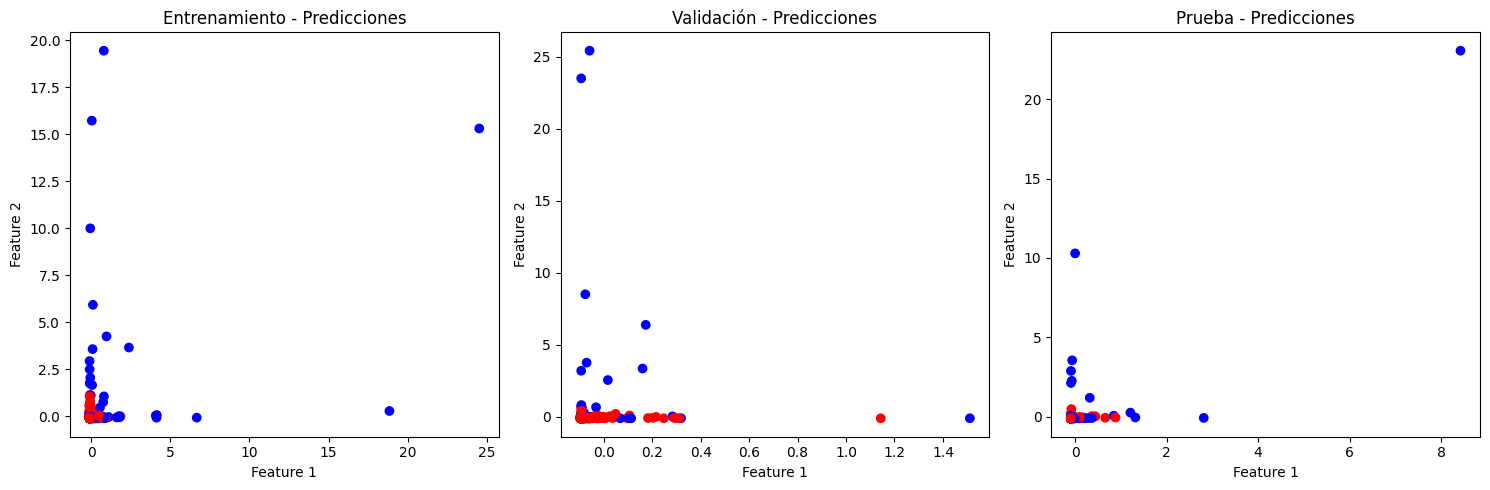

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

## TODO hasta que punto son anómalos estos registros y que hacer con ellos si de verdad lo son (cambiar a mano, borrar, entrenar por separado datos anómalos y normales) 
# Nos interesa borrar registros ? tenemos un número no muy elevado de ellos 
model_name = 'Detección de Anomalías (Isolation Forest)'
print(model_name)

# Convertir los conjuntos de datos a numpy arrays si no lo son ya
X_train_prep = np.array(X_train_prep)
X_val_prep = np.array(X_val_prep)
X_test_prep = np.array(X_test_prep)

# Entrenar el modelo Isolation Forest
model_isolation_forest = IsolationForest(contamination=0.1, random_state=42)
model_isolation_forest.fit(X_train_prep)

# Predicción de anomalías en el conjunto de entrenamiento, validación y prueba
anomalies_train = model_isolation_forest.predict(X_train_prep)
anomalies_val = model_isolation_forest.predict(X_val_prep)
anomalies_test = model_isolation_forest.predict(X_test_prep)

# Convertir las predicciones a etiquetas binarias (0 para normal, 1 para anomalía)
anomalies_train_labels = np.where(anomalies_train == -1, 1, 0)
anomalies_val_labels = np.where(anomalies_val == -1, 1, 0)
anomalies_test_labels = np.where(anomalies_test == -1, 1, 0)

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, anomalies_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, anomalies_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, anomalies_test, "Test", model_name)

# Eliminar registros anómalos
X_train_prep_sin_anom = X_train_prep[anomalies_train_labels == 0]
X_val_prep_sin_anom = X_val_prep[anomalies_val_labels == 0]
X_test_prep_sin_anom = X_test_prep[anomalies_test_labels == 0]

# Label por color
def label_to_color(y_pred):
    return ['blue' if y == 1 else 'red' for y in y_pred]

# Mostrar los resultados
plt.figure(figsize=(15, 5))

# Conjunto de Entrenamiento
plt.subplot(1, 3, 1)
plt.title("Entrenamiento - Predicciones")
plt.scatter(X_train_prep[:, 0], X_train_prep[:, 1], color=label_to_color(anomalies_train_labels))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Conjunto de Validación
plt.subplot(1, 3, 2)
plt.title("Validación - Predicciones")
plt.scatter(X_val_prep[:, 0], X_val_prep[:, 1], color=label_to_color(anomalies_val_labels))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Conjunto de Prueba
plt.subplot(1, 3, 3)
plt.title("Prueba - Predicciones")
plt.scatter(X_test_prep[:, 0], X_test_prep[:, 1], color=label_to_color(anomalies_test_labels))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

### Reducción de dimensionalidad SVD

In [13]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

## TODO ver si interesa reducir componentes. De primeras para la detección del cancer diría que no ya que hemos reducido a 9 variables previamente.
model_name = 'Reducción de Dimensionalidad SVD'
print(model_name)

max_components = X_train_prep.shape[1]

# Crear y ajustar el modelo SVD
model_SVD = TruncatedSVD(n_components=max_components)
model_SVD.fit(X_train_prep)

# Calcular la varianza explicada acumulada para establecer el peso de cada variable 
explained_variance_ratio = model_SVD.explained_variance_ratio_
cumulative_explained_variance = np.sum(explained_variance_ratio)
print("Varianza explicada acumulada:", cumulative_explained_variance)

# Aplicar el modelo SVD a los datos de entrenamiento, validación y prueba
X_train_reduced = model_SVD.transform(X_train_prep)
X_val_reduced = model_SVD.transform(X_val_prep)
X_test_reduced = model_SVD.transform(X_test_prep)

# Usamos Kmeans para poder dar valores a los los datos labels_train, labels_val y labels_test
model_KM = KMeans(random_state=42)

# Obtención del número de clusters optimo, escoger entre elbow o silhouette
optimal_k = optimal_cluster_number(X_train_prep, X_val_prep, model_KM, method='silhouette')
print(optimal_k)
# Ajustar el modelo con el número óptimo de clusters
kmeans = KMeans(n_clusters = optimal_k)
labels_train = kmeans.fit_predict(X_train_reduced)
labels_val = kmeans.predict(X_val_reduced)
labels_test = kmeans.predict(X_test_reduced)

# Mostrar estadísticas de anomalías
mostrar_estadisticas_guardar_tabla_NS(X_train_reduced, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_reduced, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_reduced, labels_test, "Test", model_name)


Reducción de Dimensionalidad SVD
Varianza explicada acumulada: 1.0
2
Metrics for Training set (Reducción de Dimensionalidad SVD):
 - Silhouette Score: 0.6412
 - Davies-Bouldin Index: 1.5215
 - Calinski-Harabasz Index: 250.5745
 - Global Score: 102.1875

Metrics for Validation set (Reducción de Dimensionalidad SVD):
 - Silhouette Score: 0.6639
 - Davies-Bouldin Index: 1.8781
 - Calinski-Harabasz Index: 56.9821
 - Global Score: 32.0916

Metrics for Test set (Reducción de Dimensionalidad SVD):
 - Silhouette Score: 0.6969
 - Davies-Bouldin Index: 1.6659
 - Calinski-Harabasz Index: 80.8168
 - Global Score: 44.1218



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.464099,1.010149,273.218186,115.305236
1,KMeans,Validation,0.427838,1.290703,112.688032,56.514928
2,KMeans,Test,0.396857,1.241164,95.450303,51.078325
3,Mean Shift,Training,0.475056,0.555120,102.183938,66.060252
4,Mean Shift,Validation,0.463911,0.813886,91.568798,58.023357
5,Mean Shift,Test,0.516495,0.732428,99.717107,62.973494
6,DBSCAN,Training,0.834512,1.685545,165.295350,74.247901
7,DBSCAN,Validation,0.828025,1.753742,65.212920,39.642352
8,DBSCAN,Test,0.829080,1.492089,104.964042,57.271192
9,DBSCAN,Training,0.418259,1.775290,167.394816,66.514415


### Resultados modelos no supervisados

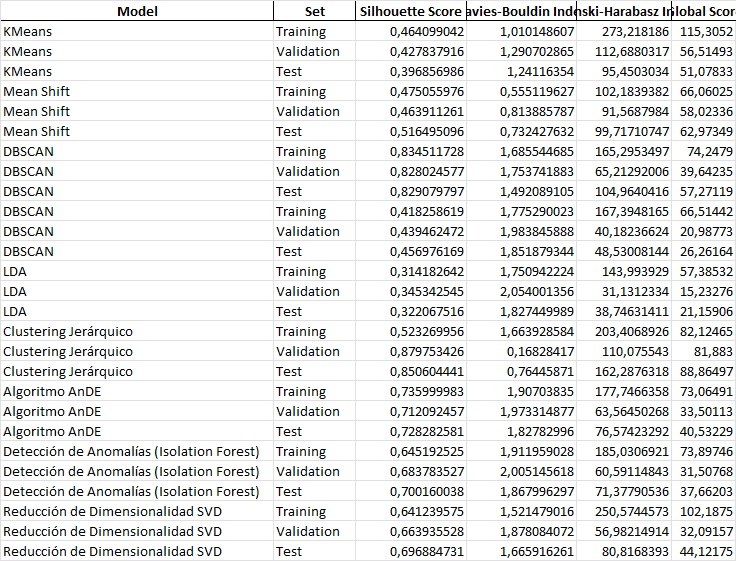

En este caso, las métricas obtenidas son parte 

### Transformar tabla_results_NS_df a formato Excel

In [14]:
tabla_results_NS_df.to_excel('model_results_NS.xlsx', index=False)

## Borrar informacion de las tablas

In [ ]:
# Borrar todos los registros
tabla_results_df = tabla_results_df.iloc[0:0]
tabla_results_NS_df = tabla_results_NS_df.iloc[0:0]

## Cruces entre modelos  no supervisados y supervisados

En este apartado se recogen los cruces entre modelos supervisados y no supervisados. 

Tras analizar las métricas de los modelos no supervisados, no se cree conveniente profundizar el estudio por esta rama. Esto se debe a que los clústeres generados no generan agrupaciones de datos que respondan a patrones ocultos dentro de los datos. Por tanto empeora el hecho de preprocesar los datos mediante estos modelos, para luego ser explotados por los métodos supervisados desarrollados en la primera parte. 

La reducción de componentes mediante estos algoritmos tampoco ofrece una ventaja considerable ya que, de por si, tenemos pocas variables al empezar el estudio de esta primera parte. Una reducción mayor resultaría en una pérdida de información valiosa que intercedería en una buena predicción del resultado.

No se han llegado a observar  características relevantes que puedan contener los datos a través de los modelos creados, pero existe la posibilidad de que las haya. Mediante un ajuste más fino de los hiperparámetros y una investigación más profunda de los marcadores biométricos que conforman el estudio, es posible llegar a conclusiones que ni si quiera hemos llegado a atisbar durante el proceso. 

Dejamos por tanto esta parte para ser explotada con mayor profundidad por futuros estudios sobre la materia. 


# Parte 2 - Detección del tipo de cáncer

## Preprocesar Datos

In [15]:
# Preprocesador
from pathlib import Path
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

important_features = [
        'sFas (pg/ml)',
        'sHER2/sEGFR2/sErbB2 (pg/ml)',
        'CA 15-3 (U/ml)',
        'CA19-9 (U/ml)',
        'CA-125 (U/ml)',
        'TIMP-2 (pg/ml)',
        'TGFa (pg/ml)',
        'Leptin (pg/ml)',
        'IL-8 (pg/ml)',
        'IL-6 (pg/ml)',
        'AFP (pg/ml)',
        'GDF15 (ng/ml)',
        'Prolactin (pg/ml)',
        'HGF (pg/ml)',
        'CD44 (ng/ml)',
        'Midkine (pg/ml)',
        'Thrombospondin-2 (pg/ml)',
        'TIMP-1 (pg/ml)',
        'HE4 (pg/ml)'
    ]
def get_data():
    return pd.read_excel('C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/CancerPredictionMLflow/research/validated_data.xlsx')

def encode_labels(df):
    print(df.columns)
    le = LabelEncoder()
    y = df['Tumor type']
    df['Tumor Type'] = le.fit_transform(y)
    label_encoders = {}
    label_encoders['Tumor Type'] = le
    return label_encoders

def get_preprocessor():
    numeric_features = important_features

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='passthrough'
    )
    
    return preprocessor

important_features = [
        'sFas (pg/ml)',
        'sHER2/sEGFR2/sErbB2 (pg/ml)',
        'CA 15-3 (U/ml)',
        'CA19-9 (U/ml)',
        'CA-125 (U/ml)',
        'TIMP-2 (pg/ml)',
        'TGFa (pg/ml)',
        'Leptin (pg/ml)',
        'IL-8 (pg/ml)',
        'IL-6 (pg/ml)',
        'AFP (pg/ml)',
        'GDF15 (ng/ml)',
        'Prolactin (pg/ml)',
        'HGF (pg/ml)',
        'CD44 (ng/ml)',
        'Midkine (pg/ml)',
        'Thrombospondin-2 (pg/ml)',
        'TIMP-1 (pg/ml)',
        'HE4 (pg/ml)'
    ]
df_to_process = get_data()
label_encoders = encode_labels(df_to_process)

train_df, test_df = train_test_split(df_to_process, test_size=0.3, random_state=42)
        
y_train = train_df.pop('Tumor type')
y_test = test_df.pop('Tumor type')

preprocessor = get_preprocessor()

train_df_transformed = preprocessor.fit_transform(train_df[important_features])
test_df_transformed = preprocessor.transform(test_df[important_features])

feature_names = important_features

train_df_transformed = pd.DataFrame(train_df_transformed, columns=feature_names)
test_df_transformed = pd.DataFrame(test_df_transformed, columns=feature_names)

train_df_transformed['Tumor type'] = y_train.values
test_df_transformed['Tumor type'] = y_test.values

#train_df_transformed.to_excel(self.config.transformed_train_data_path, index=False)
#test_df_transformed.to_excel(self.config.transformed_test_data_path, index=False)

joblib.dump(preprocessor, 'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/Modelos supervisados entrenados/preprocessor.joblib')

for feature, encoder in label_encoders.items():
    joblib.dump(encoder, f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/Modelos supervisados entrenados/{feature}_label_encoder.joblib')

Index(['Tumor type', 'AJCC Stage', 'AFP (pg/ml)', 'Angiopoietin-2 (pg/ml)',
       'AXL (pg/ml)', 'CA-125 (U/ml)', 'CA 15-3 (U/ml)', 'CA19-9 (U/ml)',
       'CD44 (ng/ml)', 'CEA (pg/ml)', 'CYFRA 21-1 (pg/ml)', 'DKK1 (ng/ml)',
       'Endoglin (pg/ml)', 'FGF2 (pg/ml)', 'Follistatin (pg/ml)',
       'Galectin-3 (ng/ml)', 'G-CSF (pg/ml)', 'GDF15 (ng/ml)', 'HE4 (pg/ml)',
       'HGF (pg/ml)', 'IL-6 (pg/ml)', 'IL-8 (pg/ml)', 'Kallikrein-6 (pg/ml)',
       'Leptin (pg/ml)', 'Mesothelin (ng/ml)', 'Midkine (pg/ml)',
       'Myeloperoxidase (ng/ml)', 'NSE (ng/ml)', 'OPG (ng/ml)', 'OPN (pg/ml)',
       'PAR (pg/ml)', 'Prolactin (pg/ml)', 'sEGFR (pg/ml)', 'sFas (pg/ml)',
       'SHBG (nM)', 'sHER2/sEGFR2/sErbB2 (pg/ml)', 'sPECAM-1 (pg/ml)',
       'TGFa (pg/ml)', 'Thrombospondin-2 (pg/ml)', 'TIMP-1 (pg/ml)',
       'TIMP-2 (pg/ml)', 'Omega score', 'Sex'],
      dtype='object')


## Creación de datos sintéticos mediante CTGAN

En este apartado se lleva a cabo la creación de los modelos de generación de datos sintéticos. Ambos con objetivos distintos:

- Parte 1. La creación de datos sintéticos en esta parte tiene unicamente el fin de simular datos que podrían encontrarse en producción para la app creada. 
        Para cada variable se genera un sample con una distribución acorde a la original, de forma que se intenta respetar la legitimidad del dato en la mayor medida de lo posible.

- Parte 2.  La creación de datos sintéticos en esta parte tiene dos fines. El primero abordar el problema de poseer un dump de datos tan pobre, numericamente hablando, 
y compensar los desbalances entre los registros para cada tipo de cáncer. Al aumentar el número de registros, la etapa de training es más rica y el modelo alcanza a ajustarse mejor ofreciendo unos resultados mucho mejores en la etapa de testing.
La segunda razón es utilizar samples creados con este modelo de CTGAN con una distribución acorde a la original, de forma que se intenta respetar de igual manera, la legitimidad del dato en la mayor medida de lo posible. 

Contraparte: 
Existe la posibilidad de condicionar el resultado ya que se está alimentando la etapa de entrenamiento con la generación de datos en base a un modelo, y más tarde en la etapa de producción, alimentamos con la creación de un sample de este modelo.

In [13]:
# Preprocesador
import joblib
from sklearn.pipeline import Pipeline

important_features = [
        'sFas (pg/ml)',
        'sHER2/sEGFR2/sErbB2 (pg/ml)',
        'CA 15-3 (U/ml)',
        'CA19-9 (U/ml)',
        'CA-125 (U/ml)',
        'TIMP-2 (pg/ml)',
        'TGFa (pg/ml)',
        'Leptin (pg/ml)',
        'IL-8 (pg/ml)',
        'IL-6 (pg/ml)',
        'AFP (pg/ml)',
        'GDF15 (ng/ml)',
        'Prolactin (pg/ml)',
        'HGF (pg/ml)',
        'CD44 (ng/ml)',
        'Midkine (pg/ml)',
        'Thrombospondin-2 (pg/ml)',
        'TIMP-1 (pg/ml)',
        'HE4 (pg/ml)'
    ]

def get_preprocessor():
    numeric_features = important_features

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='passthrough'
    )
    
    return preprocessor

important_features = [
        'sFas (pg/ml)',
        'sHER2/sEGFR2/sErbB2 (pg/ml)',
        'CA 15-3 (U/ml)',
        'CA19-9 (U/ml)',
        'CA-125 (U/ml)',
        'TIMP-2 (pg/ml)',
        'TGFa (pg/ml)',
        'Leptin (pg/ml)',
        'IL-8 (pg/ml)',
        'IL-6 (pg/ml)',
        'AFP (pg/ml)',
        'GDF15 (ng/ml)',
        'Prolactin (pg/ml)',
        'HGF (pg/ml)',
        'CD44 (ng/ml)',
        'Midkine (pg/ml)',
        'Thrombospondin-2 (pg/ml)',
        'TIMP-1 (pg/ml)',
        'HE4 (pg/ml)'
    ]

df = pd.read_excel('C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/CancerPredictionMLflow/research/validated_data.xlsx')

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
        
y_train = train_df.pop('Tumor type')
y_test = test_df.pop('Tumor type')

preprocessor = get_preprocessor()

train_df_transformed = preprocessor.fit_transform(train_df[important_features])
test_df_transformed = preprocessor.transform(test_df[important_features])

feature_names = important_features

train_df_transformed = pd.DataFrame(train_df_transformed, columns=feature_names)
test_df_transformed = pd.DataFrame(test_df_transformed, columns=feature_names)

train_df_transformed['Tumor type'] = y_train.values
test_df_transformed['Tumor type'] = y_test.values

#train_df_transformed.to_excel(self.config.transformed_train_data_path, index=False)
#test_df_transformed.to_excel(self.config.transformed_test_data_path, index=False)

joblib.dump(preprocessor, 'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/Modelos supervisados entrenados/preprocessor.joblib')

['C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/Modelos supervisados entrenados/preprocessor.joblib']

## Parte 1 - CTGAN - Detección de cancer

En este apartado se entrena y se guarda el modelo de generación de datos CTGAN para la primera parte del estudio, es decir, la predicción del tipo de cáncer. 

Se ha realizado la búsqueda de los mejores parámetros en un proceso externo, obteniendo los presentes en la variable 'param_grid'.

In [ ]:
import pandas as pd
import joblib
from ctgan import CTGAN
from sklearn.model_selection import ParameterGrid
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class CTGANTrainer:
    def __init__(self, param_grid, model_path, pac=1):
        self.param_grid = param_grid
        self.model_path = model_path
        self.pac = pac

    def evaluate_ctgan(self, params, X):
        # Ajustar los parámetros de CTGAN
        params['pac'] = self.pac
        model = CTGAN(**params)
        model.fit(X)

        # Generar una muestra sintética
        synthetic_data = model.sample(len(X))
        
        return synthetic_data

    def grid_search(self, X):
        # Realizar la búsqueda de hiperparámetros
        best_score = -np.inf
        best_params = None

        for params in ParameterGrid(self.param_grid):
            synthetic_data = self.evaluate_ctgan(params, X)
            score = self.calculate_score(X, synthetic_data)
            if score > best_score:
                best_score = score
                best_params = params

        return best_params

    def calculate_score(self, real_data, synthetic_data):
        # Aquí puedes implementar la métrica de evaluación que desees
        # En este caso, se puede comparar alguna métrica entre los datos reales y sintéticos
        return 0  # Ejemplo simplificado, implementa tu métrica adecuada aquí

    def train_and_save(self, df):
        # Convertir numpy array de vuelta a DataFrame si es necesario
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df, columns=self.feature_names)

        # Ajustar el preprocesador si es necesario
        # Asumiendo que ya tienes preprocesado tu dataframe

        # Separar características (X)
        X = df
        
        model = CTGAN(**param_grid)
        model.fit(X)

        # Guardar el modelo entrenado
        joblib.dump(model, self.model_path)

    def load_model(self):
        # Cargar el modelo entrenado
        return joblib.load(self.model_path)

    def generate_sample(self, model, num_samples=1):
        # Generar datos sintéticos
        return model.sample(num_samples)

# Ejemplo de uso:
# Definir el grid de hiperparámetros para CTGAN
param_grid = {
    'epochs': 200,
    'batch_size': 500,
    'discriminator_steps': 1,
    'verbose': [False]
}

# Ruta donde se guardará el modelo entrenado
model_path = 'Modelo CTGAN/ctgan_model.pkl'

# Crear instancia del entrenador CTGAN
trainer = CTGANTrainer(param_grid, model_path, pac=1)

# Suponiendo que 'df' es el dataframe completo proporcionado
# Asumiendo que ya tienes df preprocesado y df_reduced sin la variable objetivo
# target_column = 'Tumor type'  # Columna objetivo

# Entrenar y guardar el modelo con el df del segundo enfoque
trainer.train_and_save(df_reduced_segundo_enfoque)

# Cargar el modelo y generar un único registro sintético
model = trainer.load_model()

synthetic_sample = trainer.generate_sample(model, num_samples=1)

print(synthetic_sample)


## Parte 2 - CTGAN -  Detección del tipo de cancer

En este apartado se entrena y se guarda el modelo de generación de datos CTGAN para la segunda parte del estudio, es decir, la predicción del tipo de cáncer. 

Se ha realizado la búsqueda de los mejores parámetros en un proceso externo, obteniendo los presentes en la variable 'param_grid'.

In [6]:
class CTGAN2:
    def __init__(self, param_grid, model_path, pac=1):
        self.param_grid = param_grid
        self.model_path = model_path
        self.pac = pac
        
    def train_and_save(self, df):
        # Convertir numpy array de vuelta a DataFrame si es necesario
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df, columns=self.feature_names)

        # Ajustar el preprocesador si es necesario
        # Asumiendo que ya tienes preprocesado tu dataframe

        # Separar características (X)
        X = df
        
        model = CTGAN(**param_grid)
        model.fit(X)

        # Guardar el modelo entrenado
        joblib.dump(model, self.model_path)

    def load_model(self):
        # Cargar el modelo entrenado
        return joblib.load(self.model_path)

    def generate_sample(self, model, num_samples=1):
        # Generar datos sintéticos
        return model.sample(num_samples)

model_path_2 = 'Modelo CTGAN/ctgan_model_2.pkl'
param_grid = {
    'epochs': 200,
    'batch_size': 500,
    'discriminator_steps': 1,
    'verbose': [False]
}
columnas = [
    'sFas (pg/ml)',
    'sHER2/sEGFR2/sErbB2 (pg/ml)',
    'CA 15-3 (U/ml)',
    'CA19-9 (U/ml)',
    'CA-125 (U/ml)',
    'TIMP-2 (pg/ml)',
    'TGFa (pg/ml)',
    'Leptin (pg/ml)',
    'IL-8 (pg/ml)',
    'IL-6 (pg/ml)',
    'AFP (pg/ml)',
    'GDF15 (ng/ml)',
    'Prolactin (pg/ml)',
    'HGF (pg/ml)',
    'CD44 (ng/ml)',
    'Midkine (pg/ml)',
    'Thrombospondin-2 (pg/ml)',
    'TIMP-1 (pg/ml)',
    'HE4 (pg/ml)'
]
# Crear instancia del entrenador CTGAN
trainer = CTGAN2(param_grid, model_path, pac=1)

# Suponiendo que 'df' es el dataframe completo proporcionado
# Asumiendo que ya tienes df preprocesado y df_reduced sin la variable objetivo
# target_column = 'Tumor type'  # Columna objetivo

# Entrenar y guardar el modelo con el df del segundo enfoque
trainer.train_and_save(df[columnas])

# Cargar el modelo y generar un único registro sintético
model = trainer.load_model()

synthetic_sample = trainer.generate_sample(model, num_samples=1)    

print(synthetic_sample)

Gen. (-3.27) | Discrim. (-0.02): 100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


   sFas (pg/ml)  sHER2/sEGFR2/sErbB2 (pg/ml)  CA 15-3 (U/ml)  CA19-9 (U/ml)  \
0   1925.347605                  2976.467821        7.500011      42.419739   

   CA-125 (U/ml)  TIMP-2 (pg/ml)  TGFa (pg/ml)  Leptin (pg/ml)  IL-8 (pg/ml)  \
0      16.449311    52857.351976     30.994827   339670.571172     18.283827   

   IL-6 (pg/ml)  AFP (pg/ml)  GDF15 (ng/ml)  Prolactin (pg/ml)  HGF (pg/ml)  \
0     22.181022  4866.537938       0.290144       17639.133102   204.169717   

   CD44 (ng/ml)  Midkine (pg/ml)  Thrombospondin-2 (pg/ml)  TIMP-1 (pg/ml)  \
0      5.577523       492.933961                 1089.5091    35962.406416   

   HE4 (pg/ml)  
0  3668.606196  


In [ ]:
import joblib

# Ejemplo para cargar el modelo directamente fuera de la aplicación
try:
    model_path = 'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/Modelos supervisados entrenados/preprocessor.joblib'
    preprocessor = joblib.load(model_path)
    if preprocessor is None:
        raise ValueError("El preprocesador no se pudo cargar correctamente.")
    # Continuar con el uso del preprocesador
except Exception as e:
    print(f"Error al cargar o aplicar el preprocesador: {e}")

    preprocessor

## Crear y entrenar modelo Vosting Classifier

Haciendo uso del modelo CTGAN creado para la segunda parte, se crean datos sintéticos para entrenar la combinación de modelos mediante Vosting Classifier.

In [ ]:
from ctgan import CTGAN
from imblearn.over_sampling import SMOTE
import joblib
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

important_features = [
        'sFas (pg/ml)',
        'sHER2/sEGFR2/sErbB2 (pg/ml)',
        'CA 15-3 (U/ml)',
        'CA19-9 (U/ml)',
        'CA-125 (U/ml)',
        'TIMP-2 (pg/ml)',
        'TGFa (pg/ml)',
        'Leptin (pg/ml)',
        'IL-8 (pg/ml)',
        'IL-6 (pg/ml)',
        'AFP (pg/ml)',
        'GDF15 (ng/ml)',
        'Prolactin (pg/ml)',
        'HGF (pg/ml)',
        'CD44 (ng/ml)',
        'Midkine (pg/ml)',
        'Thrombospondin-2 (pg/ml)',
        'TIMP-1 (pg/ml)',
        'HE4 (pg/ml)'
    ]
rf_params = {
    'n_estimators': 100,
    'max_depth': 5
}
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.06,
    'max_depth': 3
}

lgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.06,
    'num_leaves': 31
}

xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.06,
    'max_depth': 3
}

def train():
    # Cargar datos de entrenamiento y prueba
    train_data = pd.read_excel('C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/CancerPredictionMLflow/research/train_df.xlsx')
    test_data = pd.read_excel('C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/CancerPredictionMLflow/research/test_df.xlsx')

    # Combinar datos de entrenamiento y prueba
    df_combined = pd.concat([train_data, test_data], axis=0)

    # Seleccionar características importantes
    X_real = df_combined[important_features]
    y_real = df_combined['Tumor type']

    # Identificar clases minoritarias
    class_counts = y_real.value_counts()
    minority_classes = class_counts[class_counts < class_counts.median()].index

    # Separar datos de clases minoritarias
    X_minority = X_real[y_real.isin(minority_classes)]
    y_minority = y_real[y_real.isin(minority_classes)]

    # Entrenar el modelo CTGAN solo con las clases minoritarias
    ctgan_params = {
    'epochs': 200,
    'batch_size': 500,
    'discriminator_steps': 1,
    'verbose': [False]
}
    model = CTGAN(**ctgan_params)
    model.fit(X_minority)

    # Generar datos sintéticos para las clases minoritarias
    synthetic_data_minority = model.sample(len(X_minority))

    # Asignar etiquetas correctas a los datos sintéticos generados
    synthetic_data_minority['Tumor type'] = np.random.choice(minority_classes, len(synthetic_data_minority))

    # Separar características y etiquetas de los datos sintéticos generados
    X_synthetic = synthetic_data_minority[important_features]
    y_synthetic = synthetic_data_minority['Tumor type']

    # Combinar datos reales y datos sintéticos generados
    X_combined = pd.concat([X_real, X_synthetic], axis=0)
    y_combined = pd.concat([y_real, y_synthetic], axis=0)

    # Aplicar SMOTE para sobremuestrear las clases minoritarias en el conjunto combinado
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_combined, y_combined)

    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Definir los modelos individuales con regularización
    rf_clf = RandomForestClassifier(random_state=42, **rf_params)
    gb_clf = GradientBoostingClassifier(random_state=42, **gb_params)
    lgbm_clf = lgb.LGBMClassifier(random_state=42, **lgb_params)
    xgb_clf = xgb.XGBClassifier(random_state=42, **xgb_params)

    # Definir el Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', rf_clf),
            ('gb', gb_clf),
            ('lgbm', lgbm_clf),
            ('xgb', xgb_clf)
        ],
        voting='soft'  # 'soft' uses predicted probabilities
    )

    # Entrenar el Voting Classifier con todos los datos resampleados
    voting_clf.fit(X_train, y_train)

    # Guardar el modelo entrenado
    joblib.dump(voting_clf, 'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Repositorio compartido/kschool_master/Modelos supervisados entrenados/voting_clf.joblib')

#Ejecutar función para entrenar
train()


# Aplicación detección del cáncer y tipo de cáncer

Hemos creado la aplicación 'CancerDetector.py' donde se puede poner a prueba los modelos entrenados para la detección del cáncer y del tipo de cáncer.

Esta aplicación de prueba utiliza diferentes modelos de aprendizaje supervisado para predecir la presencia de cáncer en función de varias biomarcas.

Puede escogerse entre diferentes modelos de aprendizaje supervisado para realizar la predicción. Se encuentran ordenados de menor a mayor efectividad.

- Regresión Lineal
- Regresión Logística
- Random Forest
- KNN
- AdaBoost
- Gradient Boosting
- Vosting Classifier

Se puede permutar a la pestaña 'Predicción del tipo de cancer' para realizar la predecir que tipo de cáncer se tiene en función de los parámetros introducidos.
El modelo que predice el tipo de cáncer se trata de un conglomerado de modelos de aprendizaje supervisado combinados mediante la técnica de vosting classifier.

Los modelos de aprendizaje supervisado utilizados en el 'Vooting Classifier 2' son:

- Random Forest
- Gradient Boosting
- Light GBM
- XGBoost

Pueden rellenarse a mano los valores de las variables, aunque exite la posibilidad de generar valores aleatorios para las biomarcadores siguiendo un modelo de generación de datos sintéticos CTGAN que está entrenado para crear una muestra de datos siguiendo una distribución pareja a los datos utilizados durante el estudio.

Tras presionar el botón 'Calcular' se muestra en una ventana emergente la probabilidad de tener cáncer, que variará según el modelo escogido, y la predicción del modelo.

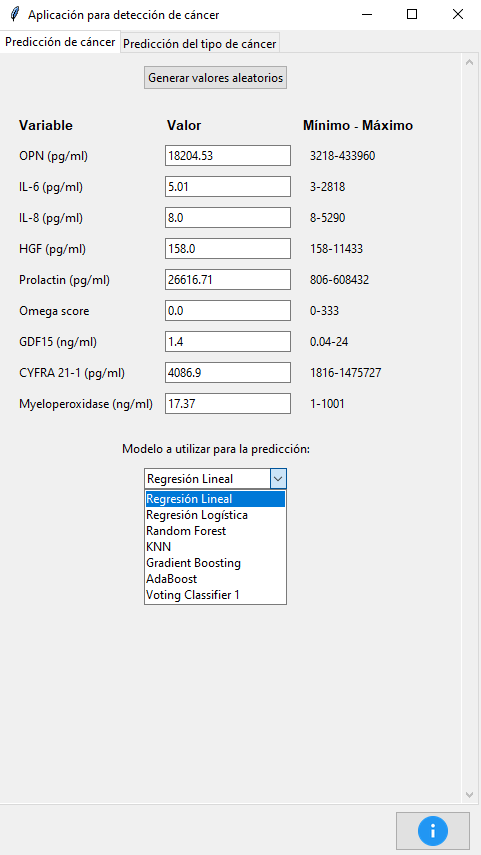
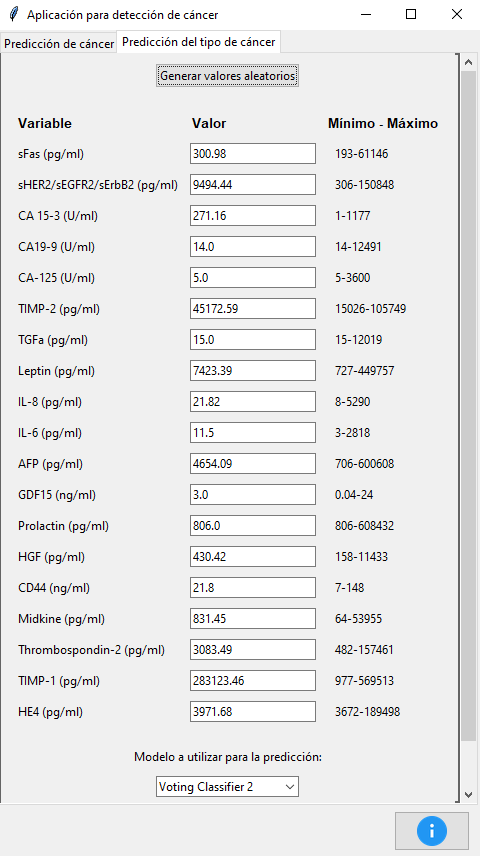

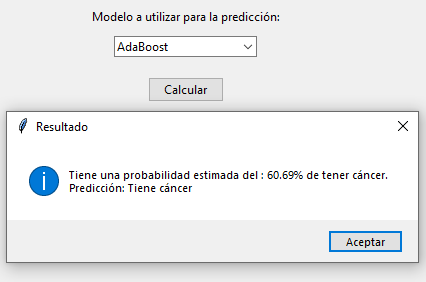
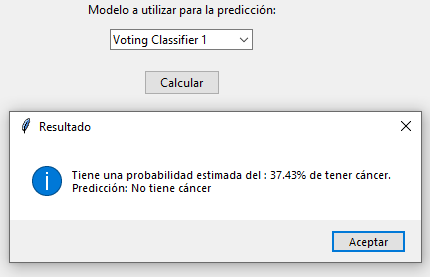
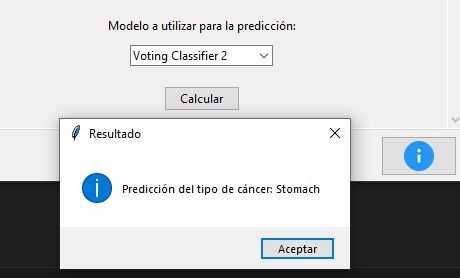

# Conclusiones, dificultades y caminos abiertos

## Problemas

- Falta de datos reales para poder poner a prueba en una situación real de producción los modelos entrenados
- A la hora de entrenar los modelos y guardarlos, se observa que es preciso cargarlos bajo el mismo entorno de VM donde se cargaron, si no el modelo puede dar problemas.
- Observamos en un primer momento que las predicciones obtenidas en la aplicación eran todas positivas, es decir, siempre se detectaba cáncer. Esto se debía a que no se tuvo en cuenta que el registro introducido por el usuario debe preprocesarse para asimilarse al formato con el que se preprocesaron los datos de entrenamiento y con los que se entrenaron los modelos.

## Caminos abiertos

- Partimos de la base de que los datos del estudio son de muy buena calidad y preparados "a mano" escogiendo las variables explícitamente para el estudio. El problema reside en que se tiene una muestra pequeña de datos de muy alta calidad. Sería conveniente tener acceso o poder recolectar más datos para poder entrenar los modelos y hacerlos más robustos y fiables.

- En caso de no tener acceso a nuevos datos reales, existe la posibilidad de generar nuevos datos sintéticos con el modelo CTGAN a expensas de acabar sesgando las predicciones del modelo ya que, a pesar de generar datos con distribuciones parejas a los datos originales, no se podrá replicar por completo la compleja aleatoriedad ni las relaciones que subyacen entre los biomarcadores.

- En cuanto al procesamiento de los datos:
    - Se lleva a cabo un estudio de relleno de los valores nulos mediante distintas técnicas pero, al haber pocos registros faltantes, optamos por técnicas básicas para el relleno. Quizá exista la posibilidad de mejorar resultados abordando el sujeto con otro enfoque.
    - 

- Hubiera sido conveniente replicar el modelo CancerA1DE y CancerA2DE utilizados en el estudio original por comprender mejor el planteamiento, su funcionamiento y rendimiento. Tambén para poder compararlos de manera 'local' frente a nuestros modelos. Debido a dificultades técnicas y falta de tiempo para afrontarlas, no nos ha sido posible.


- Modelos y datos :
    - Hay una tendencia general en los modelos a tender al sobreajuste debido a la restringida muestra de datos del estudio.

    - Partimos de la base de que los datos del estudio son de muy buena calidad y preparados "a mano" escogiendo las variables explícitamente para el estudio. El problema reside en que se tiene una muestra pequeña de datos de muy alta calidad. Sería conveniente tener acceso o poder recolectar más datos para poder entrenar los modelos y hacerlos más robustos y fiables.

    - En caso de no tener acceso a nuevos datos reales, existe la posibilidad de generar nuevos datos sintéticos con el modelo CTGAN a expensas de acabar sesgando las predicciones del modelo ya que, a pesar de generar datos con distribuciones parejas a los datos originales, no se podrá replicar por completo la compleja aleatoriedad ni las relaciones que subyacen entre los biomarcadores.

    - Se puede continuar el estudio tanto ampliando la oferta de modelos como, ahondar en los estudiados para ajustar más finamente los hipérparámetros. 

    - De igual manera, pueden añadirse más modelos competentes al vosting classifier y así hacerlo más robusto. 

    - Trás el estudio, llegamos a la conclusión de que los modelos no supervisados no presentan una mejora significativa para la predicción del cáncer. Un posible enfoque es desechar esta conclusión y profundizar en los modelos no supervisados y su posible influencia en la predicción.

    - Vemos que en la aplicación final, para cada modelo, la probabilidad difiere considerablemente según qué registros de entrada. Mantenemos que puede deberse a un sobreajuste de los modelos qué, aún obteniendo una misma predicción, la probabilidad de esta difiere quizás en demasía.

Podría estudiarse el llevar a cabo una fusión de los modelos CancerA1DE y CancerA2DE y los obtenidos por nuestra parte ya que puede aportar un resultado interesante. De esta manera, al tratarse la predicción con enfoques, tratamientos y modelos diferentes, se abarca mayor terreno y estaríamos ante modelos resultantes sumamente robustos.

## Conclusiones

Debido a la pequeña muestra de datos, los tiempos de entrenamiento y ajuste de los modelos han sido muy cómodos. Si nos hubiesemos encontrado ante una magnitud real de datos, los tiempos hubiesen sido tremendamente más largos y hubiesemos tenido que hacer un estudio más profundo para la reducción de tiempos en la búsqueda de los hiperparámetros óptimos y los entrenamientos de modelos.

En cuanto al estudio de los modelos no supervisados, se llega a la conclusión de que los outliers encontrados y que normalmente deberían desecharse para limpiar la muestra, ofrecen información valiosa acerca de la presencia de cáncer. El problema es que estos outliers se superponen para cada una de las variables haciendo que pierdan información y poderío en a predicción a la hora de clusterizar los datos. 